# Time Series Analysis

<a id='go-to-top'></a>

Index

Part 1
1. [Gathering the Data](#Gathering-the-data);
2. Cleaning and Exploration;
    * [Checking missing values and a first look at the data](#check-missing-values)
    * [Checking the variation of the stock's adjusted price over time](#time-variation)
    * [Descriptive statistics summary](#desc-stat)
    * [Mean percentage return for 2022](#mean-perc-ret)
    * [Stock returns, visualisation, descriptive statistics](#stock-return)
    * [Realized volatility and annualized volatility](#volatility)
    * [Volume traded](#volume-traded)
    * [Market Capitalisation](#market-capitalisation)
    * [Correlation](#correlation)


Part 2

J.P Morgan's Stock Data
1. [Data exploration and visualisation](#exploration-and-visualisation)
    * [Moving Average](#moving-average)
    * [Log return, absolute return, visualisation](#returns-jpm)
    * [Stock Attributes](#stock-attributes)
    * [Candlestick chart with MA and volume traded](#candlestick)
2. [Exponential Smoothing](#exponential-smoothing)
    * [Seasonal Decomposition](#seasonal-decomposition)
    * [Simple exponencial smoothing](#simple-exp-smoothing)
    * [Holt's linear/Dumped Smoothing](#double-exp-smoothing)
    * [Holt and Winter's Exponencial Smoothing](#triple-exp-smoothing)
3. [Linear models for stationary and non-stationary data](#model-building)
    * [Moving Average model](#moving-average-model)
    * [Autoregressive model](#autoregressive-model)
    * [Auto-ARIMA](#auto-arima)
    * [21 days forecasting](#forecasting-auto-arima)
4. [Volatility Modelling](#volatility-modelling)
    * [ARCH model](#ARCH-model)
    * [GARCH model](#GARCH-model)
    * [EGARCH model](#EGARCH-model)
5. [Long-Short Term Memory model](#lstm)
6. [Results](#results)

In [1]:
# Import libraries
import numpy as np
import pandas as pd
import datetime
import yfinance as yf
from yahoofinancials import YahooFinancials

# Importing required libraries for ARIMA, auto_Arima
import statsmodels.api as sm
from statsmodels.tsa.holtwinters import ExponentialSmoothing, SimpleExpSmoothing, Holt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.ar_model import AutoReg
from pmdarima.arima import auto_arima
from pmdarima.arima.utils import ndiffs
from arch import arch_model

from math import sqrt
from sklearn.metrics import mean_squared_error
import scipy.stats as stats


from pandas.tseries.offsets import DateOffset
from  sklearn.model_selection import train_test_split

import matplotlib as mpl
import matplotlib.pyplot as plt
import plotly.graph_objs as go
from plotly.subplots import make_subplots
import seaborn as sns
plt.style.use('seaborn')
mpl.rcParams['font.family'] = 'serif'
import cufflinks as cf

# Figure will appear below the cell that generated it
%matplotlib inline 
%config InlineBackend.figure_format = 'retina' 

import warnings
warnings.filterwarnings("ignore") 

# Part I

<a id='Gathering-the-data'><a/>

### Gathering the Data

In [2]:
# Download market data using yfinance API
stock_data=yf.download(
    tickers='JPM C GS MS UBS BCS', start='2018-01-01',
    end=datetime.date.today(),
    interval='1d', actions='inline'
)

[*********************100%***********************]  6 of 6 completed


In [3]:
stock_data.head(2)

Adj Close                                                          \
                 BCS          C          GS        JPM         MS        UBS   
Date                                                                           
2018-01-02  9.430713  64.162956  232.547546  94.219803  45.888203  15.673265   
2018-01-03  9.396513  64.361412  230.382797  94.315842  46.011299  15.918952   

            Close                                     ... Stock Splits         \
              BCS          C          GS         JPM  ...           GS JPM MS   
Date                                                  ...                       
2018-01-02  11.03  74.360001  255.669998  107.949997  ...            0   0  0   
2018-01-03  10.99  74.589996  253.289993  108.059998  ...            0   0  0   

                 Volume                                                 
           UBS      BCS         C       GS       JPM       MS      UBS  
Date                                                                    
2018-01-02   0  2479500  15819800  2258300  13578800  6644600  1312400  
2018-01-03   0  2092900  14657900  2988200  11901000  6955500  2617200  

[2 rows x 48 columns]

In [4]:
stock_data.shape

(1177, 48)

<a id='check-missing-values'></a>

In [5]:
# Check for missing data
stocks_adj_close_price = stock_data['Adj Close'].copy()
stocks_adj_close_price.isnull().sum()

BCS    0
C      0
GS     0
JPM    0
MS     0
UBS    0
dtype: int64

In [6]:
stocks_adj_close_price.fillna(method='ffill')
stocks_adj_close_price.duplicated().sum()

0

In [7]:
stocks_adj_close_price.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1177 entries, 2018-01-02 to 2022-09-02
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   BCS     1177 non-null   float64
 1   C       1177 non-null   float64
 2   GS      1177 non-null   float64
 3   JPM     1177 non-null   float64
 4   MS      1177 non-null   float64
 5   UBS     1177 non-null   float64
dtypes: float64(6)
memory usage: 64.4 KB


<a id='time-variation'></a>

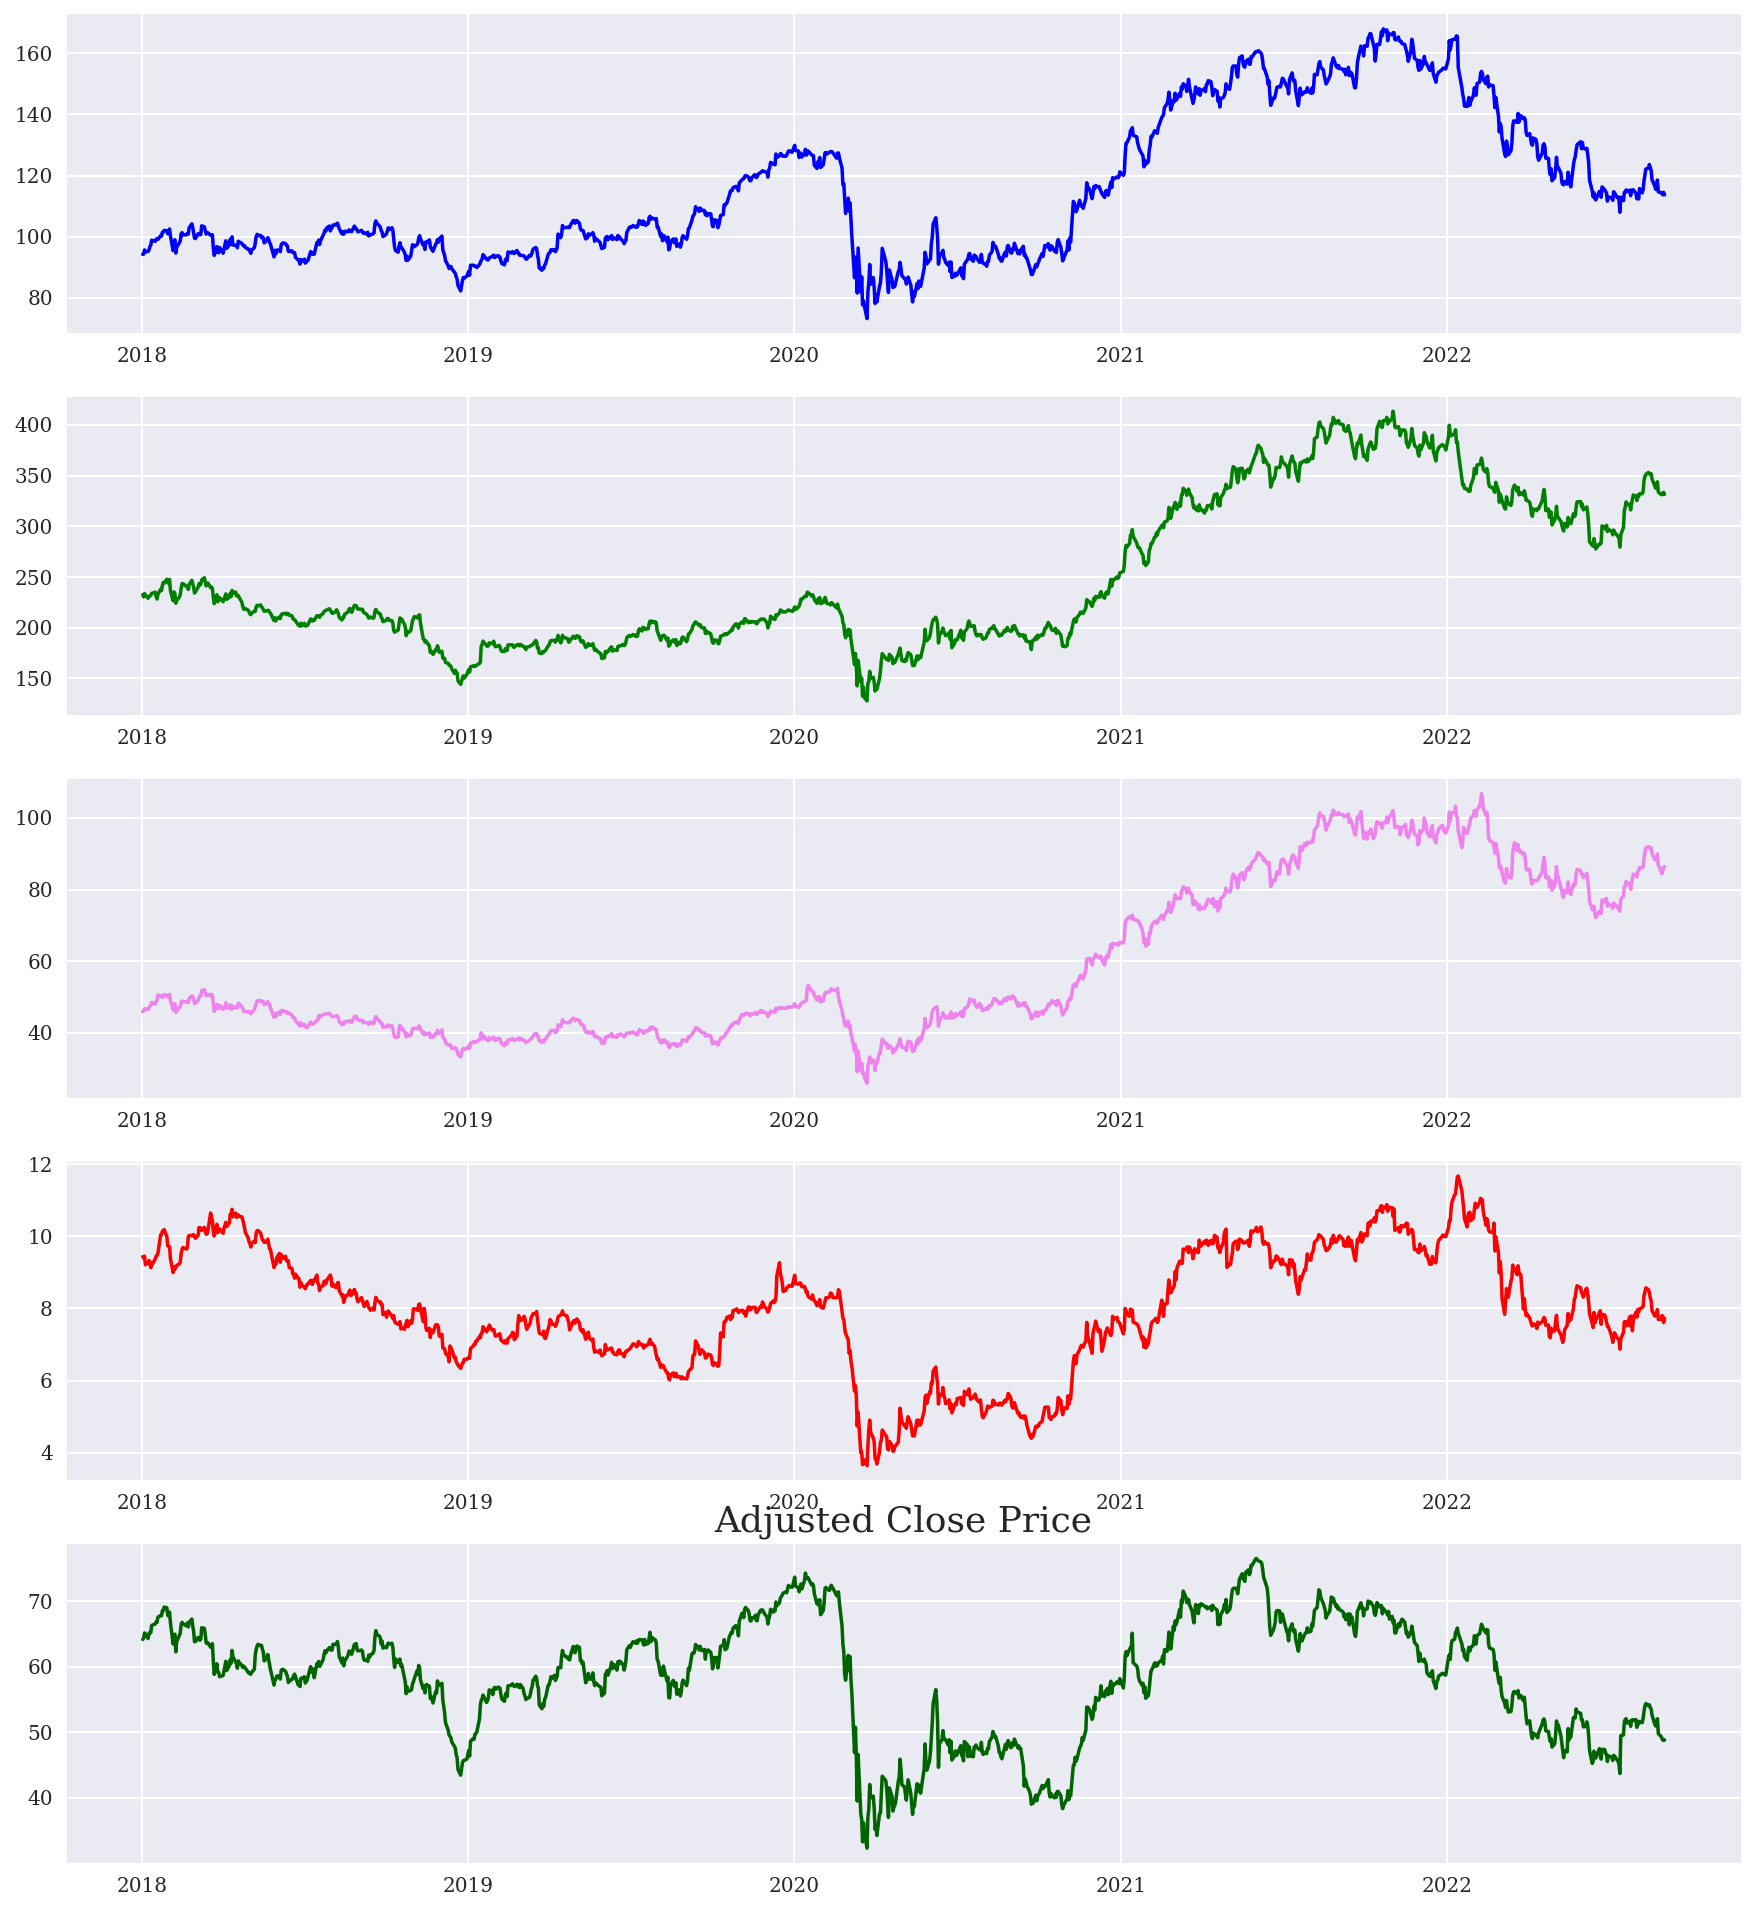

In [8]:
stocks_adj_close_price.rename(
    columns = {'BCS': 'Barclays', 'C': 'Citigroup', 
               'GS': 'Goldman Sachs', 'MS': 'Morgan Stanley',
               'JPM': 'J.P Morgan'},
    inplace=True)
# Visualisation

fig, ax = plt.subplots(5, 1, figsize = (15, 17))
plt.title('Adjusted Close Price', fontdict={'fontsize': 18})
ax[0].plot(stocks_adj_close_price['J.P Morgan'],label = 'JPMorgan', color = 'b' )
ax[1].plot(stocks_adj_close_price['Goldman Sachs'],label = 'Goldman Sachs' , color = 'g') # magenta
ax[2].plot(stocks_adj_close_price['Morgan Stanley'],label = 'Morgan Stanley', color = 'violet')
ax[3].plot(stocks_adj_close_price['Barclays'], label = 'Barclays', color = 'r')
ax[4].plot(stocks_adj_close_price['Citigroup'], label = 'Citygroup', color = 'darkgreen')
plt.show()


<Figure size 1152x504 with 0 Axes>

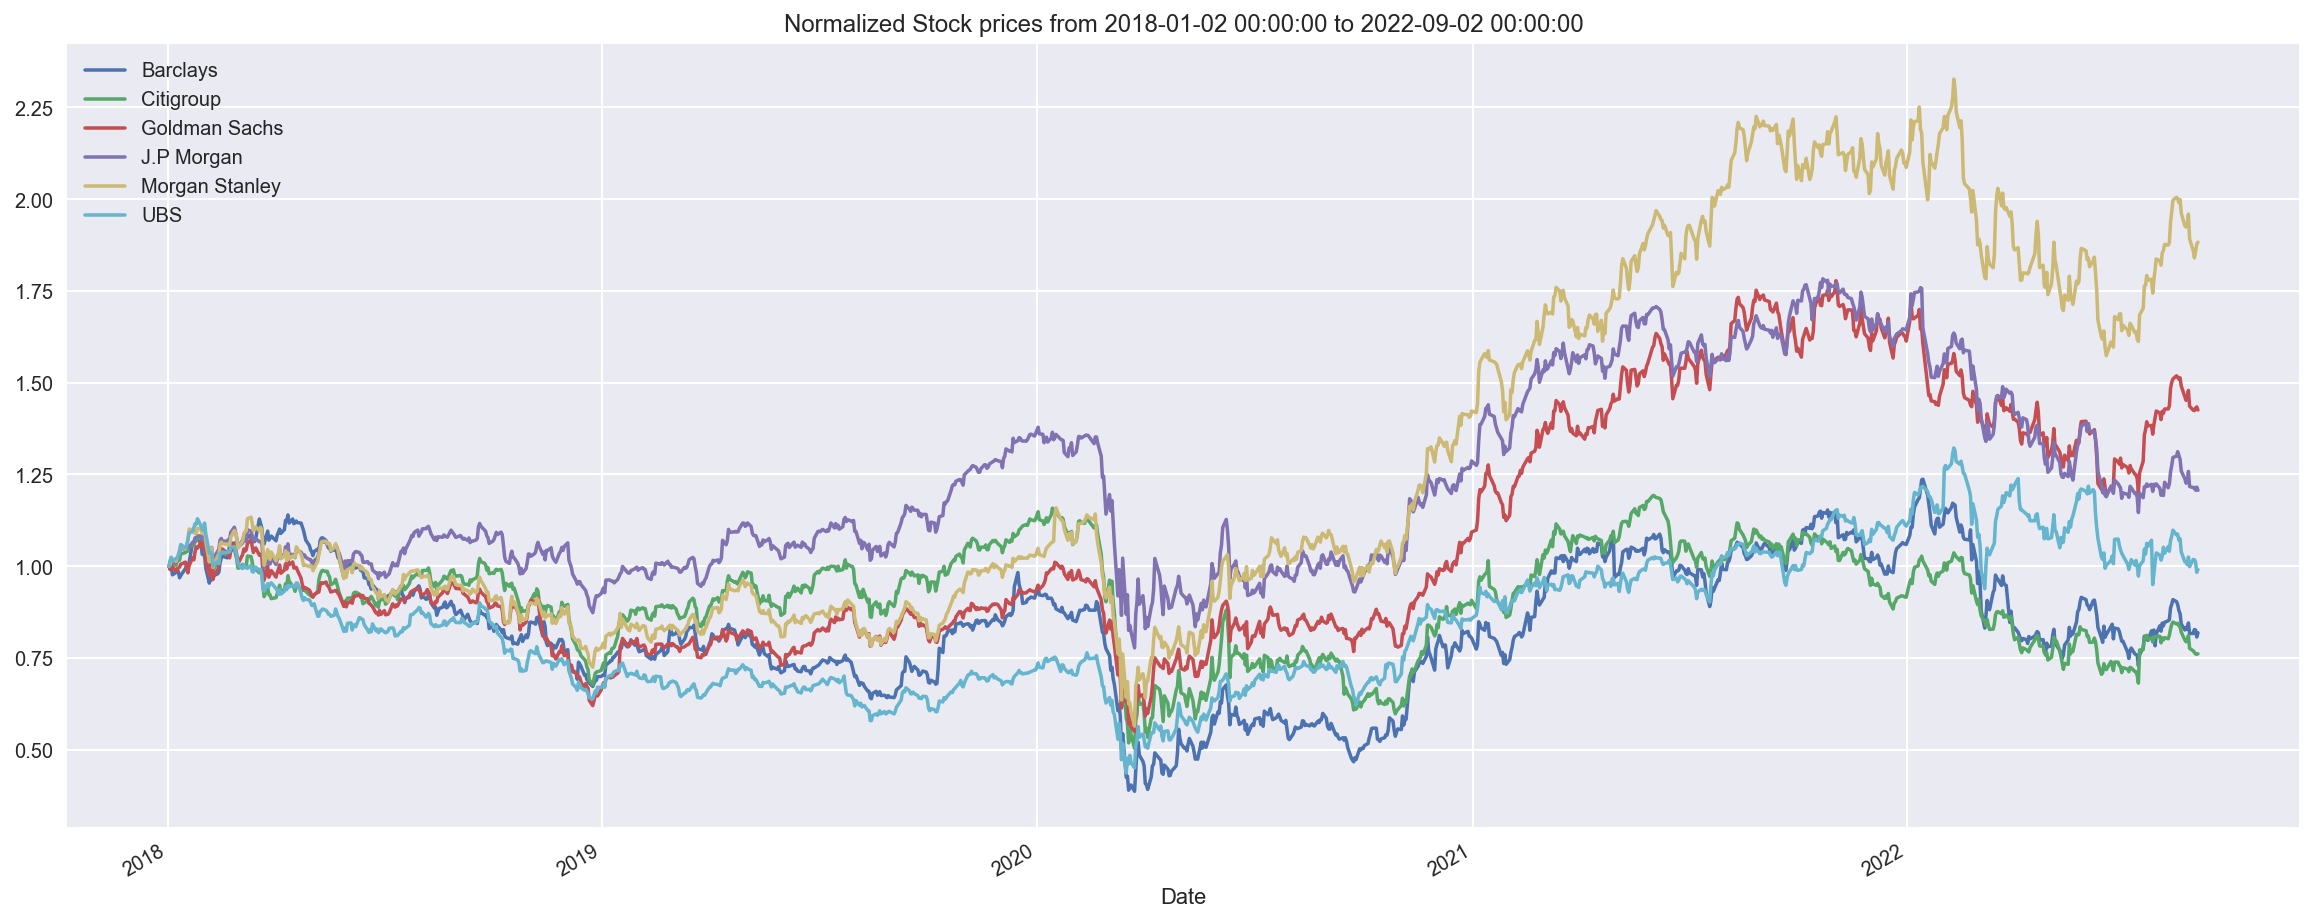

In [9]:
adj_close_price_n = pd.DataFrame()
for x in range(len(stocks_adj_close_price.columns)):
    adj_close_price_n[stocks_adj_close_price.columns[x]] = stocks_adj_close_price.iloc[:, x].div(stocks_adj_close_price.iloc[0, x])

    
plt.figure(figsize=(16, 7))  
plt.style.use('seaborn')
plot = adj_close_price_n.plot(
    figsize=(20, 8),
    title=f'Normalized Stock prices from {stocks_adj_close_price.index[0]} to {stocks_adj_close_price.index[-1]}',)

plot.get_figure().savefig('Stock_prices.jpg')

[GO TO TOP](#go-to-top)

<a id='desc-stat'></a>

In [10]:
stocks_adj_close_price.describe().round(2)

Barclays  Citigroup  Goldman Sachs  J.P Morgan  Morgan Stanley      UBS
count   1177.00    1177.00        1177.00     1177.00         1177.00  1177.00
mean       7.96      58.53         251.15      115.44           59.20    13.36
std        1.69       8.97          74.21       23.80           22.11     2.91
min        3.64      32.31         127.80       73.23           25.89     6.83
25%        6.97      52.05         192.51       96.34           41.45    10.82
50%        7.90      59.88         217.07      105.25           47.85    13.25
75%        9.40      65.20         321.00      132.17           81.04    15.79
max       11.67      76.53         413.48      168.01          106.79    20.72

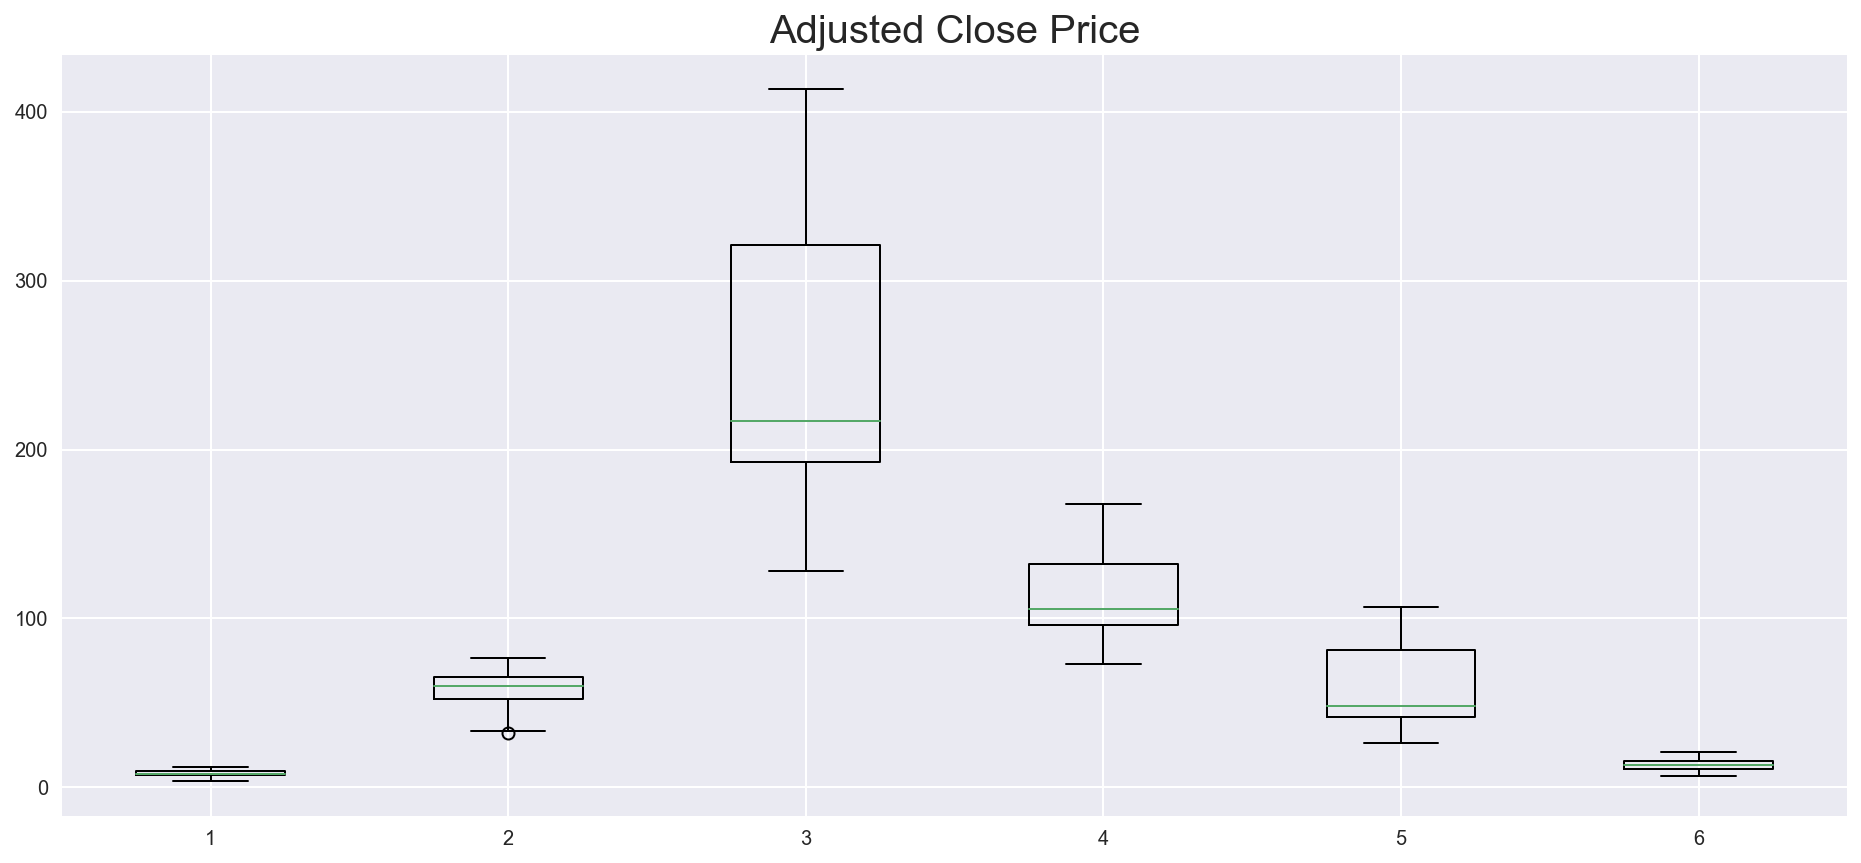

In [11]:
plt.figure(figsize=(16, 7))
plt.boxplot(stocks_adj_close_price)
plt.title('Adjusted Close Price', fontdict = {'fontsize': 20});

[GO TO TOP](#go-to-top)

<a id='stock-return'></a>

<a id='mean-perc-ret'></a>

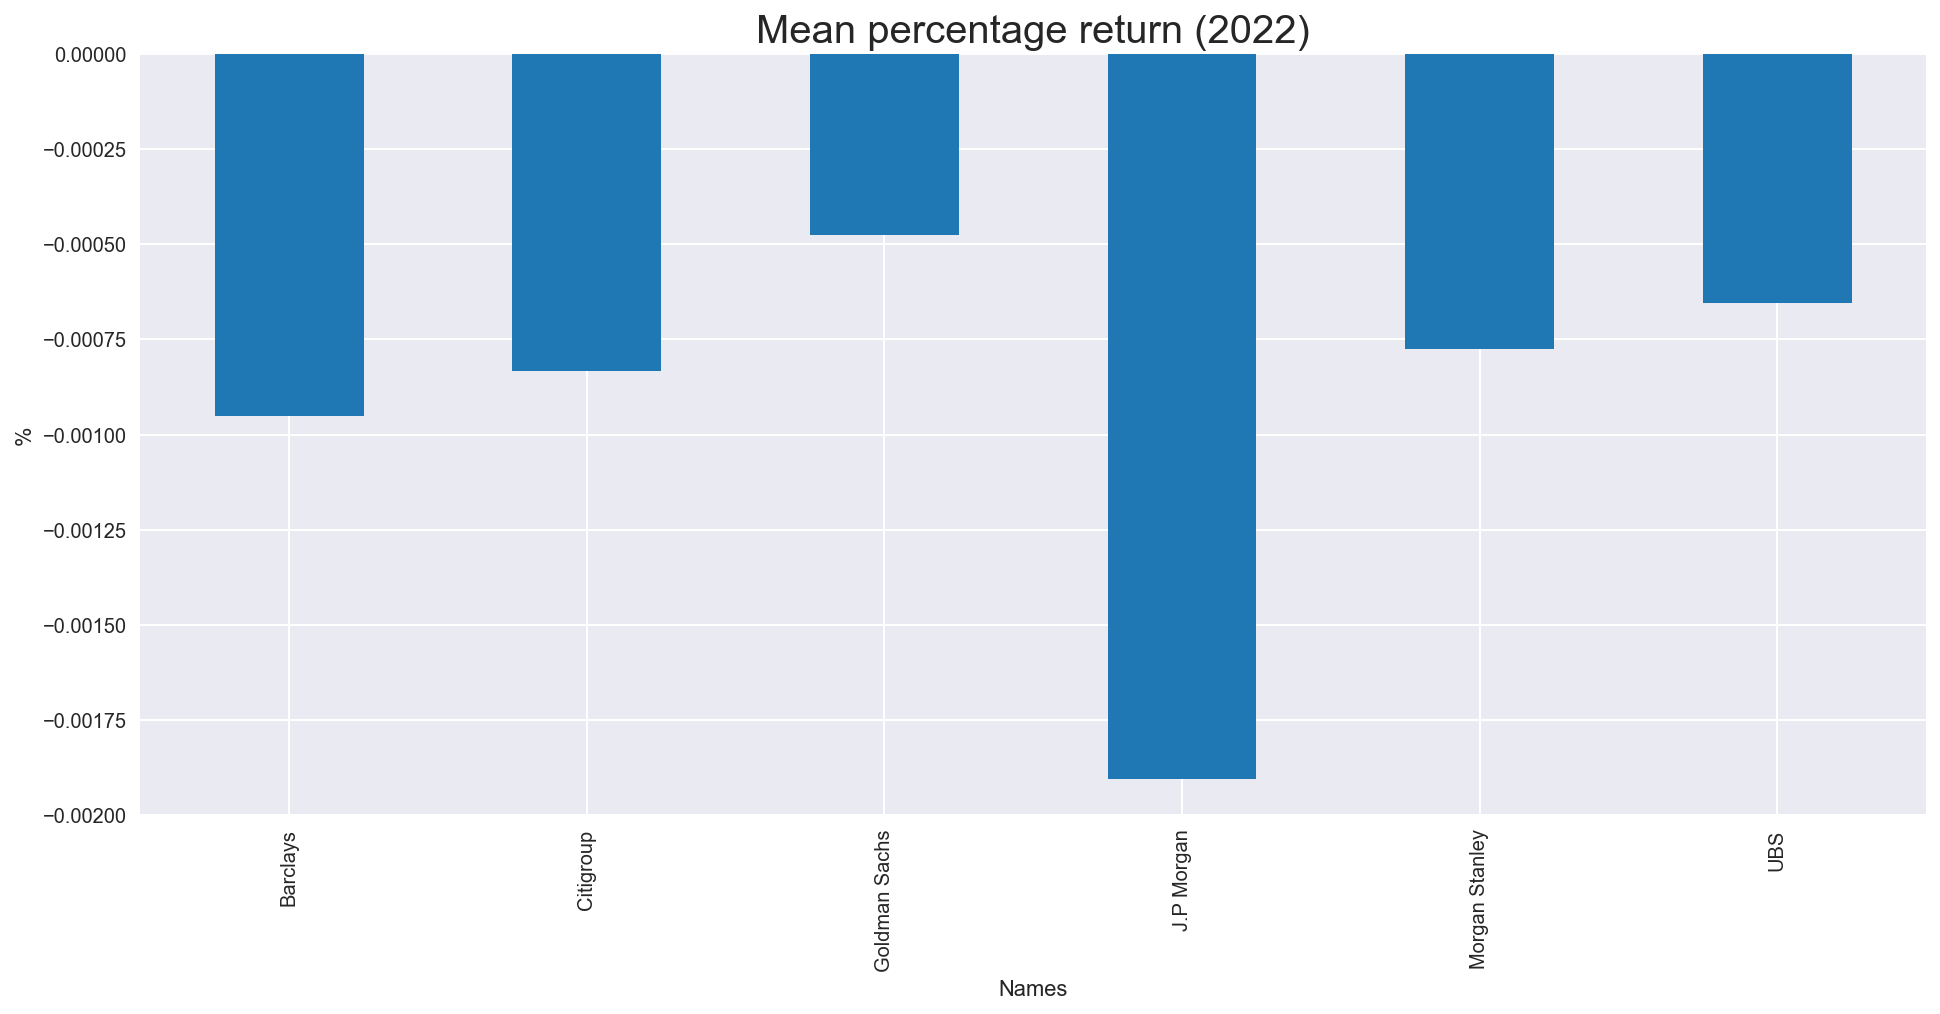

In [12]:
stocks_adj_close_price.loc['2022-01-01':].pct_change().round(2).mean().plot(
    kind='bar', figsize=(16, 7), 
    colormap='tab20')
plt.title('Mean percentage return (2022)', fontdict={'fontsize': 20})
plt.xlabel('Names')
plt.ylabel('%');

[GO TO TOP](#go-to-top)

It is better to calculate return on adjusted price as it reflects that stock's value after accounting for corporate actions like dividend-paying and stock splits.

In [13]:
returns_df = np.log(stocks_adj_close_price / stocks_adj_close_price.shift(1))
returns_all = returns_df * 100
returns_all.dropna(inplace=True)
returns_all.describe()

Barclays    Citigroup  Goldman Sachs   J.P Morgan  Morgan Stanley  \
count  1176.000000  1176.000000    1176.000000  1176.000000     1176.000000   
mean     -0.017020    -0.023204       0.030142     0.015988        0.053808   
std       2.609701     2.480068       2.103358     2.031625        2.251157   
min     -24.656389   -21.441418     -13.588050   -16.210594      -16.960278   
25%      -1.149745    -1.087267      -0.969286    -0.862069       -1.054600   
50%       0.000000    -0.014654       0.006173    -0.002983        0.071752   
75%       1.103306     1.068446       1.108339     0.953352        1.177919   
max      17.248638    16.538138      16.195137    16.562052       18.040343   

               UBS  
count  1176.000000  
mean     -0.000836  
std       2.039512  
min     -17.026653  
25%      -0.941887  
50%       0.000000  
75%       0.987399  
max      12.590742

Text(0.5, 0, 'Time')

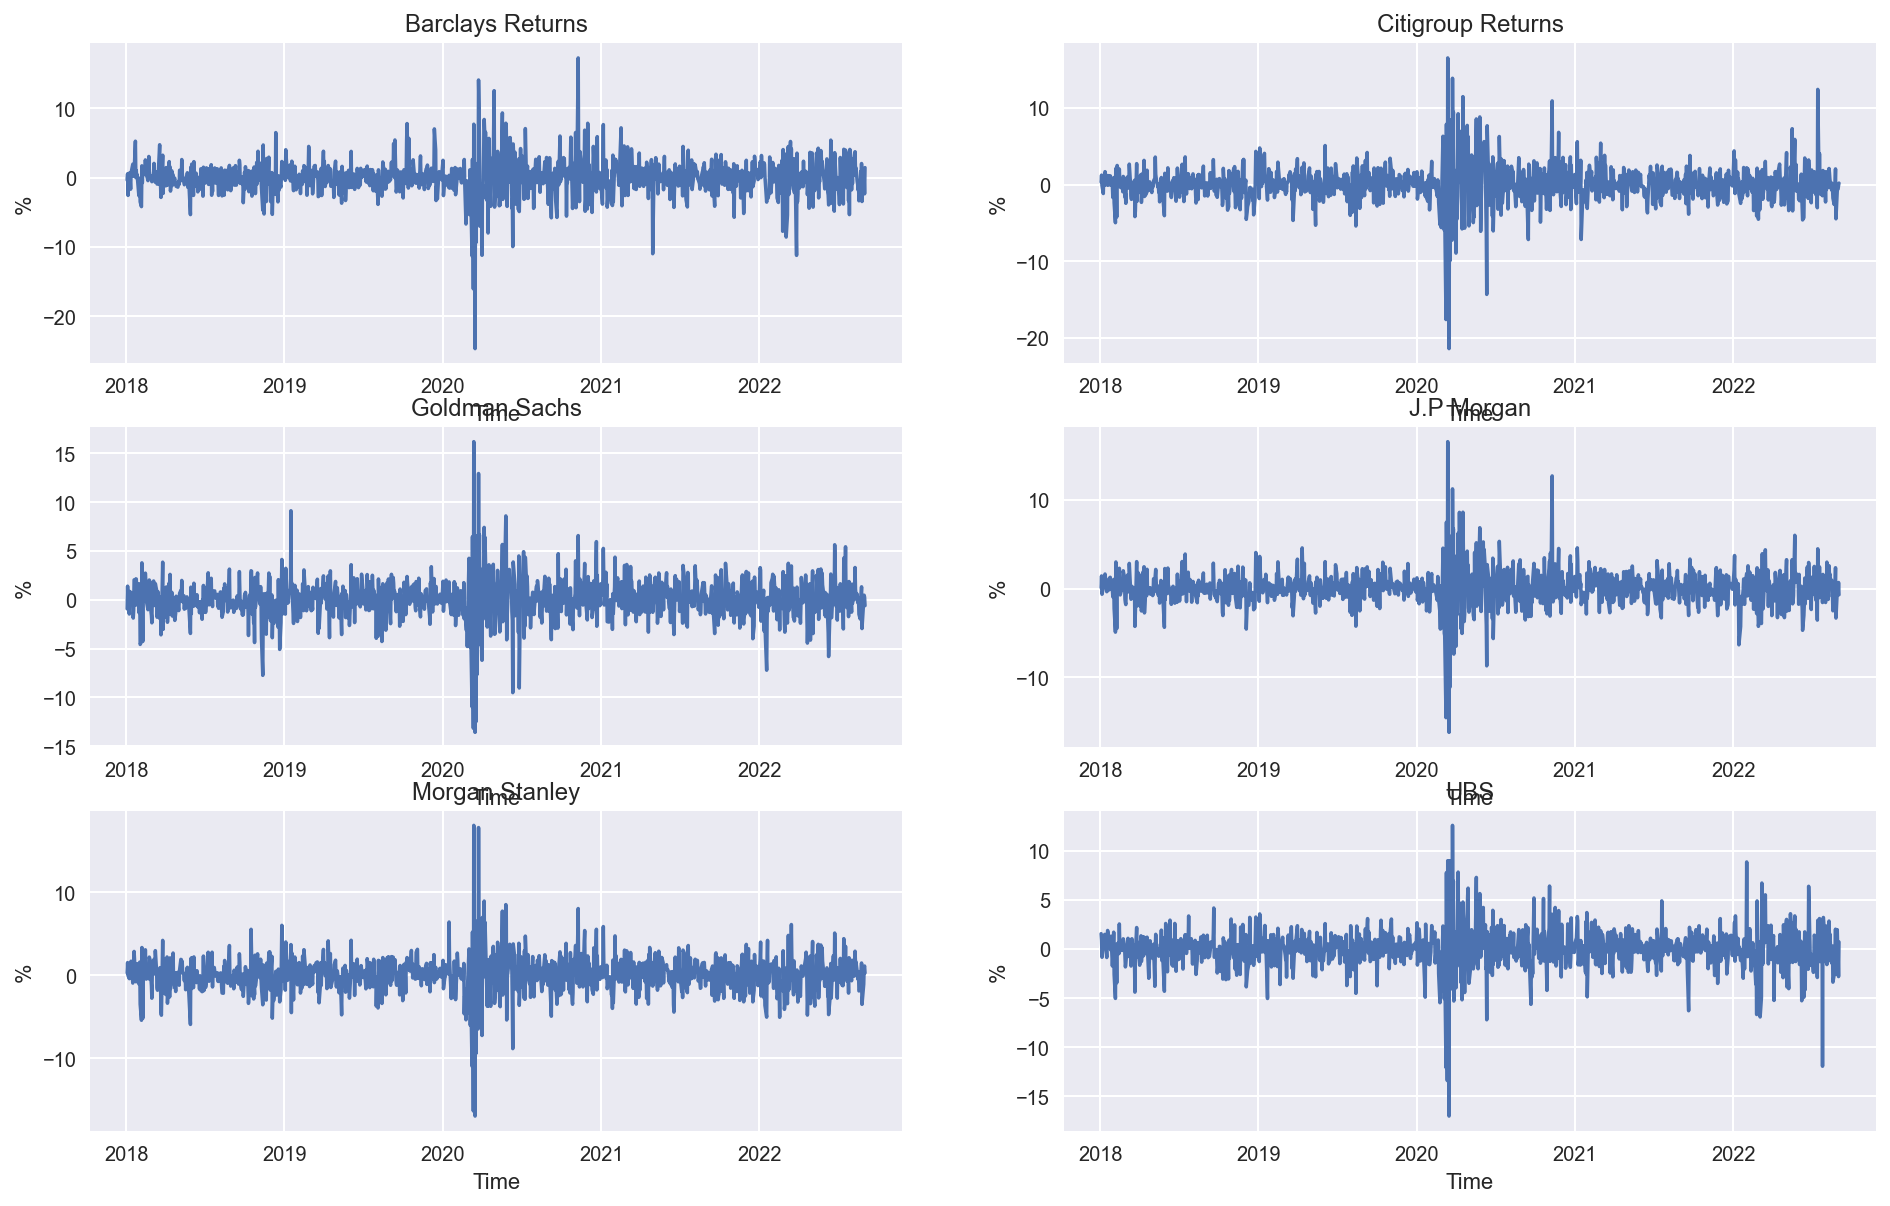

In [14]:
plt.figure(figsize=(16, 10))
plt.subplot(3, 2, 1)
plt.plot(returns_all['Barclays'])
plt.ylabel('%')
plt.title('Barclays Returns')
plt.xlabel('Time')
plt.subplot(3, 2, 2)
plt.plot(returns_all['Citigroup'])
plt.ylabel('%')
plt.title('Citigroup Returns')
plt.xlabel('Time')
plt.subplot(3, 2, 3)
plt.plot(returns_all['Goldman Sachs'])
plt.ylabel('%')
plt.title('Goldman Sachs')
plt.xlabel('Time')
plt.subplot(3, 2, 4)
plt.plot(returns_all['J.P Morgan'])
plt.ylabel('%')
plt.title('J.P Morgan')
plt.xlabel('Time')  
plt.subplot(3, 2, 5)
plt.plot(returns_all['Morgan Stanley'])
plt.ylabel('%')
plt.title('Morgan Stanley')
plt.xlabel('Time')
plt.subplot(3, 2, 6)
plt.plot(returns_all['UBS'])
plt.ylabel('%')
plt.title('UBS')
plt.xlabel('Time')

Realized volatility is the square root of realized variance, which is the sum of squared return.

<a id='volatility'></a>

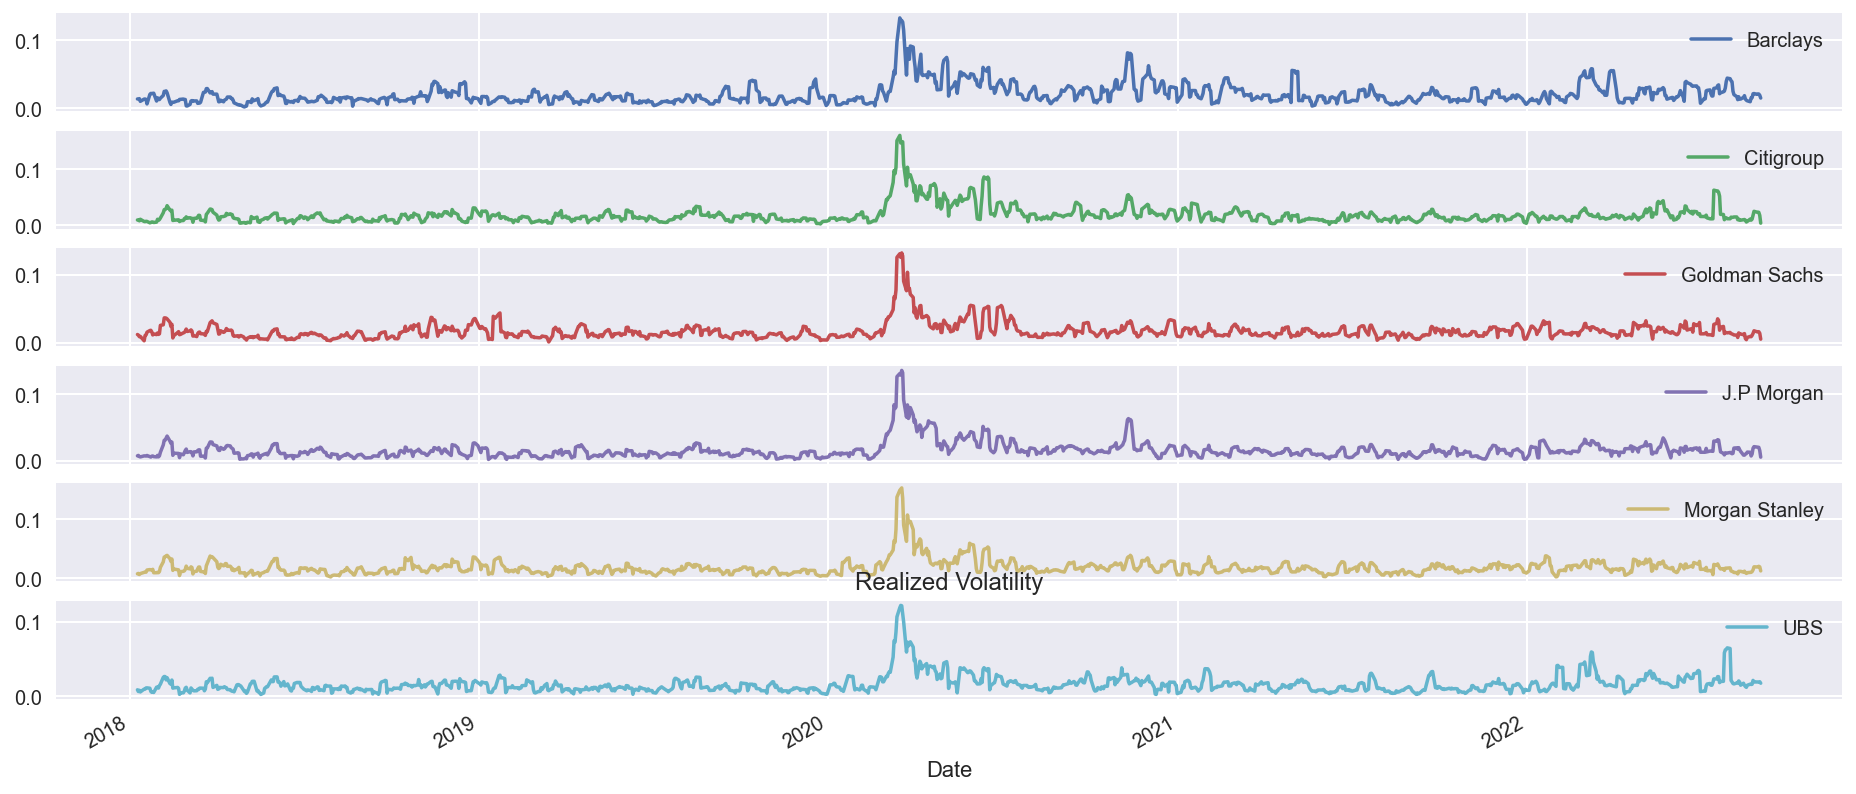

In [15]:
realized_vol = returns_df.rolling(5).std()
realized_vol.plot(figsize=(16, 7), subplots=True)
plt.title('Realized Volatility');

The plot shows the realized volatility of investment bank's over the period of 2018–2022. The most striking observation is the spikes around the COVID-19 pandemic.

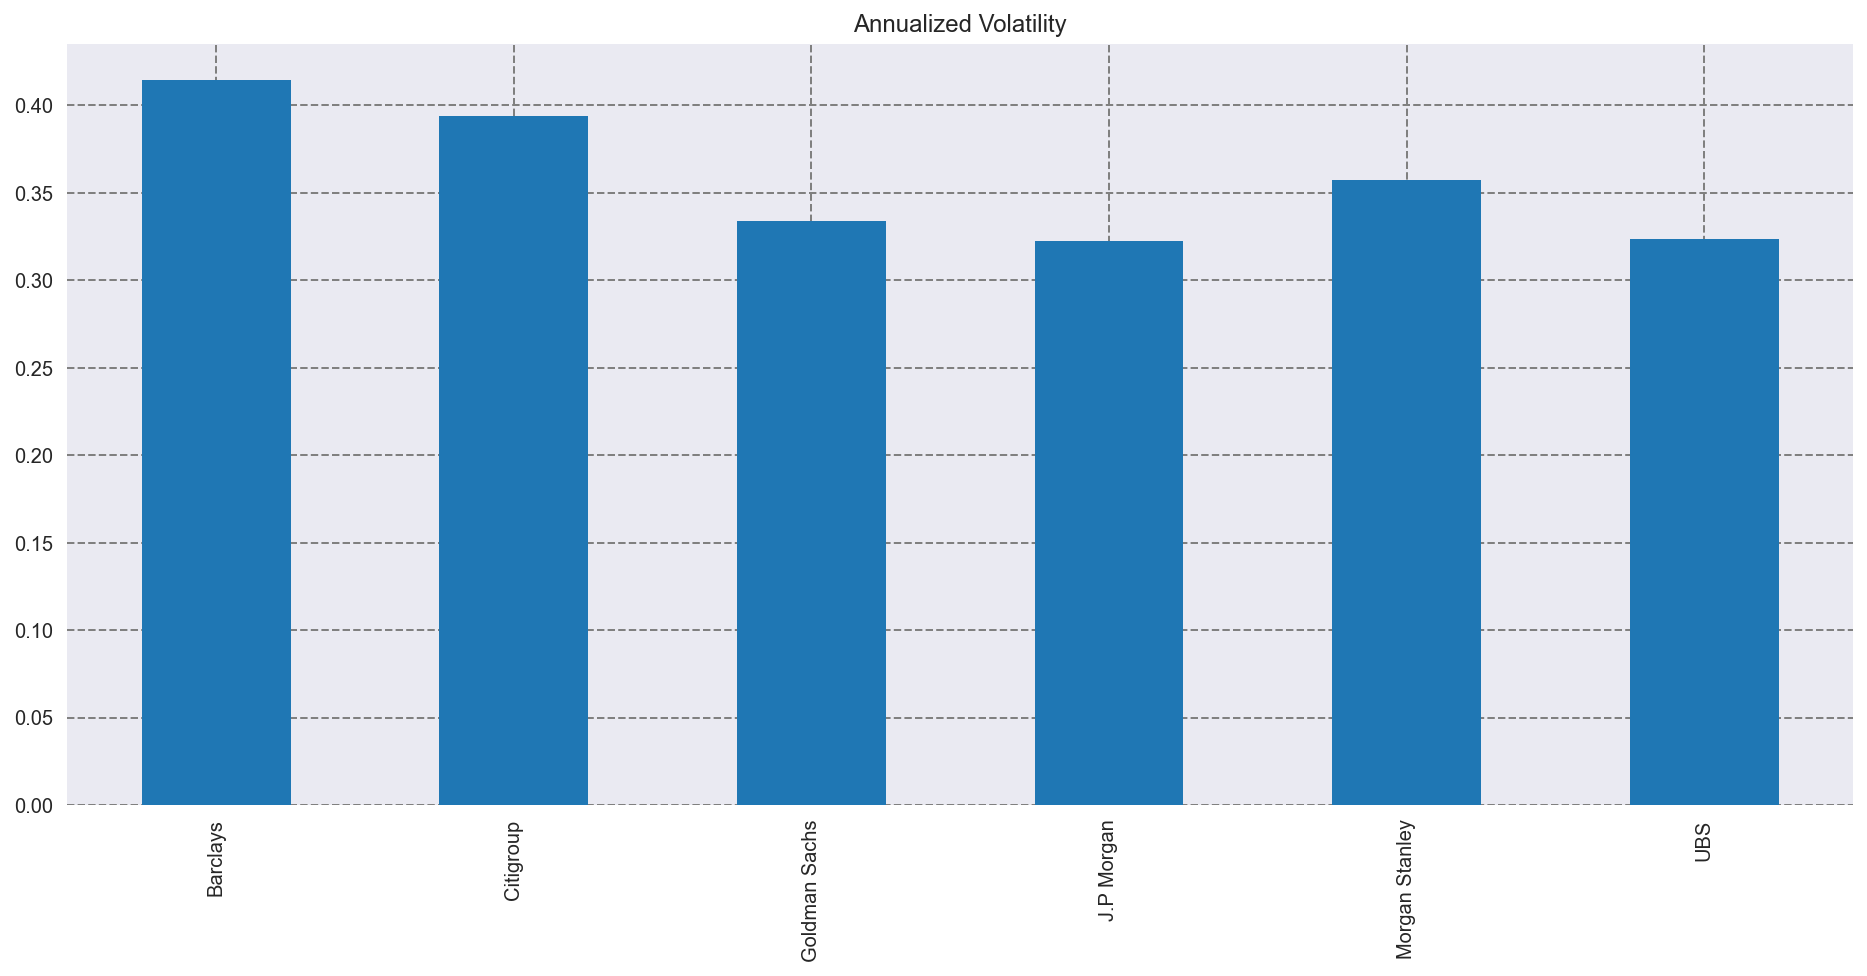

In [16]:
daily_volatility = returns_df.std()
annualized_volatility = daily_volatility * np.sqrt(252)
annualized_volatility.plot(kind='bar', colormap='tab20', figsize=(16, 7))
plt.title('Annualized Volatility')
plt.grid(linestyle='--', c='grey');

[GO TO TOP](#go-to-top)

<a id='volume-traded'></a>

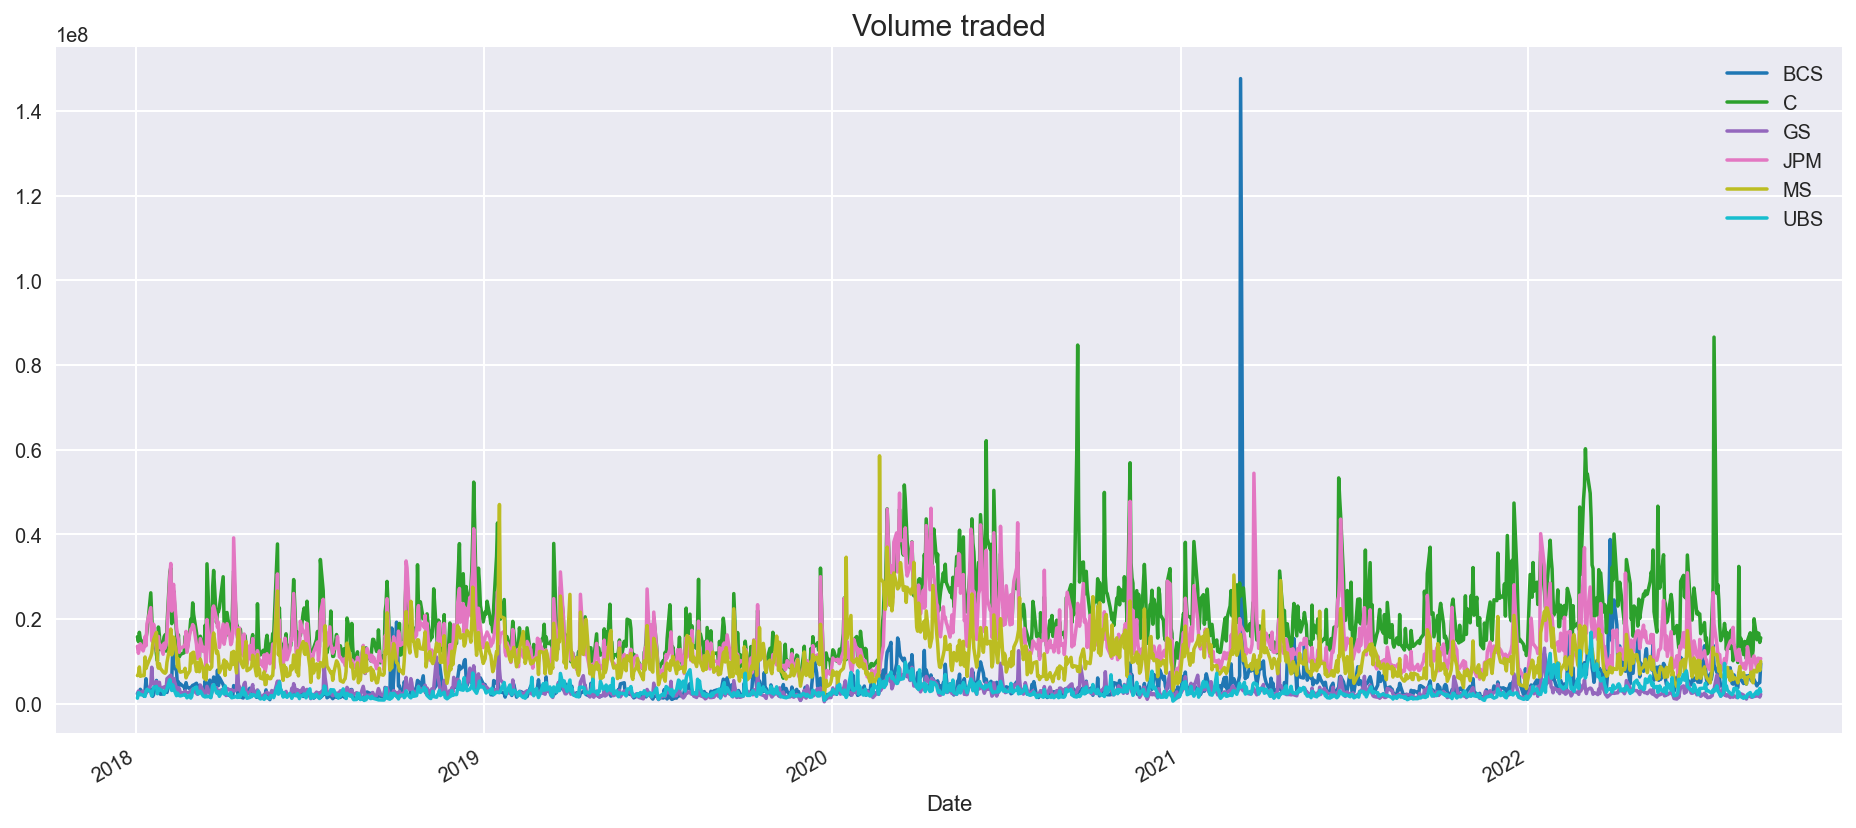

In [17]:
stock_volumes = stock_data['Volume'].copy()
stock_volumes.plot(figsize=(16, 7), colormap='tab10')
plt.title('Volume traded', fontdict={'fontsize': 15});

[GO TO TOP](#go-to-top)

<a id='market-capitalisation'></a>

### Market Capitalisation

In [18]:
stocks_close_price = stock_data['Close'].copy()
tickers = stocks_close_price.columns

def num_shares_outstanding(*tikers):
    data = {}
    for x in tickers:
        yahoo_financials = YahooFinancials(x)
        value = yahoo_financials.get_num_shares_outstanding()
        data[x] = int(value)
        num_shares_outstanding = pd.DataFrame(data, index=['Shares Outstanding']).T
    return num_shares_outstanding 


shares_outstanding = num_shares_outstanding(tickers)
shares_outstanding

Shares Outstanding
BCS          3895169989
C            1933139907
GS            341356003
JPM          2932570013
MS           1716830056
UBS          3496660189

In [19]:
stocks_close_price = stock_data['Close'].copy()
df = pd.DataFrame(index = stocks_close_price.columns)

market_cap = {}
for i in range(len(stocks_close_price.columns)):
    value = stocks_close_price.iloc[-1, i] * shares_outstanding.iloc[i, 0]
    market_cap[shares_outstanding.index[i]] = int(value)
    
    
market_cap = pd.DataFrame(market_cap, index=['Market Capitalisation']).T
Market_capitalisation = shares_outstanding.join(market_cap).sort_values(
    by='Market Capitalisation', ascending=True
)
Market_capitalisation

Shares Outstanding  Market Capitalisation
BCS          3895169989            30070711497
UBS          3496660189            54268167733
C            1933139907            94414553352
GS            341356003           113152691624
MS           1716830056           148334119458
JPM          2932570013           333462533493

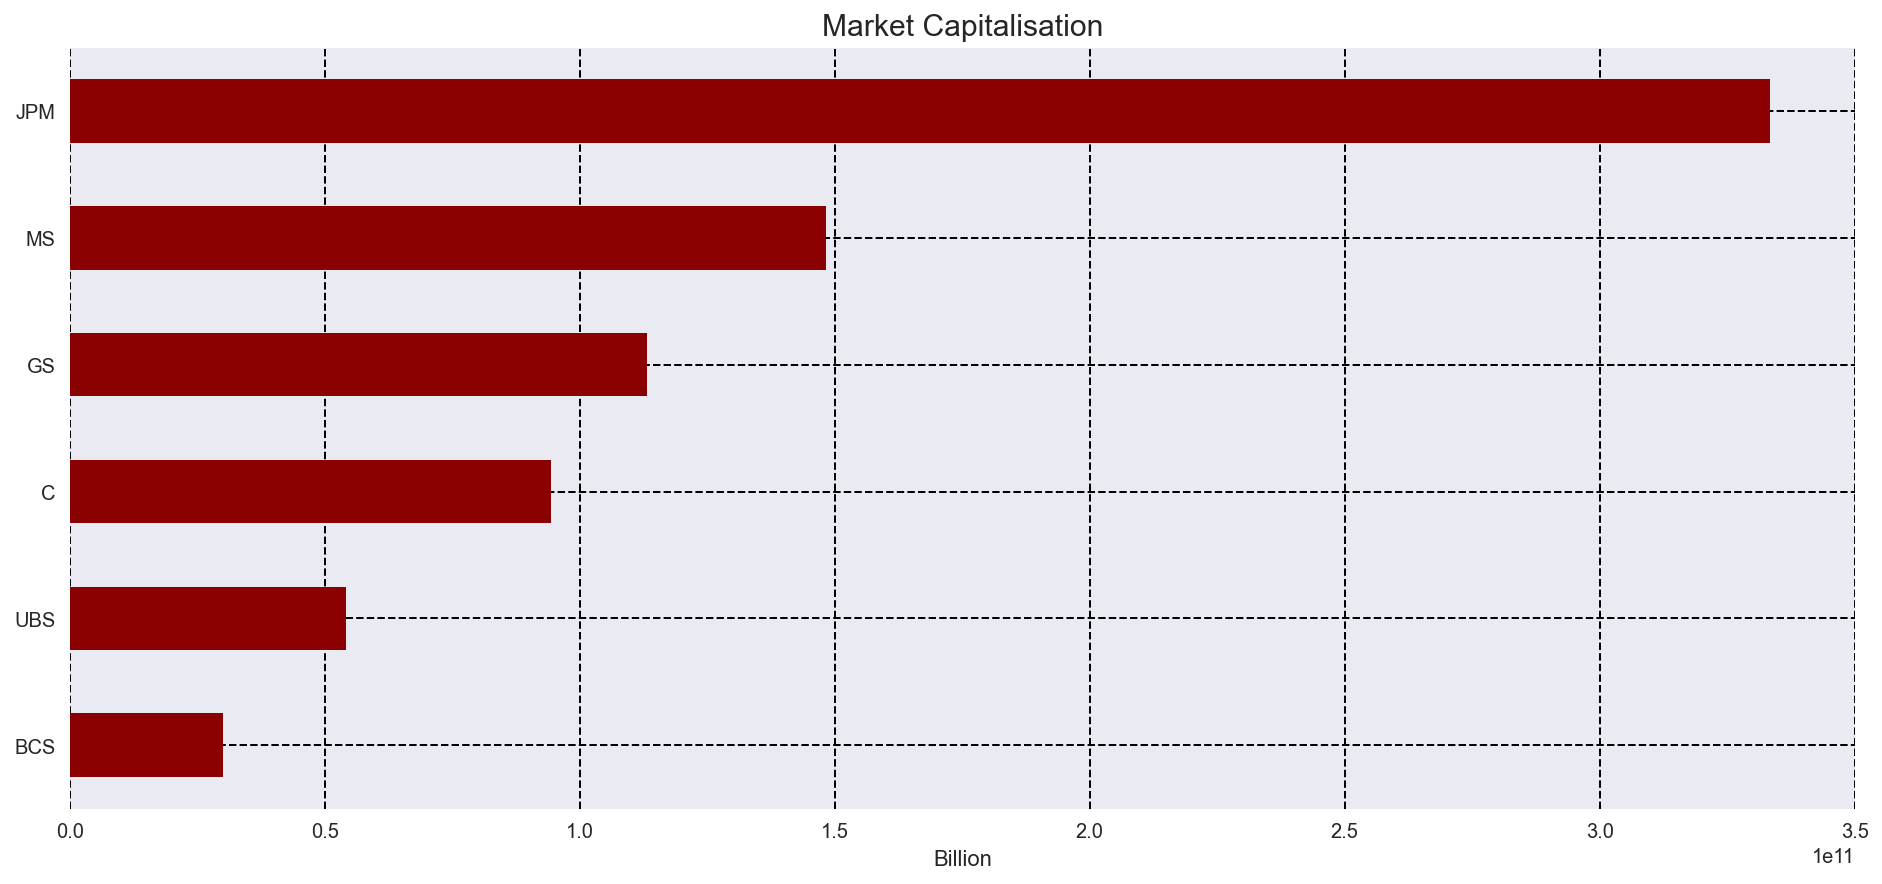

In [20]:
Market_capitalisation['Market Capitalisation'].plot(
    kind='barh', figsize=(16, 7), 
    color='Darkred')
plt.title('Market Capitalisation', fontdict={'fontsize': 15})
plt.xlabel('Billion')
plt.grid(linestyle='--', c='k');

Let's see the relationship that exists between stocks and their respective price movements.

[GO-TO-TOP](#go-to-top)

<a id='correlation'></a>

### Correlation

In [21]:
stocks_adj_close_price.corr()

Barclays  Citigroup  Goldman Sachs  J.P Morgan  \
Barclays        1.000000   0.778582       0.689219    0.677600   
Citigroup       0.778582   1.000000       0.438586    0.604982   
Goldman Sachs   0.689219   0.438586       1.000000    0.920577   
J.P Morgan      0.677600   0.604982       0.920577    1.000000   
Morgan Stanley  0.604454   0.318153       0.981089    0.896133   
UBS             0.753085   0.349179       0.859438    0.703716   

                Morgan Stanley       UBS  
Barclays              0.604454  0.753085  
Citigroup             0.318153  0.349179  
Goldman Sachs         0.981089  0.859438  
J.P Morgan            0.896133  0.703716  
Morgan Stanley        1.000000  0.857071  
UBS                   0.857071  1.000000

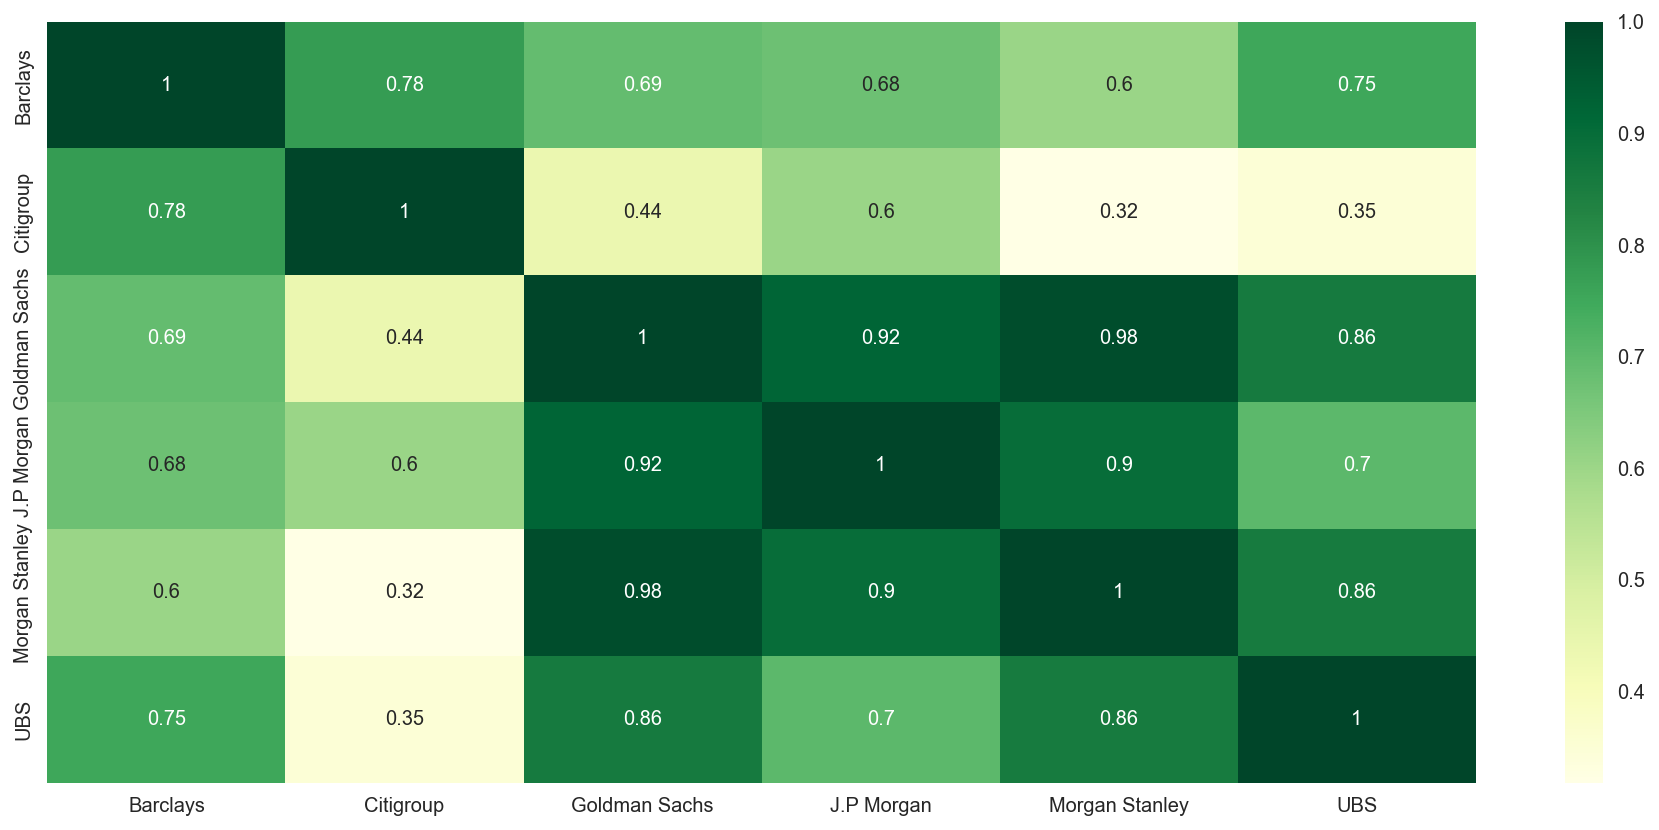

In [22]:
plt.figure(figsize=(16, 7))
sns.heatmap(stocks_adj_close_price.corr(), cmap='YlGn', annot=True);

We can observe that there is a strong correlation between almost all investment banks. But 
What we need to do is find out whether the change in one stock earlier in time can predict the change in another stock later in time. To do this, we shift one of the differences of the stocks back by 1 before looking at the scatter plot.

In [23]:
c = stocks_adj_close_price.diff().shift(1)['J.P Morgan'].to_frame()
c['Goldman Sachs'] = stocks_adj_close_price.diff()['Goldman Sachs']
c.corr()

J.P Morgan  Goldman Sachs
J.P Morgan       1.000000      -0.055844
Goldman Sachs   -0.055844       1.000000

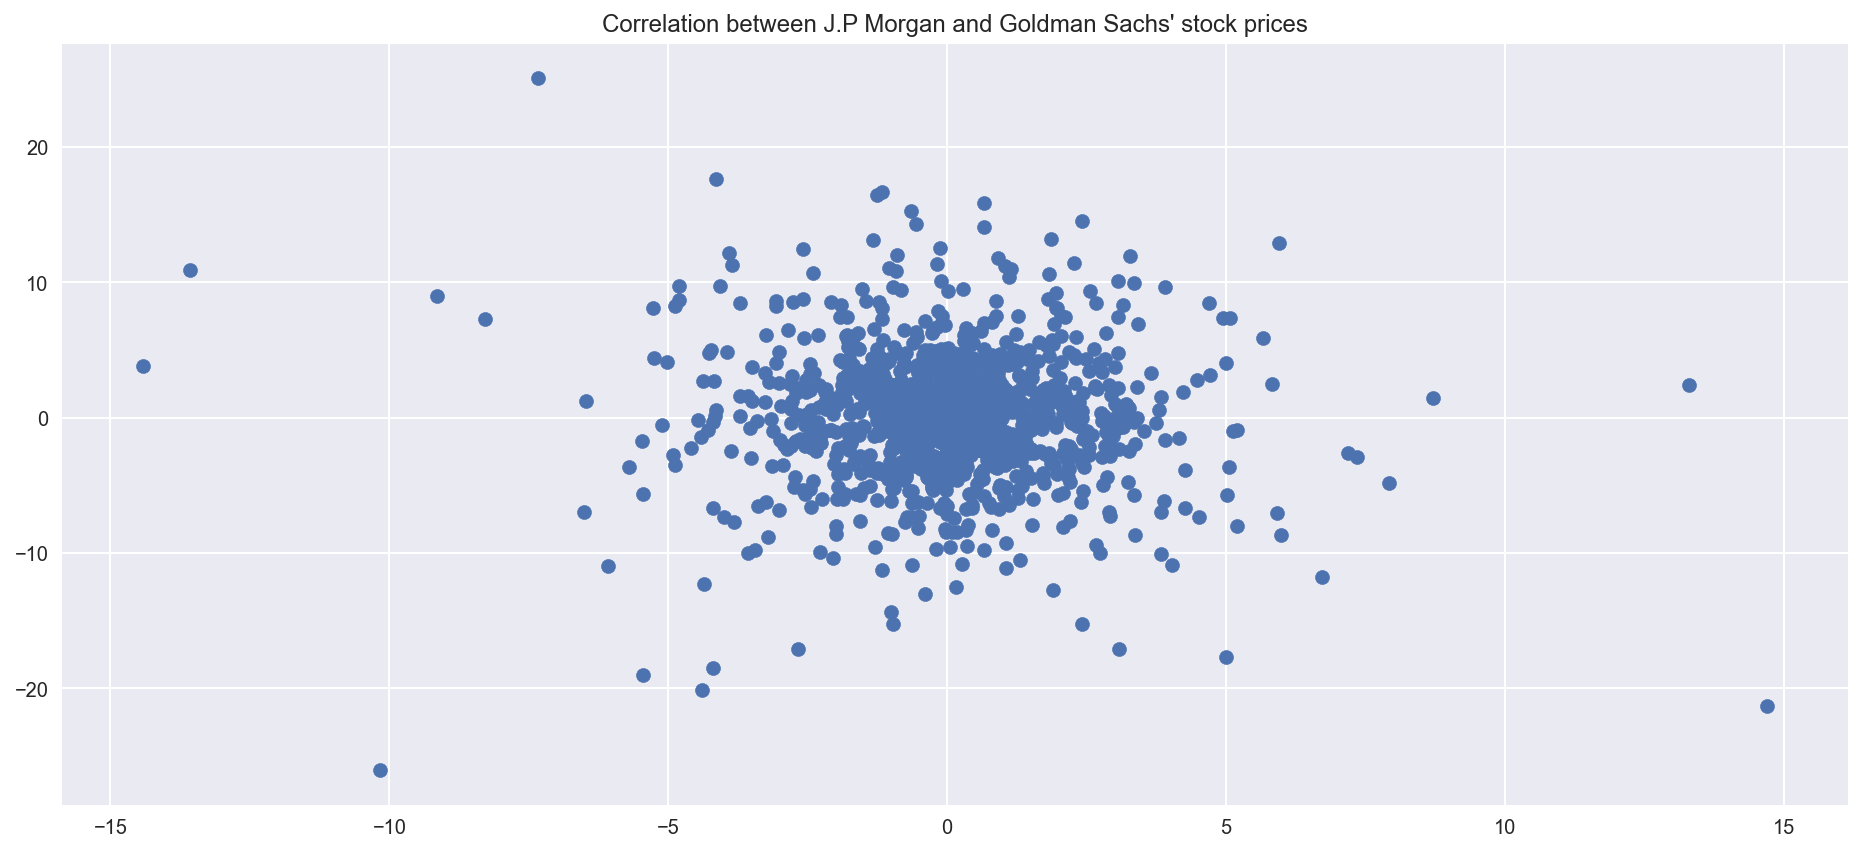

In [24]:
fig, ax = plt.subplots(1,1, figsize = (16,7))
plt.scatter(x = c['J.P Morgan'], y = c['Goldman Sachs'])
plt.title('Correlation between J.P Morgan and Goldman Sachs\' stock prices');


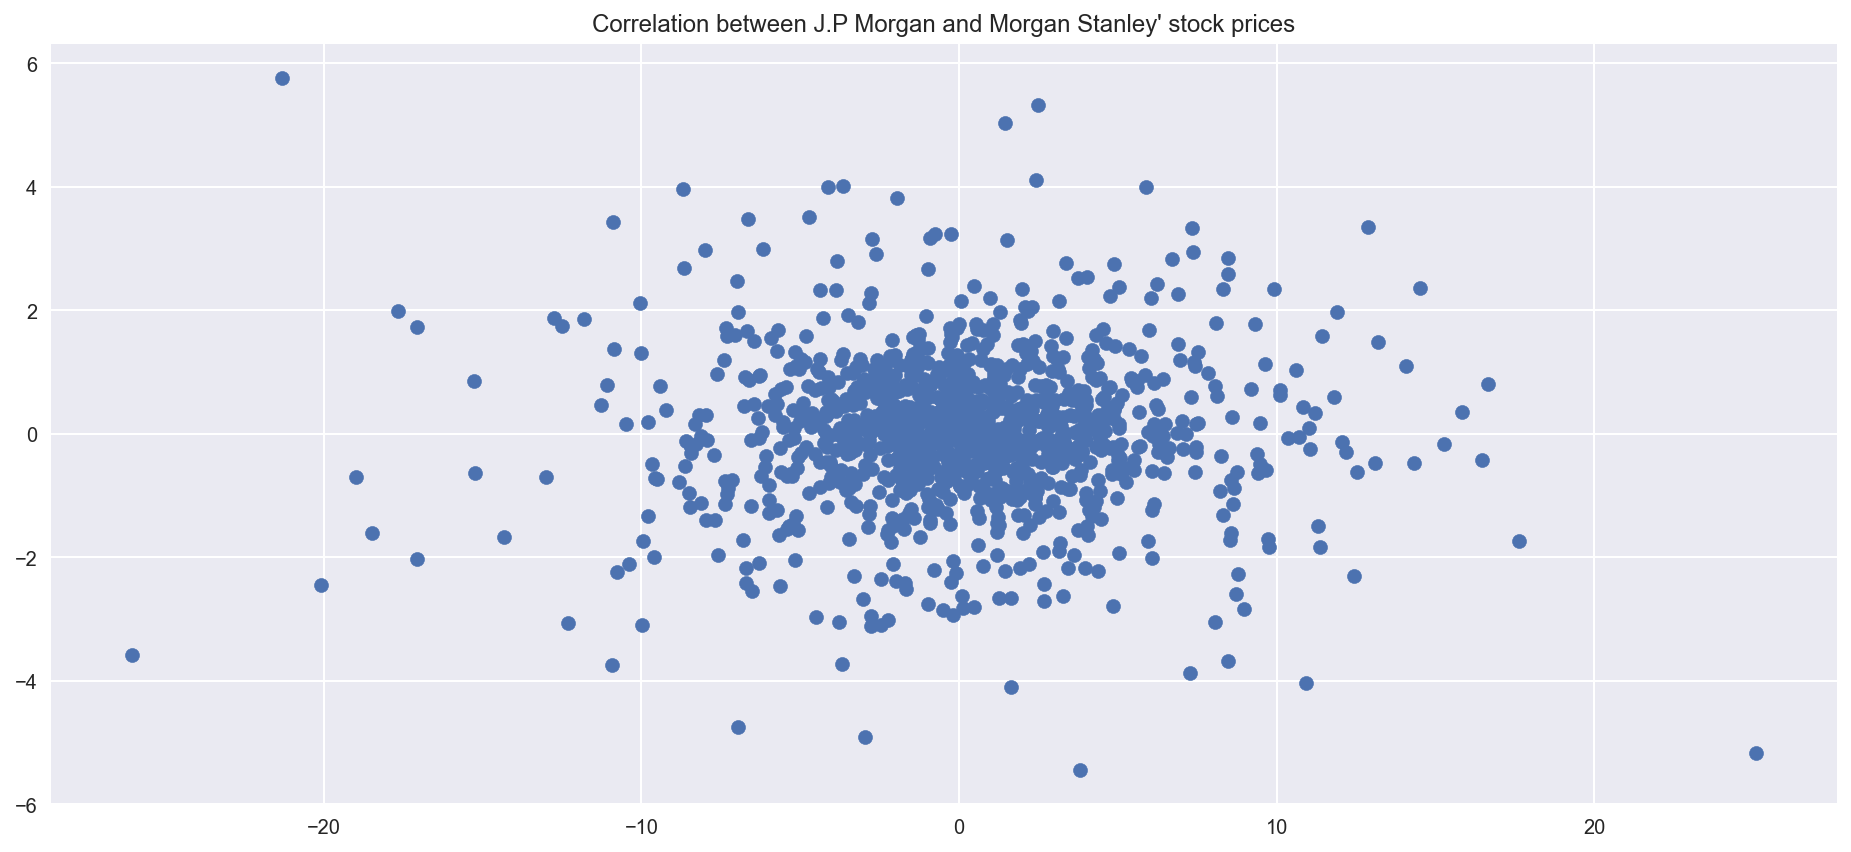

In [25]:
plt.figure(figsize=(16, 7))
plt.scatter(x=c['Goldman Sachs'], y=stocks_adj_close_price['Morgan Stanley'].diff().shift(1))
plt.title('Correlation between J.P Morgan and Morgan Stanley\' stock prices');

The correlation between the stocks disappears as soon as we put in a time lag, indicating that J.P Morgan does not appear to predict Goldman Sachs. There is no correlation betweenJ.P Morgan's price and tomorrow's Goldman Sachs price.

[GO TO TOP](#go-to-top)

# Part II
In this part, I will analyze J.P Morgan's stock price. Visualize raw data, rolling means, standard deviation, and log return and build a candlestick chart with volume traded. I perform exponential smoothing techniques like Simple Exponential Smoothing, Holt's Linear/Damped Smoothing, and Holt-Winter's Exponential Smoothing to predict future stock prices. I also forecast future adjusted stock prices using Moving Average, Autoregressive, and ARIMA models.

<a id='exploration-and-visualisation'></a>

In [26]:
# J.P Morgan's Stock attributes
idx = pd.IndexSlice
jpm_stock_data = stock_data.loc[:, idx[:, 'JPM']].droplevel(1, axis='columns').copy()
jpm_stock_data.head()

Adj Close       Close  Dividends        High         Low  \
Date                                                                   
2018-01-02  94.219803  107.949997       0.00  108.019997  106.809998   
2018-01-03  94.315842  108.059998       0.00  108.489998  107.480003   
2018-01-04  95.666962  109.040001       0.56  110.029999  108.199997   
2018-01-05  95.052803  108.339996       0.00  109.550003  107.779999   
2018-01-08  95.193199  108.500000       0.00  108.680000  107.699997   

                  Open  Stock Splits    Volume  
Date                                            
2018-01-02  107.629997             0  13578800  
2018-01-03  107.860001             0  11901000  
2018-01-04  108.360001             0  12953700  
2018-01-05  109.260002             0  14155000  
2018-01-08  108.150002             0  12466500

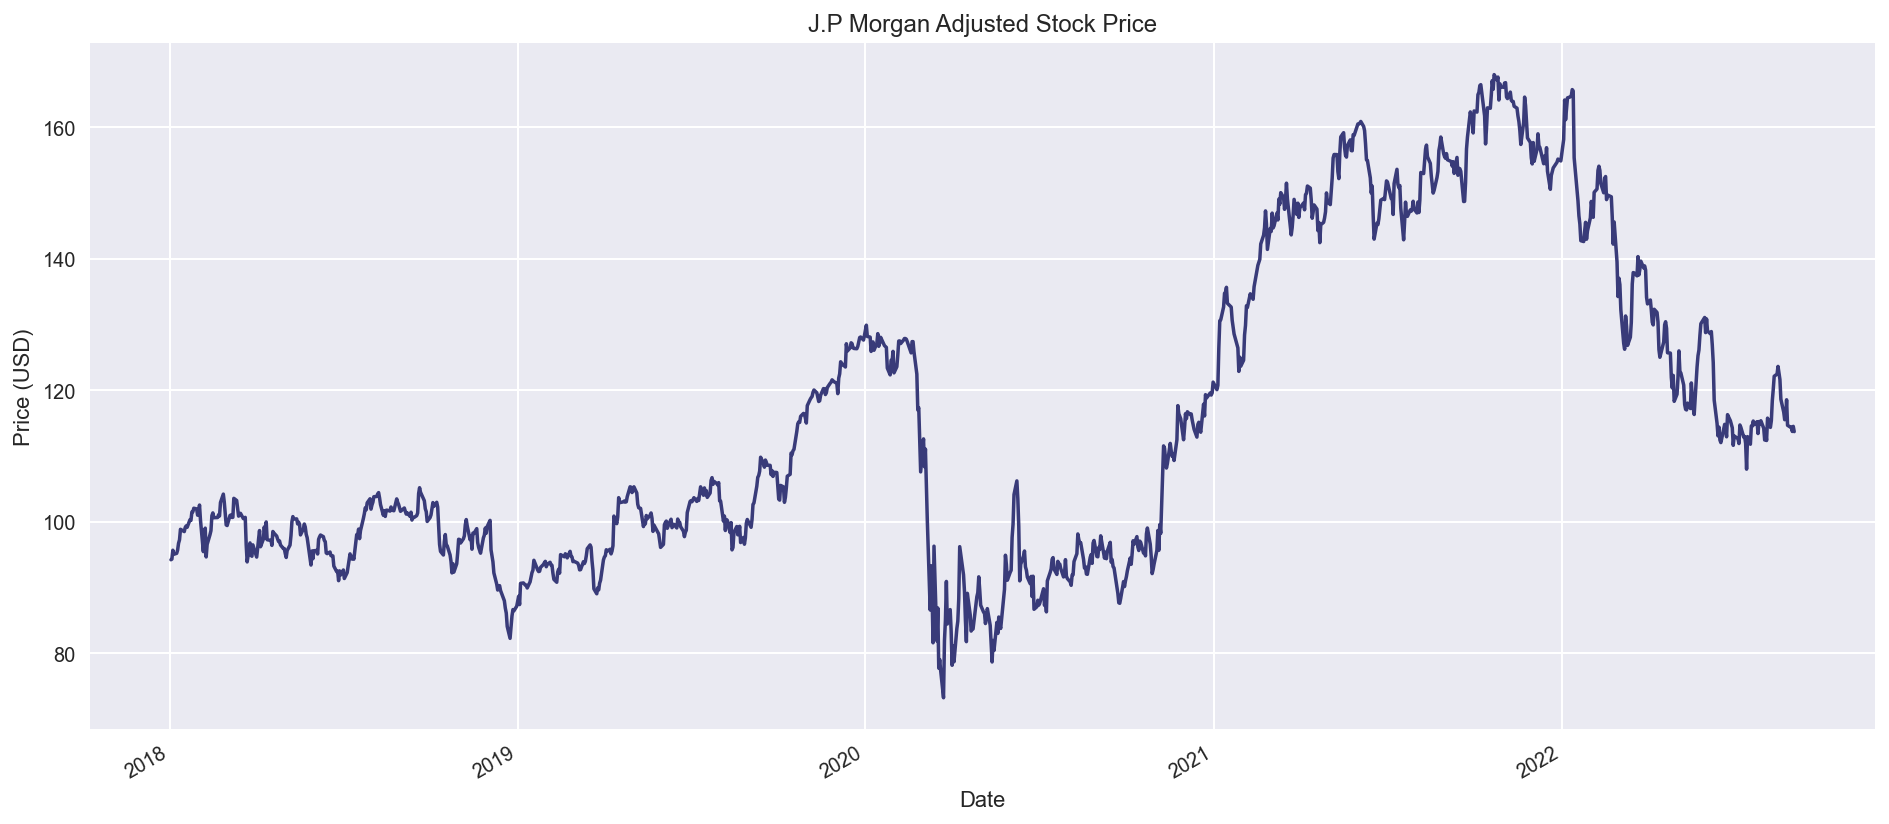

In [27]:
jpm_stock_data['Adj Close'].plot(figsize=(16, 7), title='J.P Morgan Adjusted Stock Price', colormap='tab20b')
plt.ylabel('Price (USD)');

In [28]:
jpm_stock_data.describe().round(2)

Adj Close    Close  Dividends     High      Low     Open  Stock Splits  \
count    1177.00  1177.00    1177.00  1177.00  1177.00  1177.00        1177.0   
mean      115.44   122.90       0.01   124.19   121.67   122.94           0.0   
std        23.80    21.94       0.11    21.99    21.89    21.95           0.0   
min        73.23    79.03       0.00    83.75    76.91    81.56           0.0   
25%        96.34   107.31       0.00   108.40   106.23   107.64           0.0   
50%       105.25   115.18       0.00   116.20   114.37   115.29           0.0   
75%       132.17   138.18       0.00   139.10   137.10   138.02           0.0   
max       168.01   171.78       1.00   172.96   170.54   172.71           0.0   

            Volume  
count      1177.00  
mean   14740951.49  
std     6763592.08  
min     3324300.00  
25%    10332500.00  
50%    13022200.00  
75%    16805600.00  
max    54418800.00

<a id='moving-average'></a>

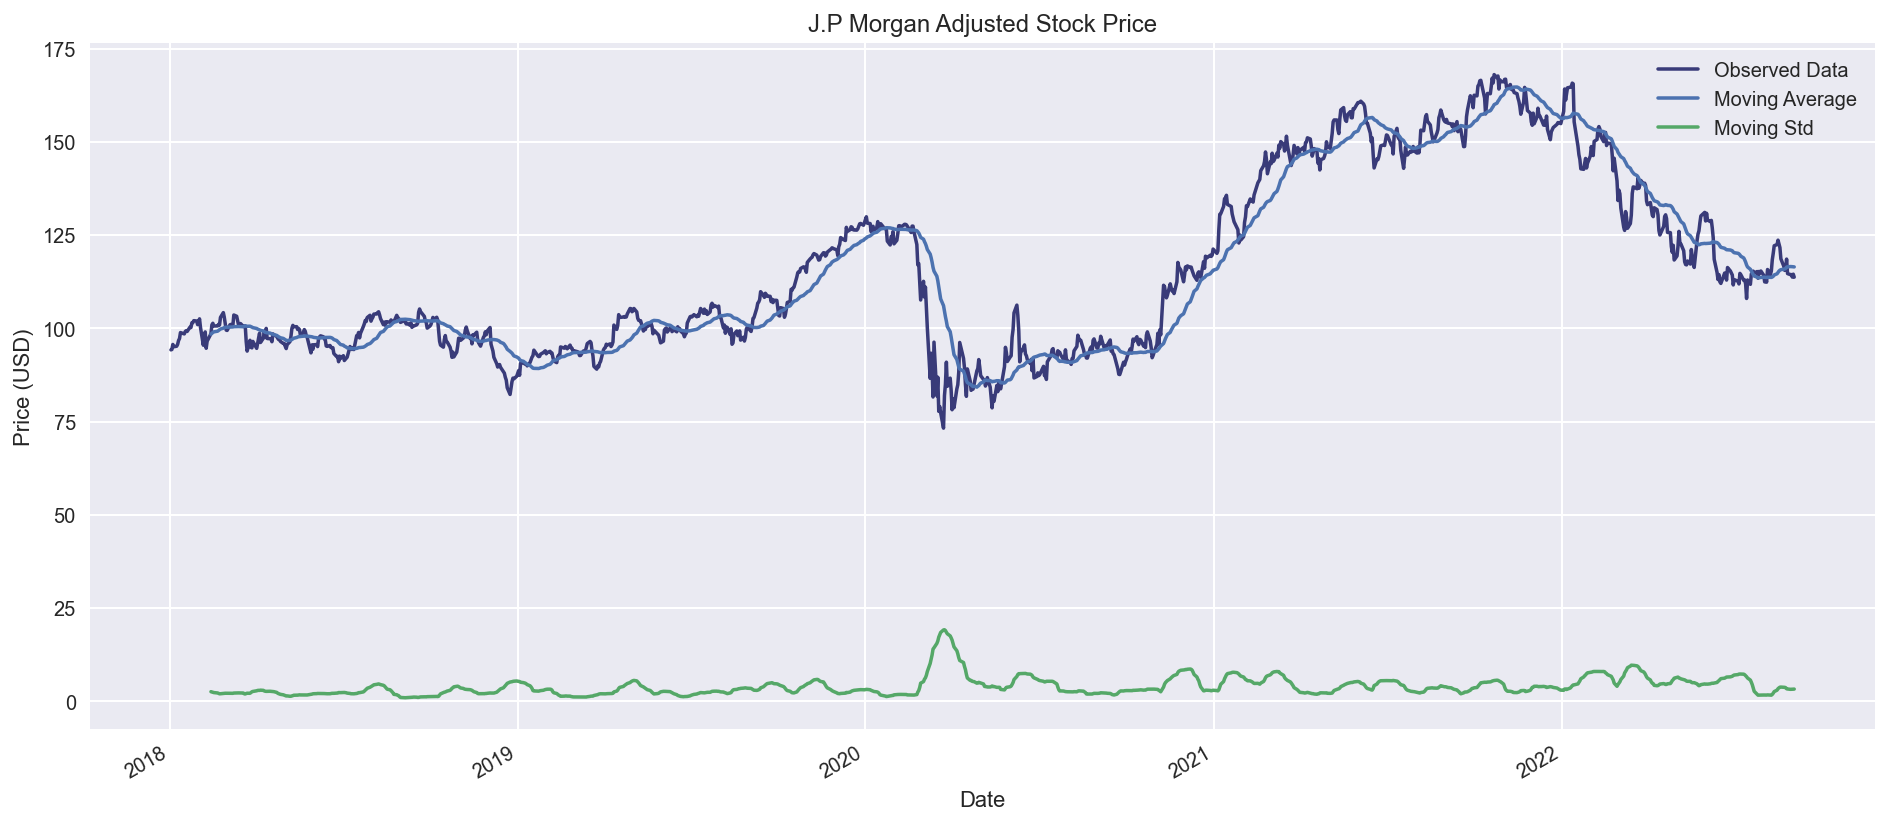

In [29]:
jpm_stock_data['ma_30'] = jpm_stock_data['Adj Close'].rolling(30).mean()
jpm_stock_data['msd_30'] = jpm_stock_data['Adj Close'].rolling(30).std()

jpm_stock_data['Adj Close'].plot(figsize=(16, 7), label='Observed Data', 
                                 legend=True, title='J.P Morgan Adjusted Stock Price',
                                 colormap='tab20b')
jpm_stock_data['ma_30'].plot(label='Moving Average', legend=True)
jpm_stock_data['msd_30'].plot(label='Moving Std', legend=True)
plt.ylabel('Price (USD)');

[GO TO TOP](#go-to-top)

<a id='returns-jpm'></a>

In [30]:
jpm_stock_data['Log returns'] = (np.log(jpm_stock_data['Adj Close'])
                                 - np.log(jpm_stock_data['Adj Close'].shift(1)))
jpm_stock_data['Simple returns'] = jpm_stock_data['Adj Close'].pct_change()

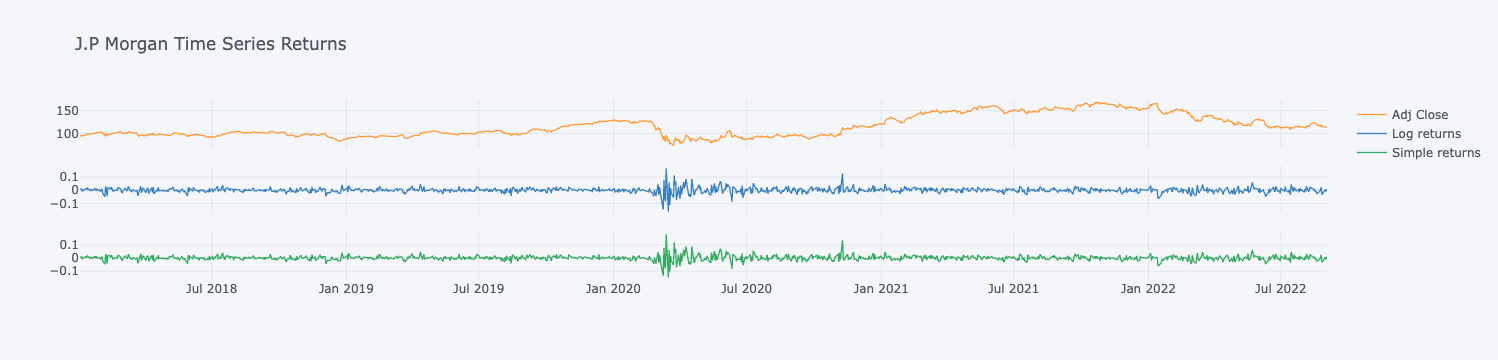

In [31]:
jpm_stock_data[['Adj Close', 'Log returns', 'Simple returns']].iplot(
    subplots=True, shape=(3, 1),
    shared_xaxes=True, title='J.P Morgan Time Series Returns')

Skew: -0.075
Mean: 0.0002
Median: -0.0
Standard deviation of returns
0.02


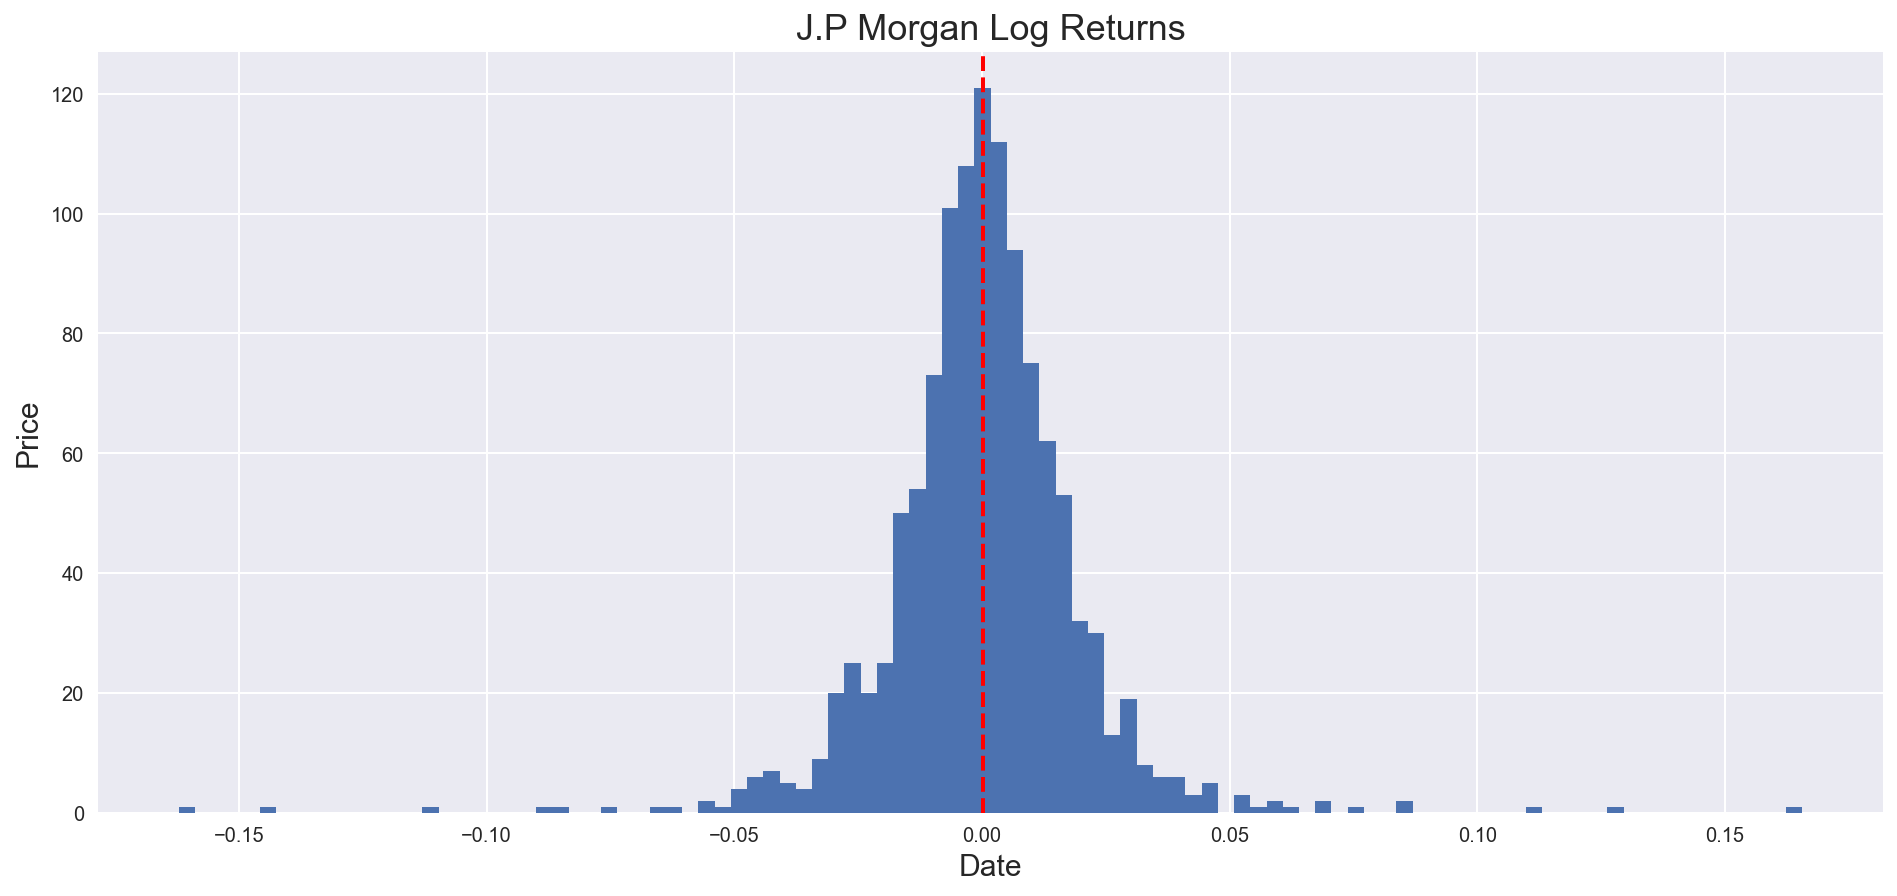

In [32]:
# Histogram of Daily Returns
print('Skew:', round(stats.skew(jpm_stock_data['Log returns'].dropna()), 3))
print('Mean:', round(np.mean(jpm_stock_data['Log returns']), 4))
print('Median:', round(np.median(jpm_stock_data['Log returns'].dropna()), 3))
print('Standard deviation of returns')
print(round(jpm_stock_data['Log returns'].std(), 3))

plt.figure(figsize=(16, 7))
plt.hist(jpm_stock_data['Log returns'], bins=100, label='Daily Returns data')
plt.axvline(jpm_stock_data['Log returns'].mean(), color='r', linestyle='dashed', linewidth=2) 
plt.title('J.P Morgan Log Returns', fontsize=18)
plt.xlabel('Date', fontsize=15)
plt.ylabel('Price', fontsize=15)
plt.show()

[GO TO TOP](#go-to-top)

<a id='stock-attributes'></a>

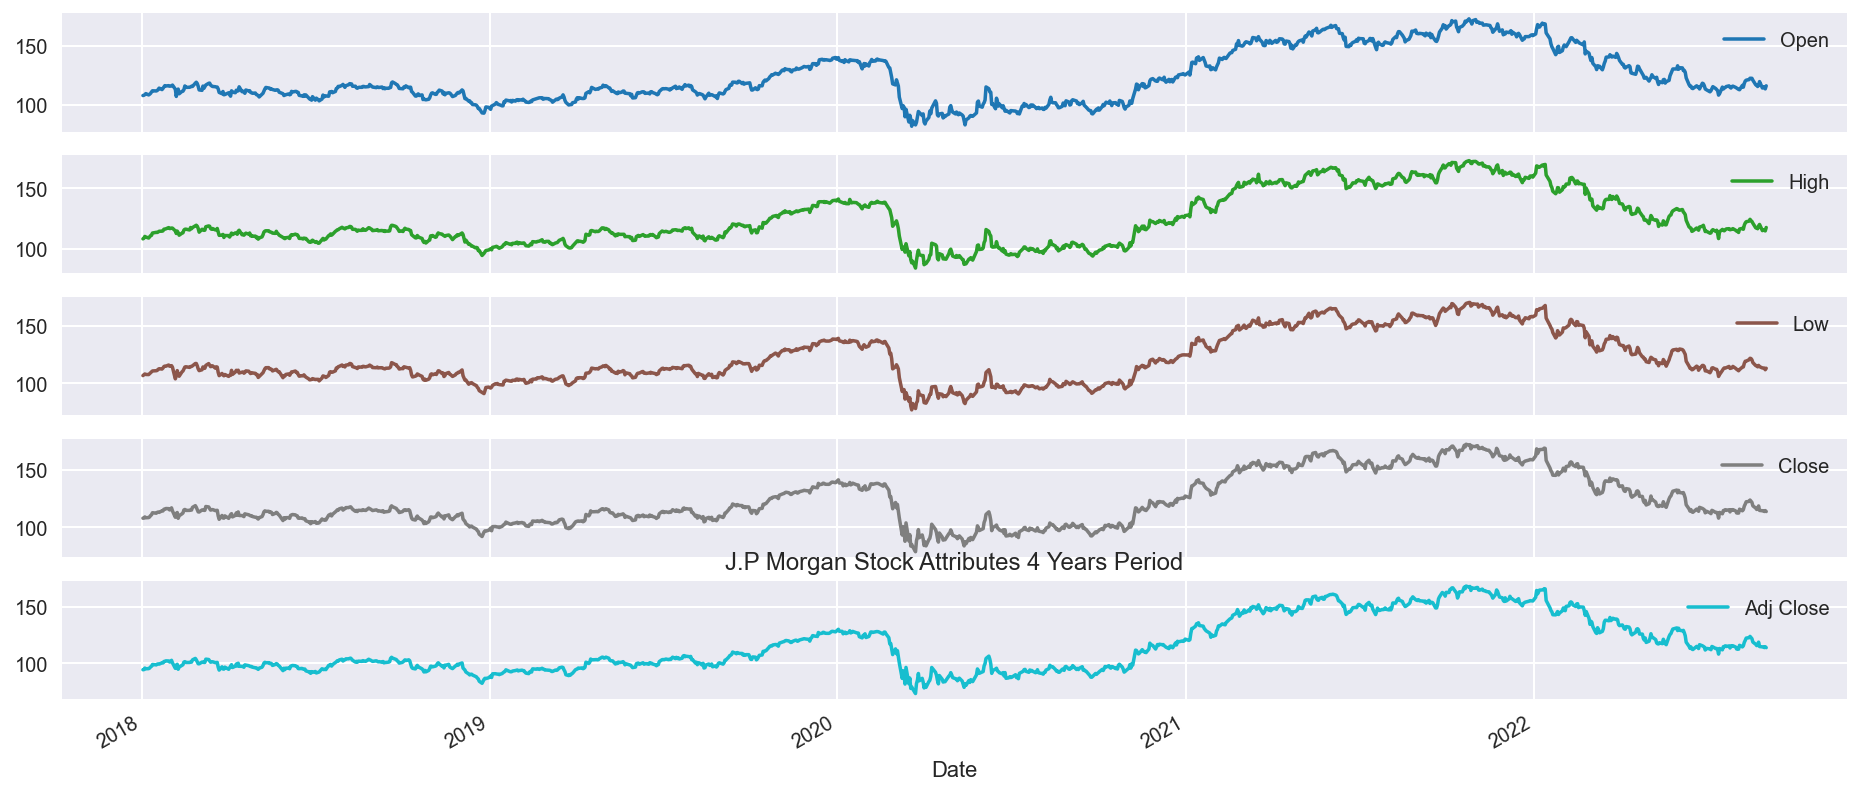

In [33]:
jpm_stock_data[['Open', 'High', 'Low', 'Close', 'Adj Close']].plot(
    figsize=(16, 7), subplots=True, 
    colormap='tab10')
plt.title('J.P Morgan Stock Attributes 4 Years Period') 
plt.show()

[GO TO TOP](#go-to-top)

<a id='candlestick'></a>

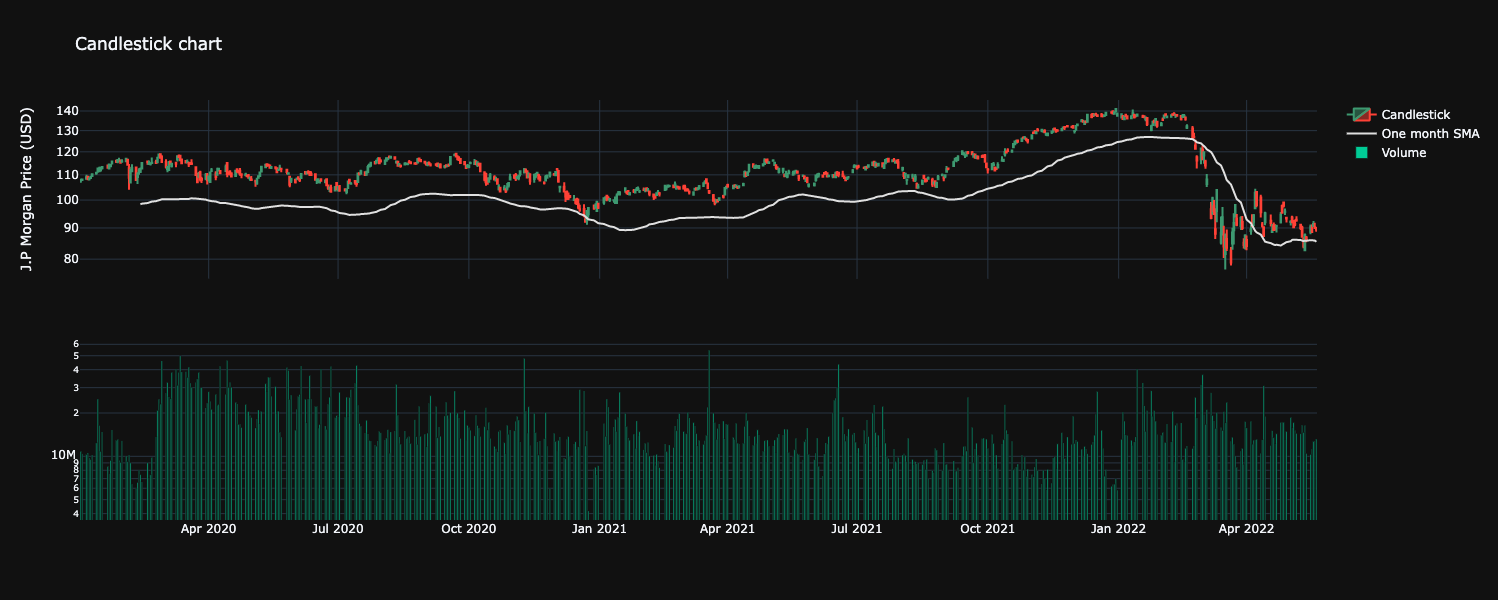

In [34]:
fig = make_subplots(rows=2, cols=1, shared_xaxes=True)

fig.add_trace(
    go.Candlestick(
        x=jpm_stock_data.loc['2020-01-01':'2022-05-20'].index,
        open=jpm_stock_data['Open'],
        high=jpm_stock_data['High'],
        low=jpm_stock_data['Low'],
        close=jpm_stock_data['Close'],
        name='Candlestick'),
    row=1, col=1)

fig.add_trace(
    go.Scatter(
        x=jpm_stock_data.loc['2020-01-01':'2022-05-20'].index, 
        y=jpm_stock_data['ma_30'],
        line=dict(color = '#e0e0e0'),
        name='One month SMA'))

fig.add_trace(
    go.Bar(
        x=jpm_stock_data.loc['2020-01-01':'2022-05-20'].index,
        y=jpm_stock_data.loc['2020-01-01':'2022-05-20', 'Volume'],
        name = 'Volume'),
    secondary_y=False,
    row=2, col=1)


fig.update_layout(
    title_text='Candlestick chart', xaxis_rangeslider_visible=False,
    template='plotly_dark', yaxis_title='J.P Morgan Price (USD)',
    width=1000, height=600)

fig.update_yaxes(type='log')
fig.show()

After taking the first difference, it is quite obvious that the series fluctuates around its mean and it is referred to as weakly stationary.

[GO TO TOP](#go-to-top)

<a id='exponential-smoothing'></a>

## Exponencial Smoothing
Smoothing is a statistical method we can use to create an approximation function to remove irregularities in data and attempt to capture significant patterns.
The smoothing technique is a family of time-series forecasting algorithms, which utilizes the weighted averages of a previous observation to predict or forecast a new value. The main idea of this technique is to overweight recent values in a time series.

I will perform univariate analysis on the adjusted close price of the stock and forecasting using Simple Exponential Smoothing, Holt's Exponential Smoothing, and Holt - Winter Exponential Smoothing.

In [35]:
# To perform exponential smoothing I am going to take weekly data
jpm_week_data = jpm_stock_data['Adj Close'].copy().resample('W').mean().to_frame()

train_data_es = jpm_week_data.iloc[:int(jpm_week_data.shape[0] * 0.90)]
test_data_es = jpm_week_data.iloc[int(jpm_week_data.shape[0] * 0.90):]
train_data_es.rename(columns={'Adj Close': 'Train data'}, inplace=True)
test_data_es.rename(columns={'Adj Close': 'Test data'}, inplace=True)

print('Total:', jpm_week_data.shape[0])
print('Train data size:', train_data_es.shape[0])
print('Test data size:', test_data_es.shape[0])

Total: 244
Train data size: 219
Test data size: 25


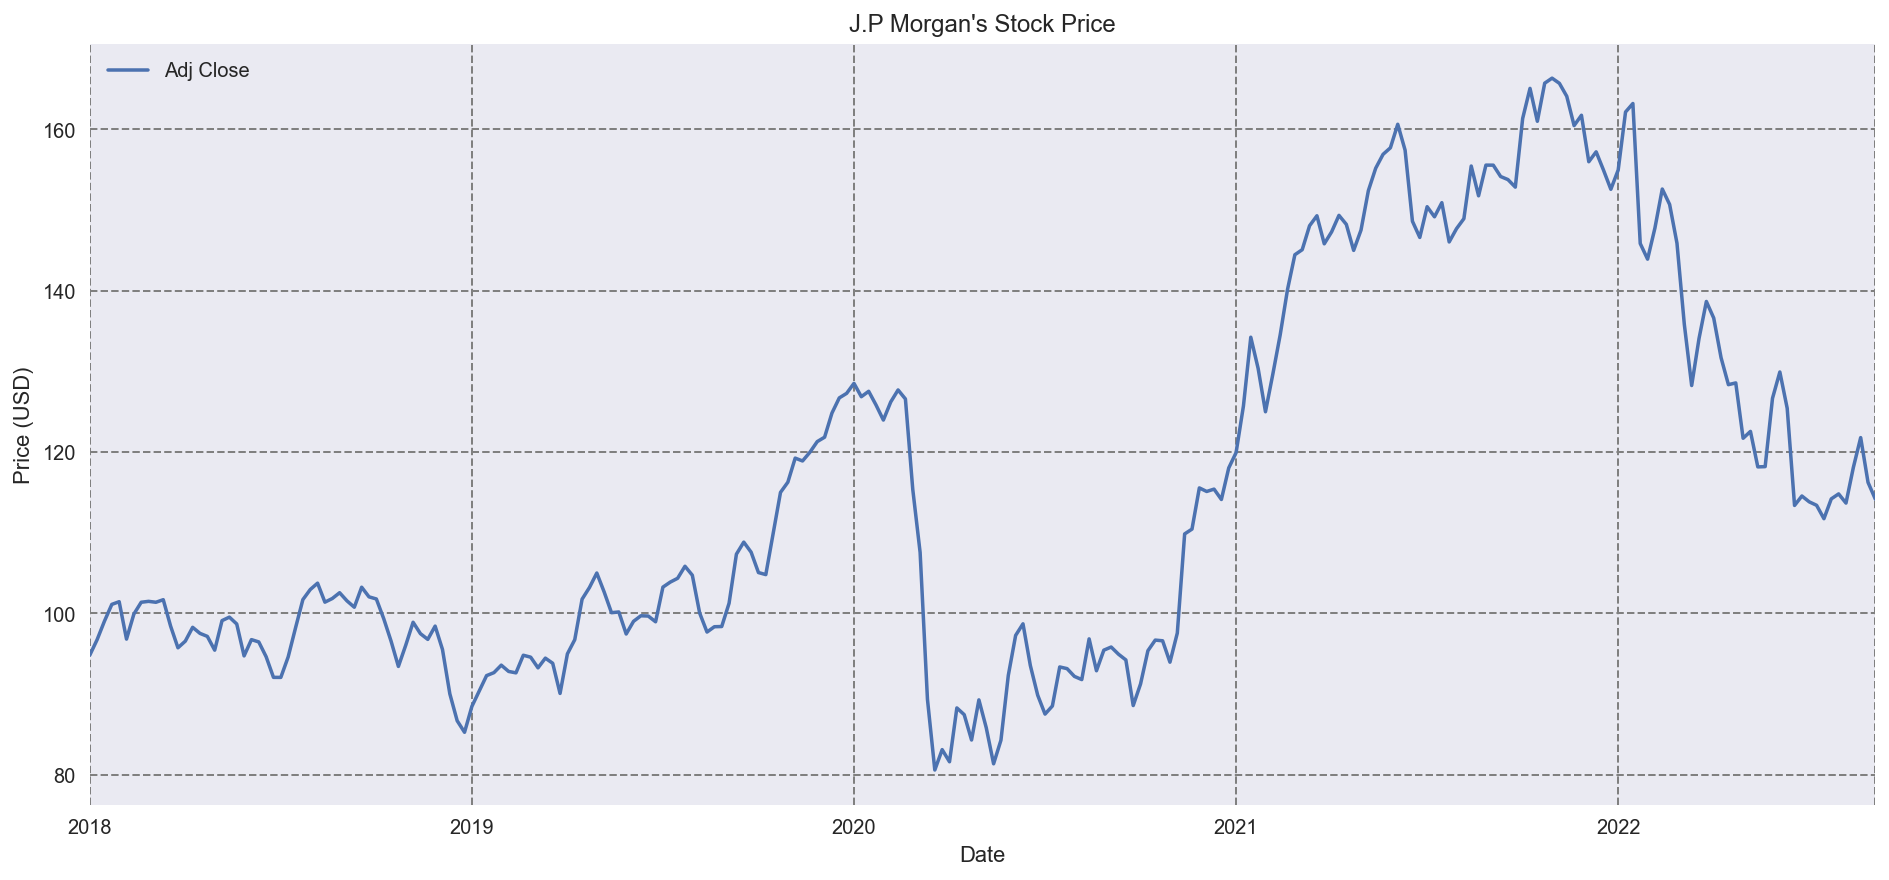

In [36]:
jpm_week_data.plot(title="J.P Morgan's Stock Price", figsize=(16, 7));
plt.ylabel('Price (USD)')
plt.legend(loc='upper left')
plt.grid(linestyle='--', c='grey');

<a id='seasonal-decomposition'></a>

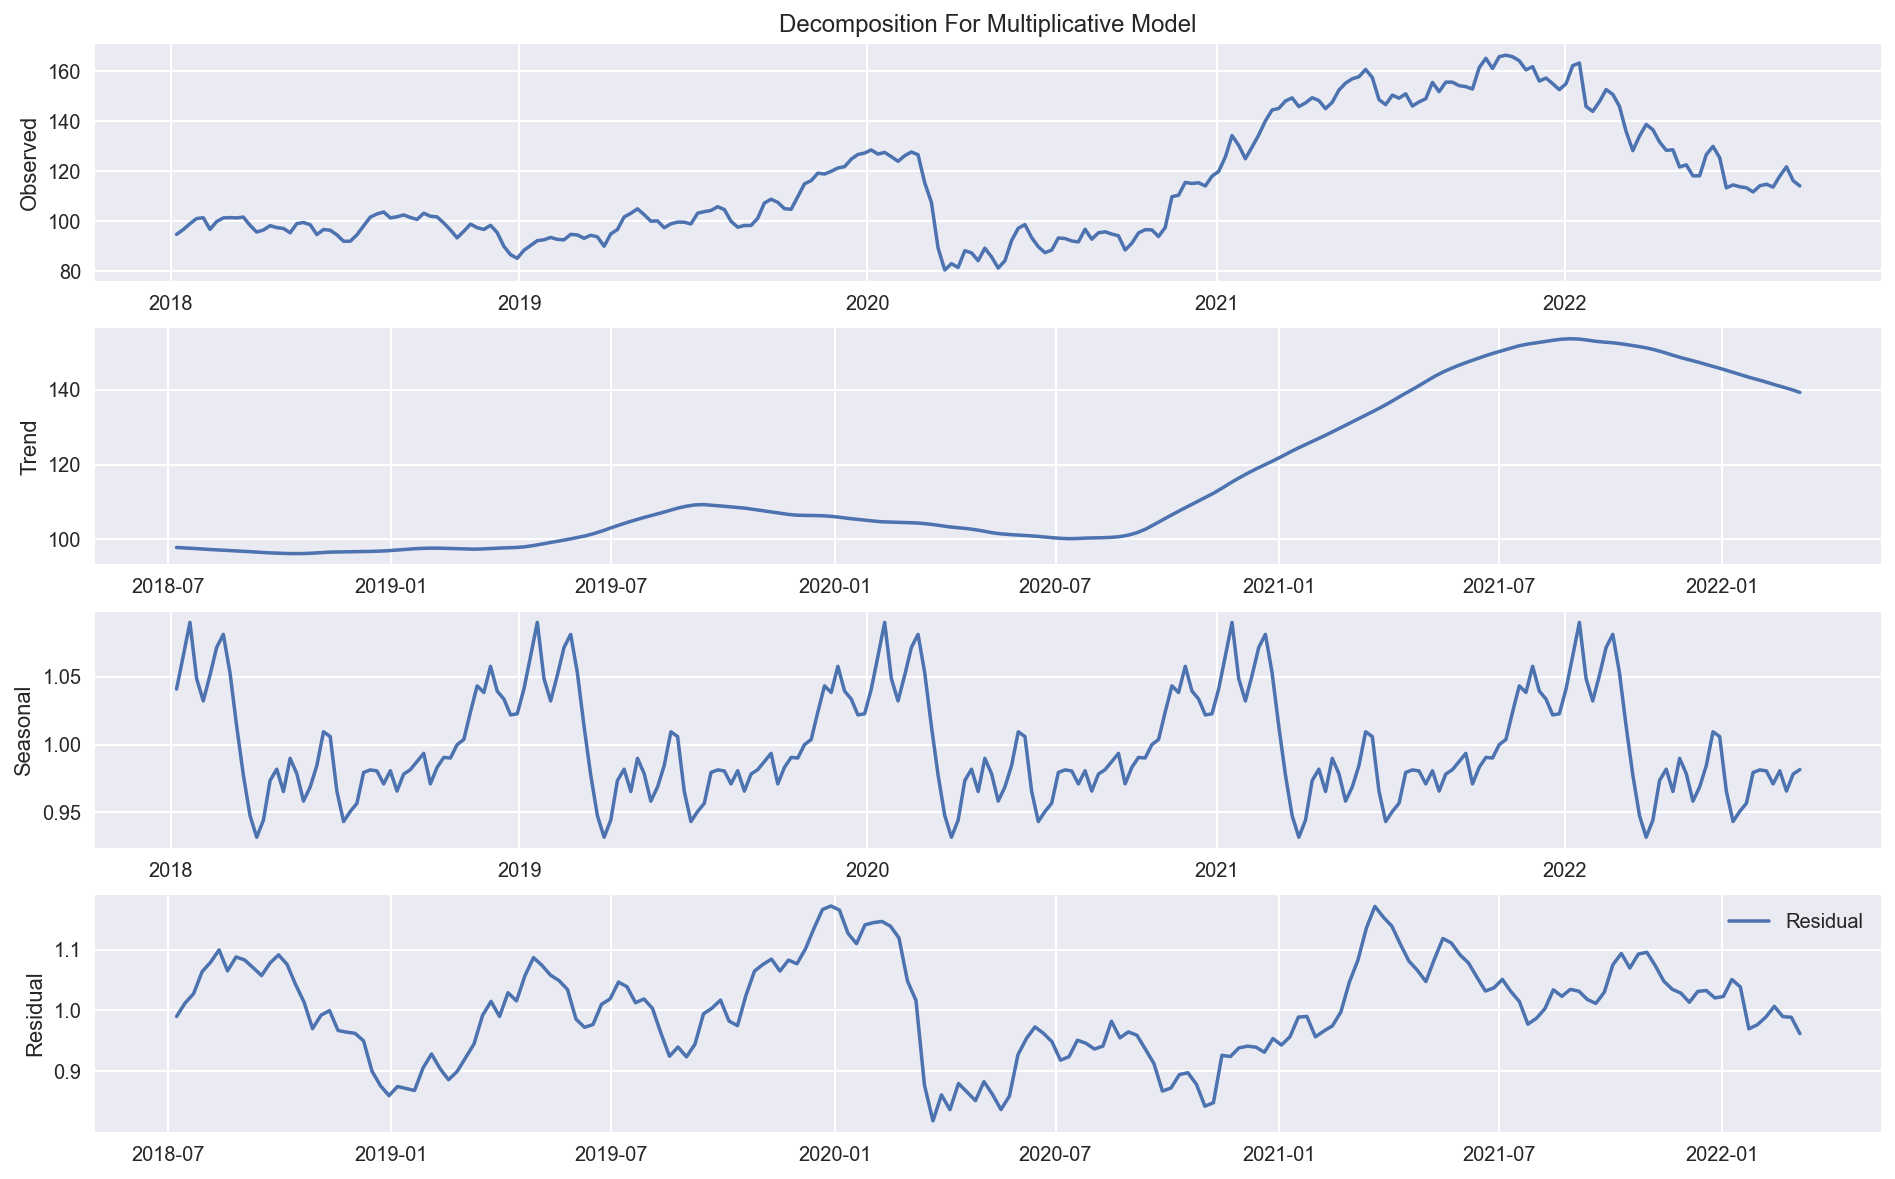

In [37]:
decomposed_weekly_data = sm.tsa.seasonal_decompose(jpm_week_data, model='multiplicative')

fig, ax = plt.subplots(4, 1, figsize=(16, 10))
ax[0].plot(decomposed_weekly_data.observed)
ax[0].set_ylabel('Observed')
ax[0].set_title('Decomposition For Multiplicative Model')

ax[1].plot(decomposed_weekly_data.trend)
ax[1].set_ylabel('Trend')

ax[2].plot(decomposed_weekly_data.seasonal, label='Seasonal')
ax[2].set_ylabel('Seasonal')

ax[3].plot(decomposed_weekly_data.resid, label='Residual')
ax[3].set_ylabel('Residual')

plt.legend()
plt.show()

I will create a function that has all the required evaluation metrics, which will give us the results in one go. This function helps us understand how far off our forecasts are against the actuals.

[GO TO TOP](#go-to-top)

<a id='simple-exp-smoothing'></a>

### Simple Exponential Smoothing

In [38]:
def timeseries_evaluation_metrics_func(y_true, y_pred):
    def mean_absolute_percentage_error(y_true, y_pred):
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
        # Evaluation metric results
        MSE = metrics.mean_squared_error(y_true, y_pred)
        MAE = metrics.mean_absolute_error(y_true, y_pred)
        RMSE = np.sqrt(metrics.mean_squared_error(y_true, y_pred))
        MAPE = mean_absolute_percentage_error(y_true, y_pred)
        R2 = metrics.r2_score(y_true, y_pred)

In [39]:
resu = []
temp_df = pd.DataFrame()
for i in [
    0.00, 0.10, 0.20,
    0.30, 0.40, 0.50, 
    0.60, 0.70, 0.80,
    0.90, 1
]:
    fit_v = SimpleExpSmoothing(np.asarray(train_data_es)).fit(i)
    fcst_pred_v = fit_v.forecast(len(test_data_es))
    timeseries_evaluation_metrics_func(test_data_es, fcst_pred_v)
    rmse = np.sqrt(mean_squared_error(test_data_es, fcst_pred_v))
    df3 = {'smoothing parameter': i, 'RMSE': rmse}
    temp_df = temp_df.append(df3, ignore_index=True)
temp_df.sort_values(by=['RMSE']).head(3)

smoothing parameter       RMSE
10                  1.0  10.399615
0                   0.0  10.569797
9                   0.9  10.970319

From the previous search, the least RMSE was achieved with smoothing_level equal to 1.0. But we need to be aware since choosing smoothing parameter with least RMSE can lead us to overfitting, this is why I will apply  	$\alpha$ = 0.2, since it is used more frequently.

In [40]:
# When alpha is high the dacay is faster and we give less weight to past data and viceversa
ses_1 = SimpleExpSmoothing(train_data_es).fit(smoothing_level=0.2)
ses_1_forecast = ses_1.forecast(len(test_data_es))

# Here we allow statsmodels to automatically find an optimized value aplha
ses_3 = SimpleExpSmoothing(train_data_es).fit()
alpha = ses_3.model.params['smoothing_level']
ses_3_forecast = ses_3.forecast(len(test_data_es))

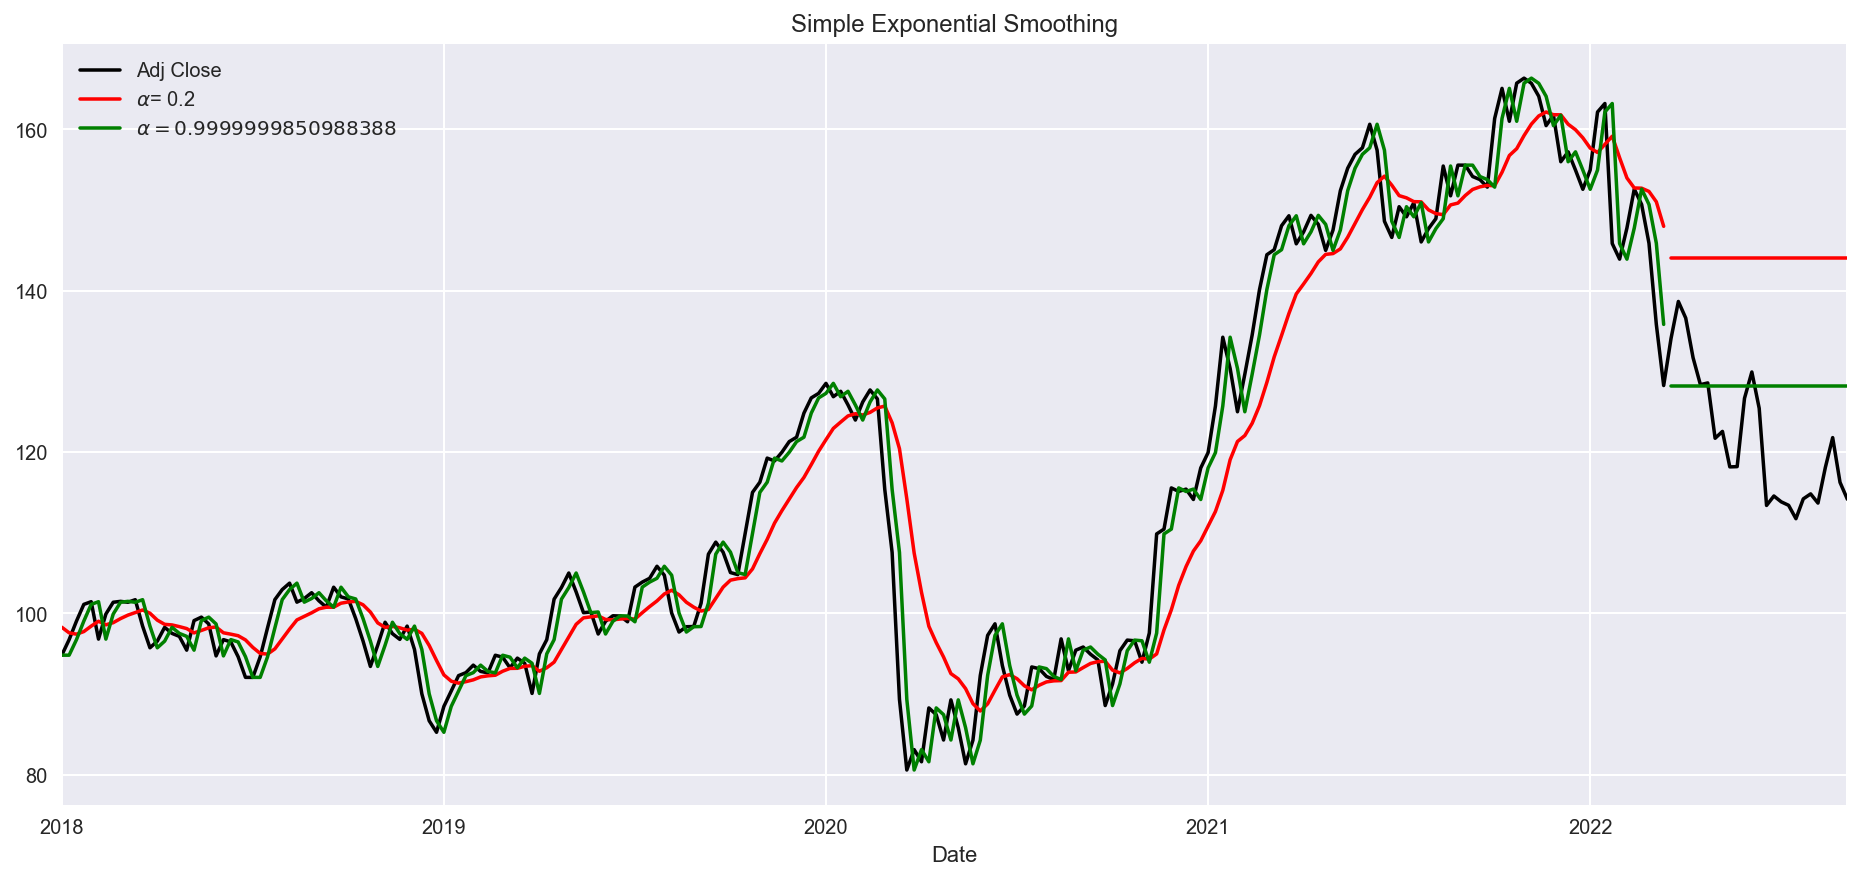

In [41]:
jpm_week_data.plot(color='k', title='Simple Exponential Smoothing',
                   legend=True, figsize=(16,7))

ses_1_forecast.plot(label=r'$\alpha$= 0.2', color='r', legend=True)
ses_1.fittedvalues.plot(color='r')
ses_3_forecast.plot(label=r'$\alpha ={} $'.format(alpha), color='green', legend=True)
ses_3.fittedvalues.plot(color='green')
plt.show()

In [42]:
rmse_simple_smoothing_alpa_0_2 = np.sqrt(mean_squared_error(test_data_es, ses_1_forecast))
rmse_smpl_smth_alpha_0_99 = np.sqrt(mean_squared_error(test_data_es, ses_3_forecast))

We can see that the simple exponential smoothing is not performing well on the stock market data, since they have trends and seasonality. Our basic model will not be able to capture these details.

[GO TO TOP](#go-to-top)

<a id='double-exp-smoothing'></a>

### Double Exponential Smoothing / Holt's Esponential Smoothing

Holt's exponential smoothing is an extension of Simple Exponencial Smoothing, and integrate trend term. The time series must have following features - Level, Trend, Noise (unpredictable), No Seasonality. In the model we can two updating equations:
* The Level updating equation with $\alpha$- smoothing parameter
* The Trend updating equation with $\beta$ - smoothing slope

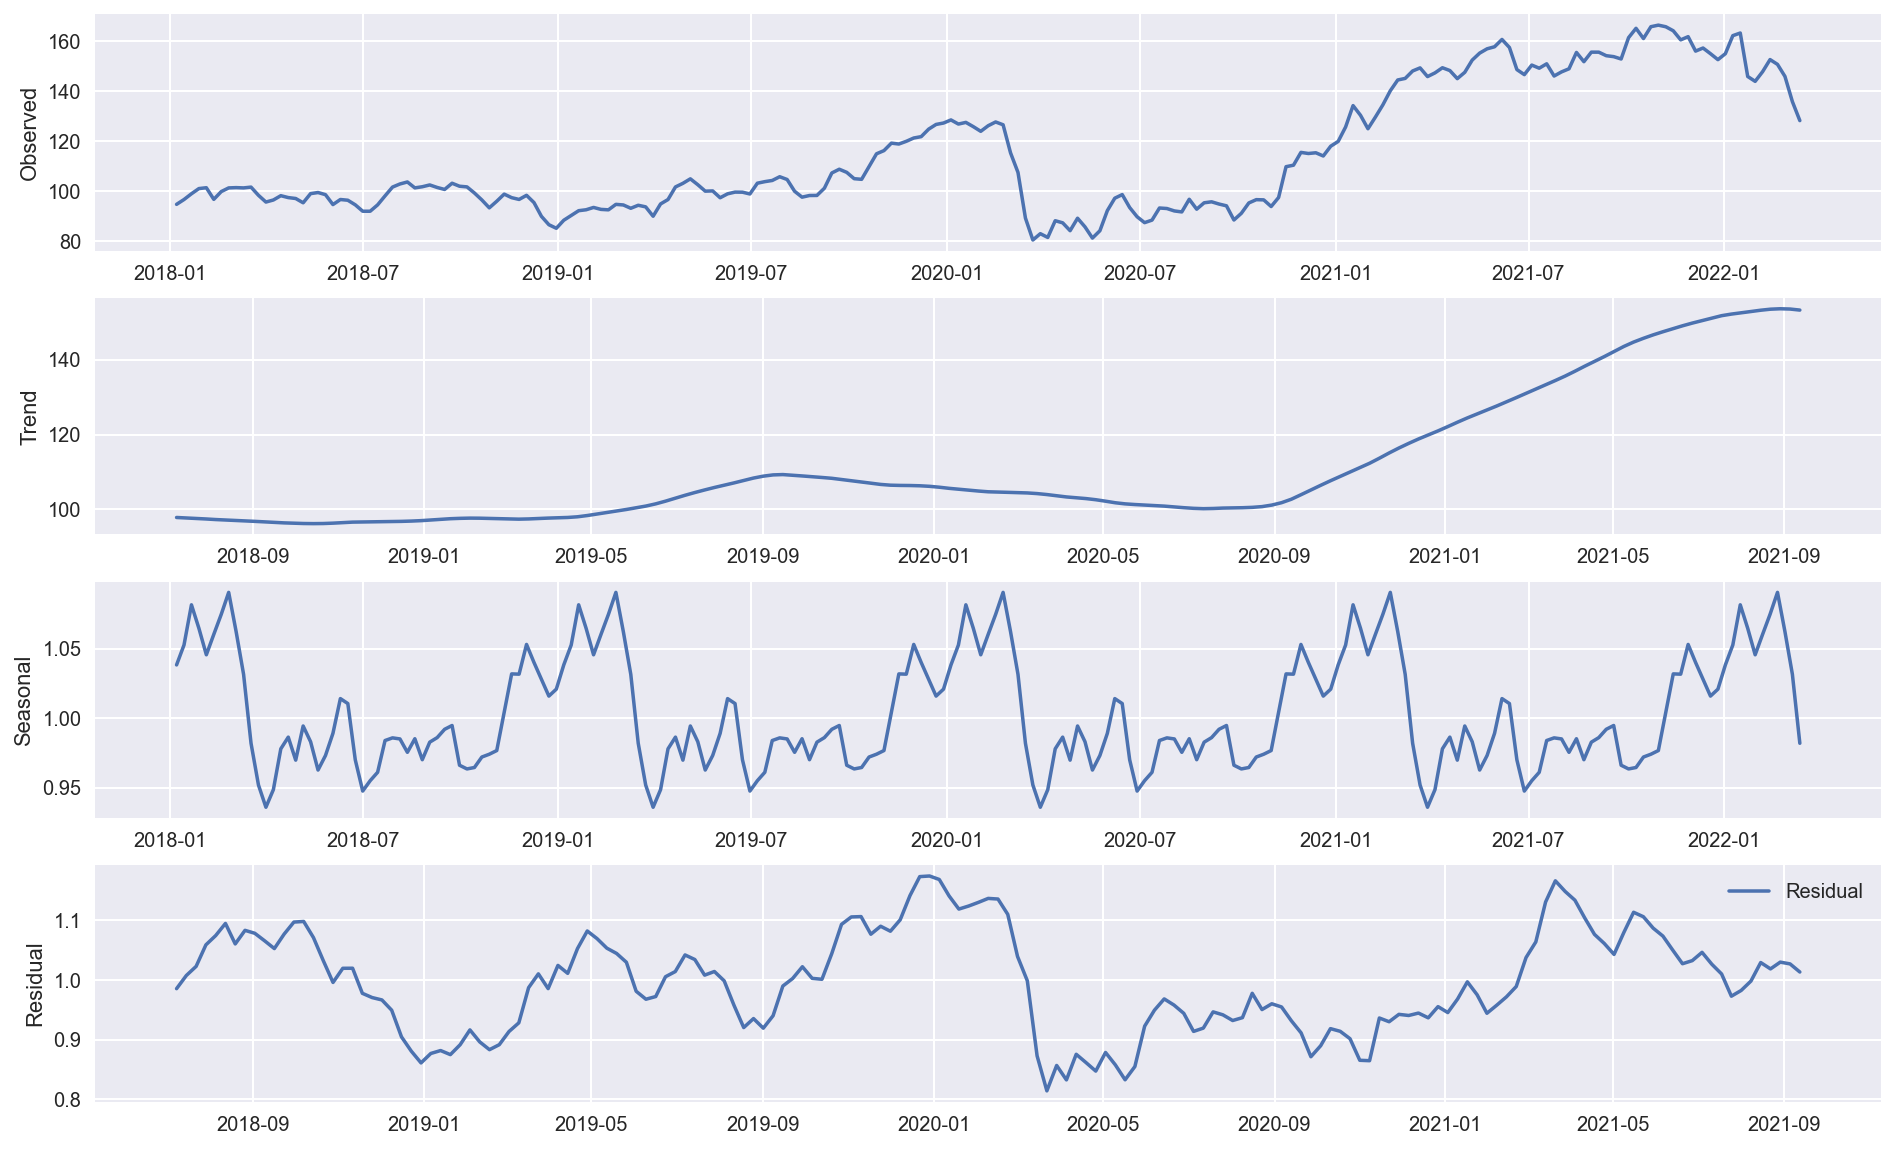

In [43]:
# Decompose train data and plot it
decomposed_jpm_price = seasonal_decompose(train_data_es, model='mul', period=52)
fig, ax = plt.subplots(4, 1, figsize=(16, 10))
ax[0].plot(decomposed_jpm_price.observed)
ax[0].set_ylabel('Observed')
ax[1].plot(decomposed_jpm_price.trend)
ax[1].set_ylabel('Trend')
ax[2].plot(decomposed_jpm_price.seasonal, label='Seasonal')
ax[2].set_ylabel('Seasonal')
ax[3].plot(decomposed_jpm_price.resid, label='Residual')
ax[3].set_ylabel('Residual')
plt.legend()
plt.show()

We could observe that the data has a polynomial trend and additive seasonality. 

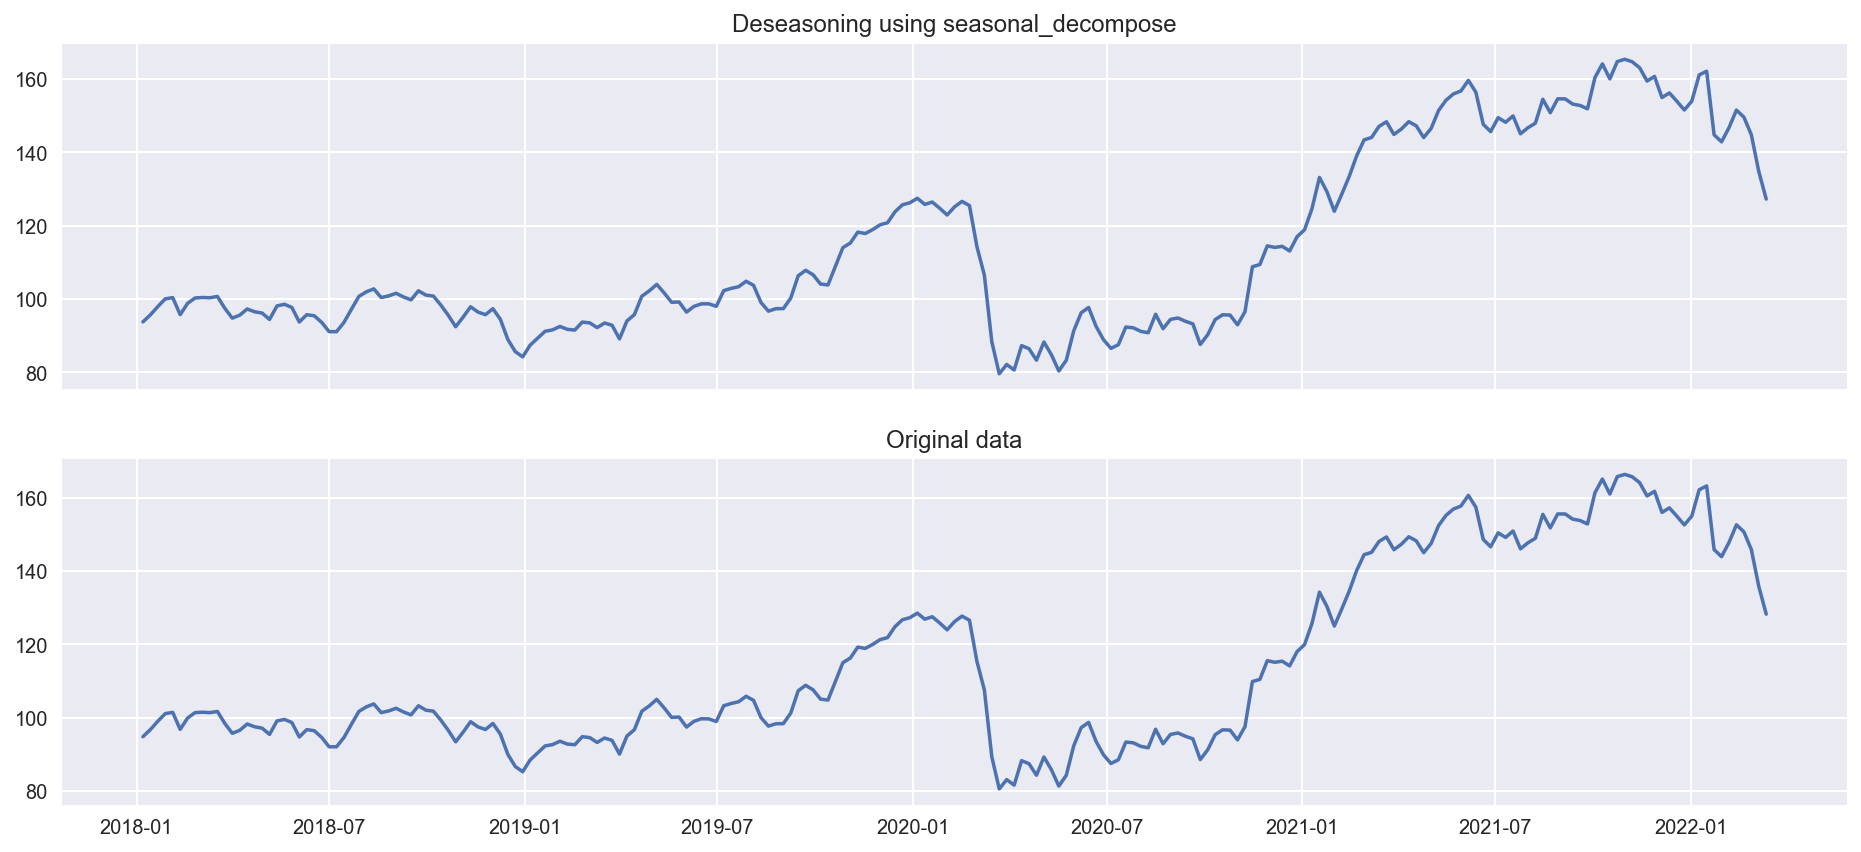

In [44]:
deseason_data = train_data_es['Train data'] - decomposed_jpm_price.seasonal
deseason_data.dropna(inplace=True)

fig, ax = plt.subplots(2, 1, sharex=True, figsize=(16, 7))
ax[0].plot(deseason_data)
ax[0].set_title('Deseasoning using seasonal_decompose')
ax[1].plot(train_data_es)
ax[1].set_title('Original data');

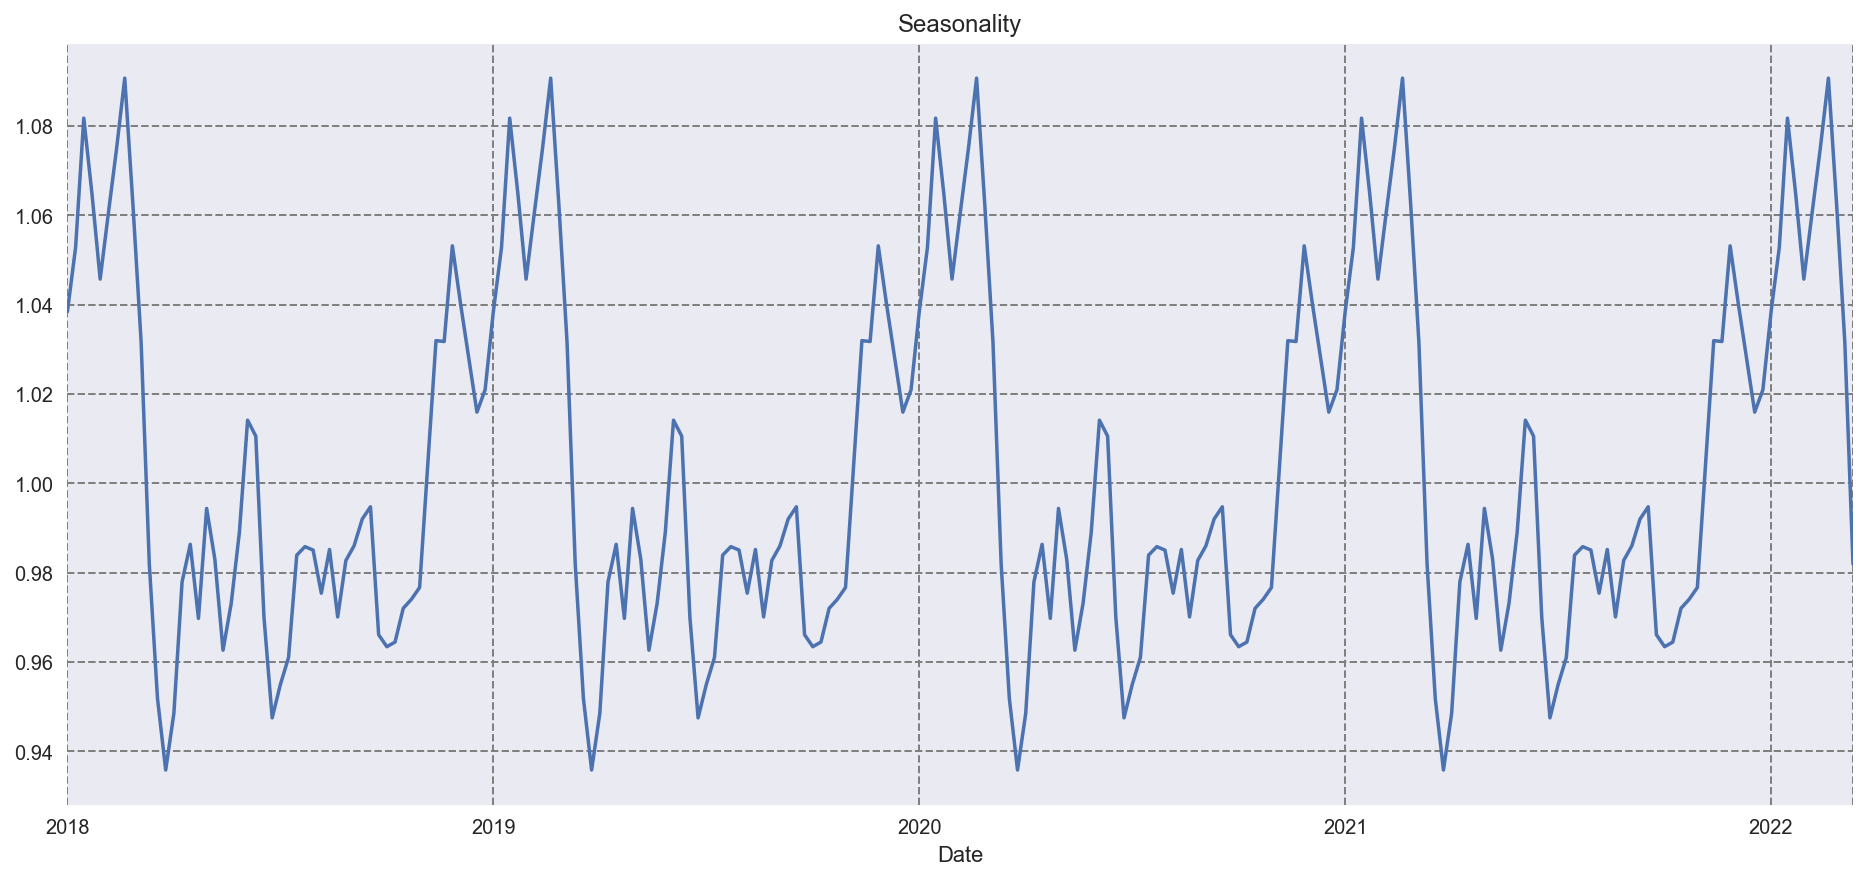

In [45]:
seasonality = decomposed_jpm_price.seasonal
seasonality.plot(title='Seasonality', figsize=(16, 7))
plt.grid(linestyle='--', c='grey');

In the seasonality graph, we can see the seasonality structure for every year, which is cyclic and repeatedly provides the same values.

In [46]:
model_1 = ExponentialSmoothing(
    deseason_data, trend='mul',
    seasonal=None
).fit(smoothing_level=0.2)

model_2 = ExponentialSmoothing(
    deseason_data, trend='mul',
    seasonal=None, damped=True
).fit(smoothing_level=0.2)
yhat_1 = model_1.forecast(len(test_data_es))
yhat_2 = model_2.forecast(len(test_data_es))

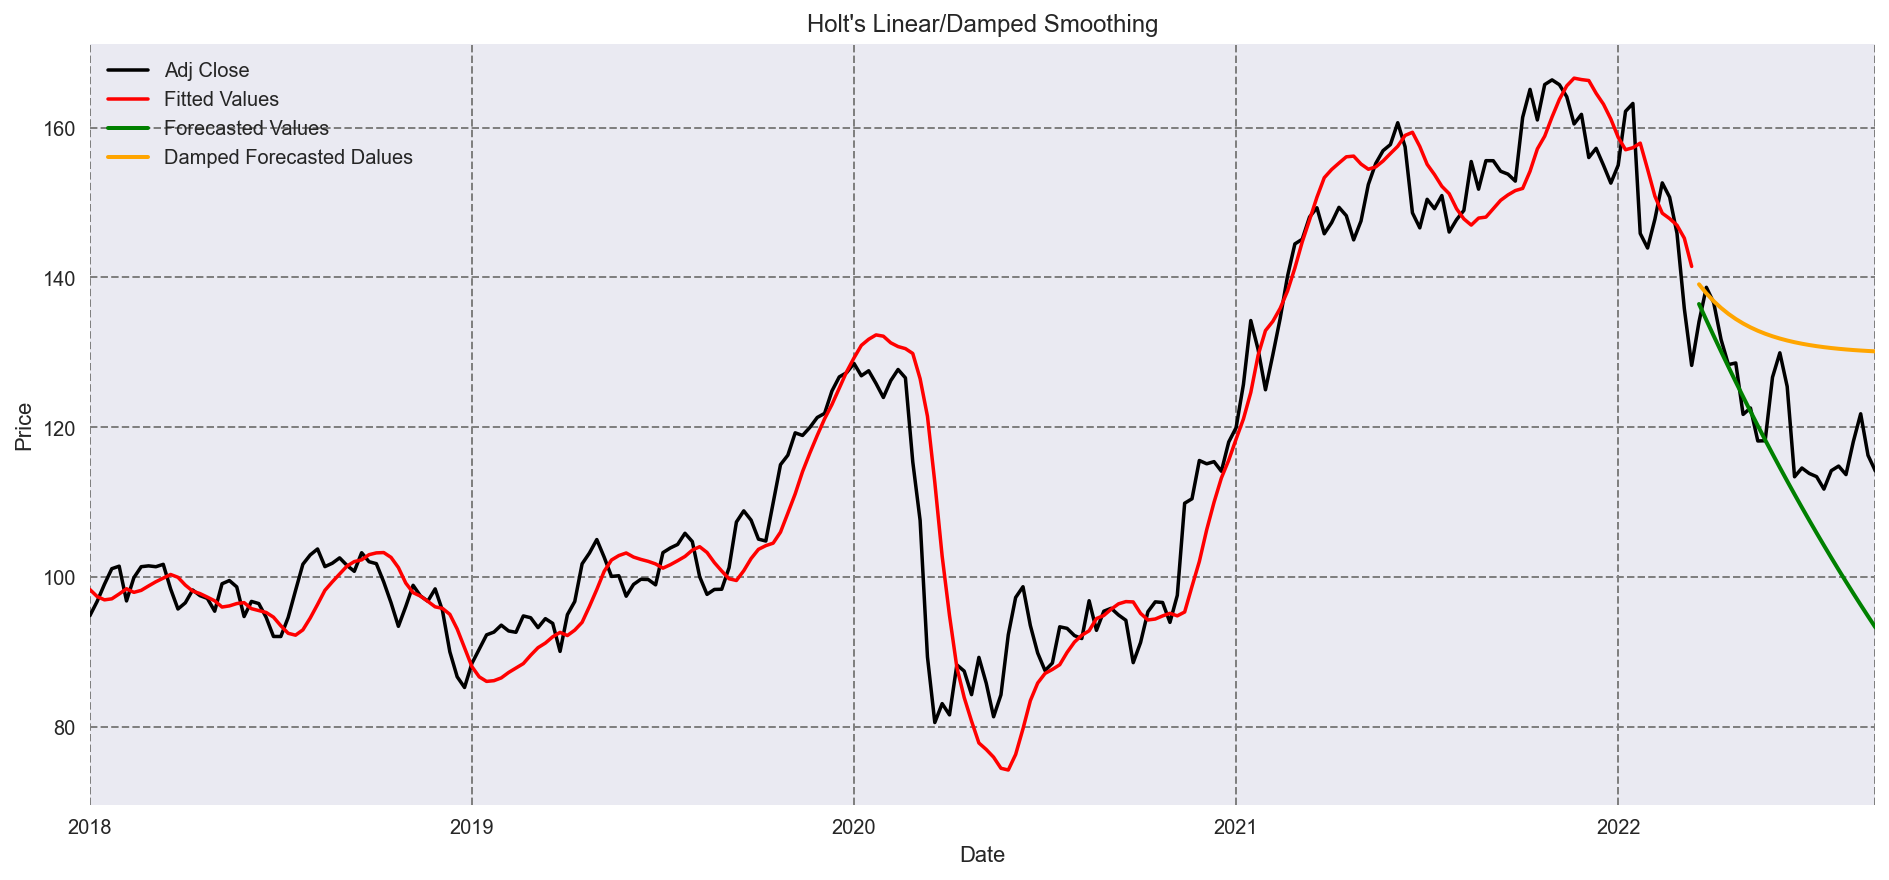

In [47]:
jpm_week_data.plot(
    color='k',title ="Holt's Linear/Damped Smoothing",
    legend=True, figsize=(16, 7))

model_1.fittedvalues.plot(color='r', label='Fitted Values', legend=True)
yhat_1.plot(color='g', legend=True, label='Forecasted Values', lw=2.0)
yhat_2.plot(color='orange', legend=True, label='Damped Forecasted Dalues', lw=2.0)
plt.ylabel('Price')
plt.grid(linestyle='--', c='grey');

In [48]:
rmse_holt_linear_smoothing = np.sqrt(mean_squared_error(test_data_es, yhat_1))
rmse_holt_damped_smoothing = np.sqrt(mean_squared_error(test_data_es, yhat_2))
print(f"Holt's Linear Exponencial smoothing RMSE:{rmse_holt_linear_smoothing}")
print(f"Holt's Dumped Exponencial smoothing RMSE:{rmse_holt_damped_smoothing}")

Holt's Linear Exponencial smoothing RMSE:11.3769576698105
Holt's Dumped Exponencial smoothing RMSE:12.480924839894877


From the graph, we can see that the double exponential smoothing performed significantly better than simple exponential smoothing. Holt's Linear Smoothing performs better than when we add a damped parameter.

[GO TO TOP](#go-to-top)

<a id='triple-exp-smoothing'></a>

### Triple Exponencial Smoothing

In [49]:
seasonal_periods = 52
# Holt-Winter's model with exponential trend
hw_1 = ExponentialSmoothing(
    train_data_es, trend='mul',
    seasonal='add', seasonal_periods=seasonal_periods,
    damped=False).fit()

hw_forecast_1 = hw_1.forecast(len(test_data_es))

# Holt-Winter's model with exponential trend and damping
hw_2 = ExponentialSmoothing(
    train_data_es, 
    trend='mul', 
    seasonal='add', 
    seasonal_periods=seasonal_periods, 
    damped=True).fit()

In [50]:
hw_forecast_2 = hw_2.forecast(len(test_data_es))

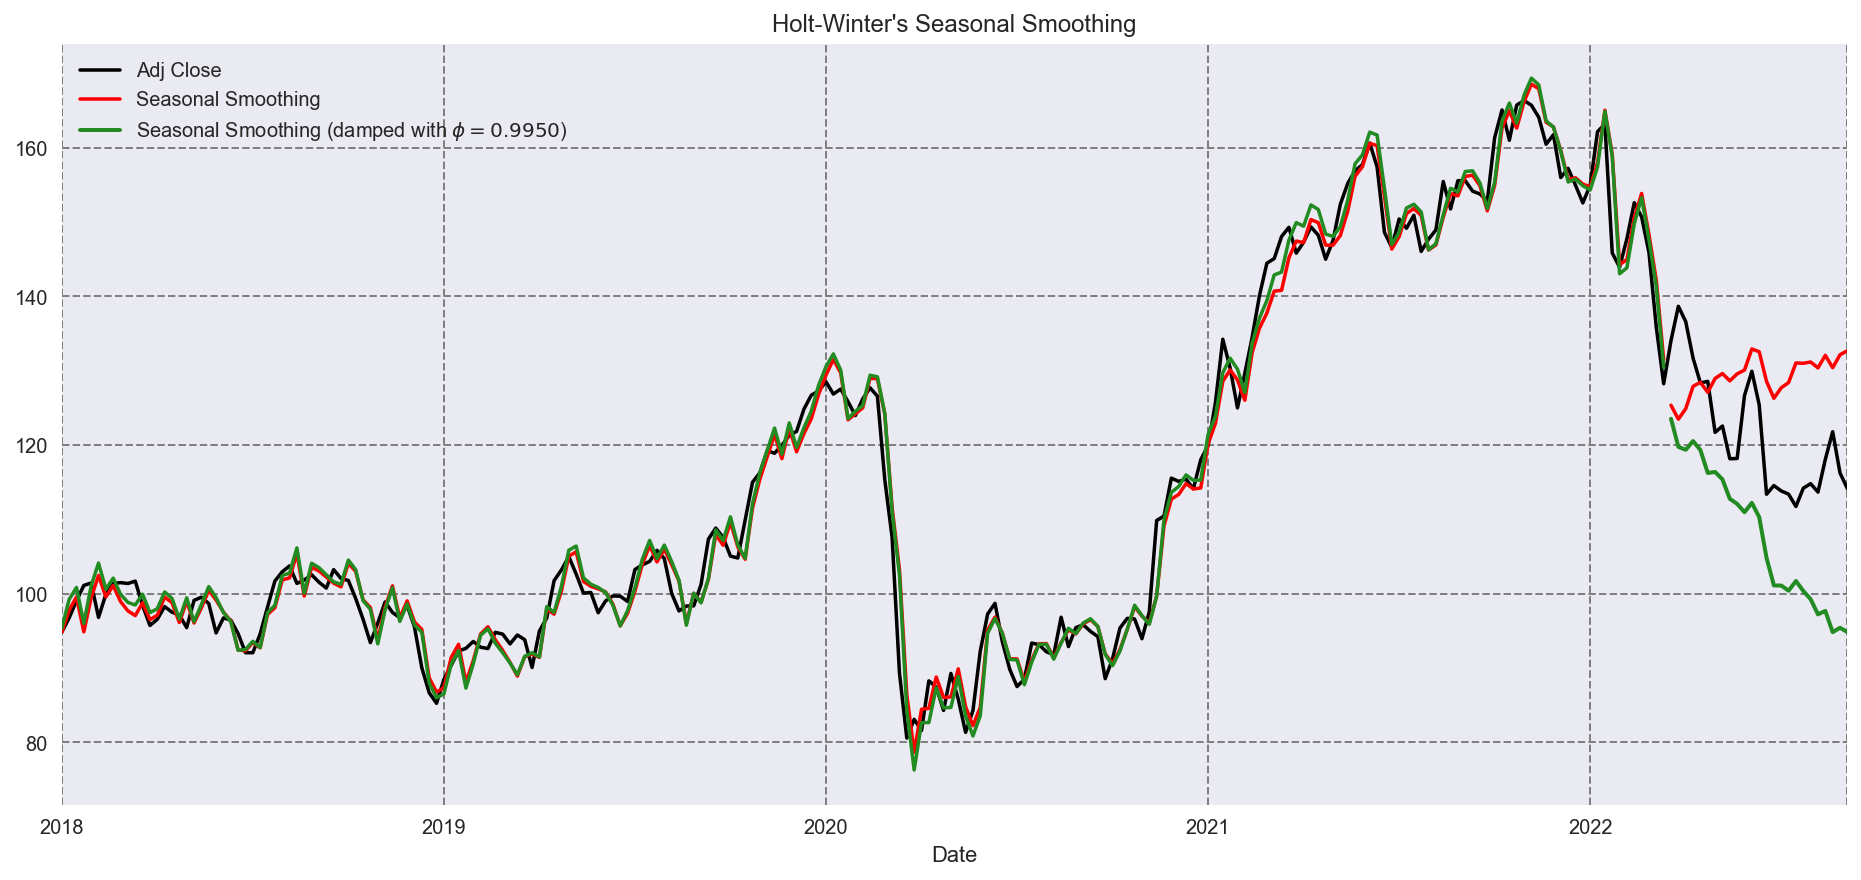

In [51]:
jpm_week_data.plot(
    color='k', title="Holt-Winter's Seasonal Smoothing", 
    legend=True, figsize=(16, 7))

hw_1.fittedvalues.plot(color='r')
hw_forecast_1.plot(color='r', legend=True, label='Seasonal Smoothing')

phi = hw_2.model.params['damping_trend']
plot_label = f'Seasonal Smoothing (damped with $\phi={phi:.4f}$)'

hw_2.fittedvalues.plot(color='forestgreen')
hw_forecast_2.plot(color='forestgreen', legend=True, label=plot_label, lw=2.0)
plt.grid(linestyle='--', c='grey');

In [52]:
rmse_triple_exp_smoothing = np.sqrt(mean_squared_error(test_data_es, hw_forecast_1))
rmse_tripl_exp_smoothing_damped = np.sqrt(mean_squared_error(test_data_es, hw_forecast_2))
print(f'Triple Exponential Smoothing RMSE: {rmse_triple_exp_smoothing}')

Triple Exponential Smoothing RMSE: 12.214772053710197


[GO TO TOP](#go-to-top)

<a id='model-building'></a>

## Model Building  AR,  MA, ARIMA

In [53]:
# Augmented Dickey-Fuller  unit root test
def ADF_test(data):
    """
    Perform Augmented Dickey-Fuller Test
    The number of considered lags is automatically selected based 
    on the Akaike Information Criterion (AIC)
    Ho = Null Hypothesis -> The data are not stationary
    H1 = Alternate Hypotesis -> The data are stationary
    """
    result = adfuller(data, autolag='AIC')
    print(f'ADF Statistic:{result[0]}')
    print (f'P-value: {result[1]}')
    print('Critical Values:')
    for x, y in result[4].items():
        print(f'{x}:{y}')
    if result[1] > 0.05:
        print('We accept the Null Hypotesis. Data are not stationary!')
    else:
        print('We accept the Alternate Hypotesis. Data are Stationary!')

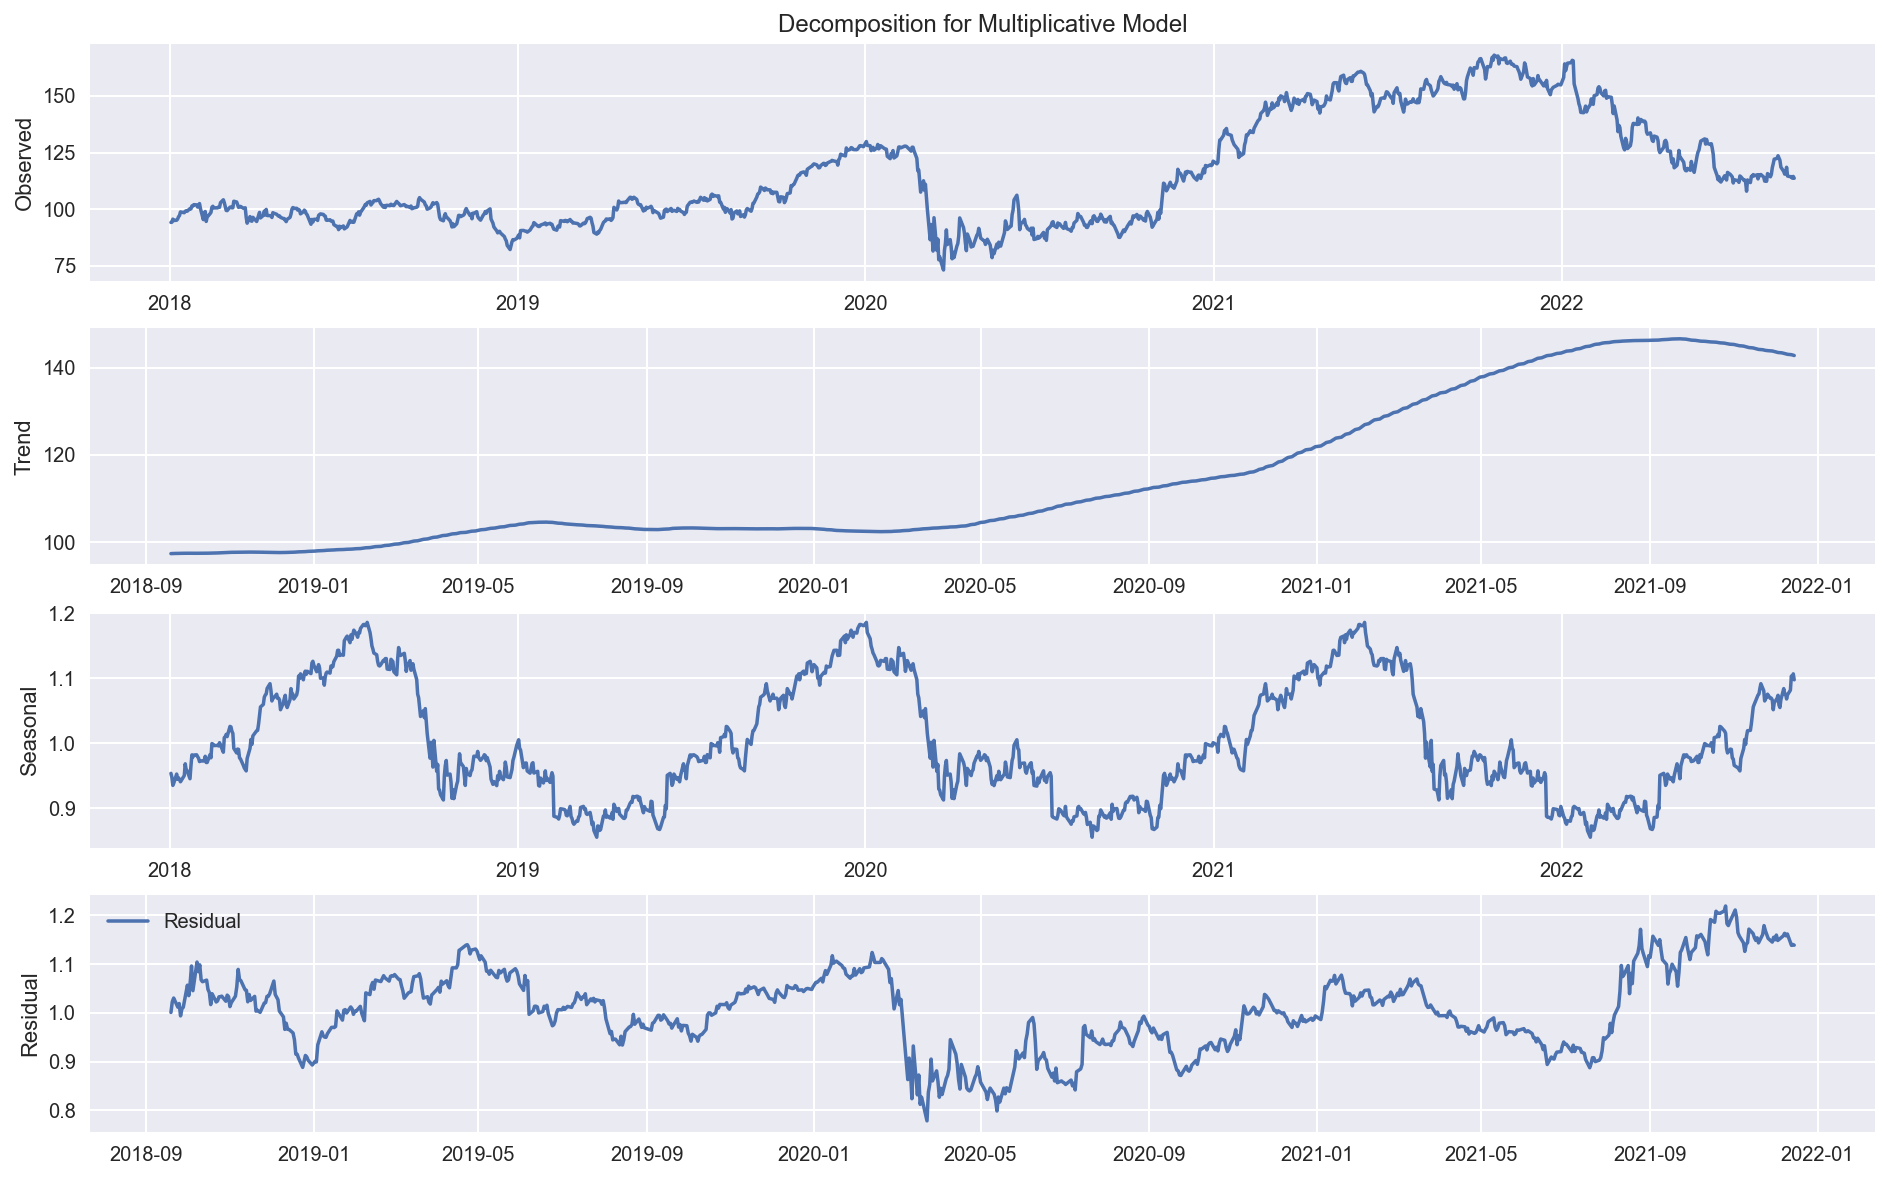

In [54]:
adj_close_price_jpm = jpm_stock_data['Adj Close'].to_frame().copy()
decomposed_jpm_close_price = seasonal_decompose(
    adj_close_price_jpm, period=360,
    model='multiplicative'
)

fig, ax = plt.subplots(4, 1, figsize=(16, 10))
ax[0].plot(decomposed_jpm_close_price.observed)
ax[0].set_ylabel('Observed')
ax[0].set_title('Decomposition for Multiplicative Model')

ax[1].plot(decomposed_jpm_close_price.trend)
ax[1].set_ylabel('Trend')

ax[2].plot(decomposed_jpm_close_price.seasonal, label='Seasonal')
ax[2].set_ylabel('Seasonal')

ax[3].plot(decomposed_jpm_close_price.resid, label='Residual')
ax[3].set_ylabel('Residual')

plt.legend()
plt.show()

Given the decomposition of the data set we can observe the presence of a polynomial trendand additive seasonality. In the residual plot the data seems to be random, no evidence of patterns.

[GO TO TOP](#go-to-top)

<a id='moving-average-model'></a>

### Moving Average

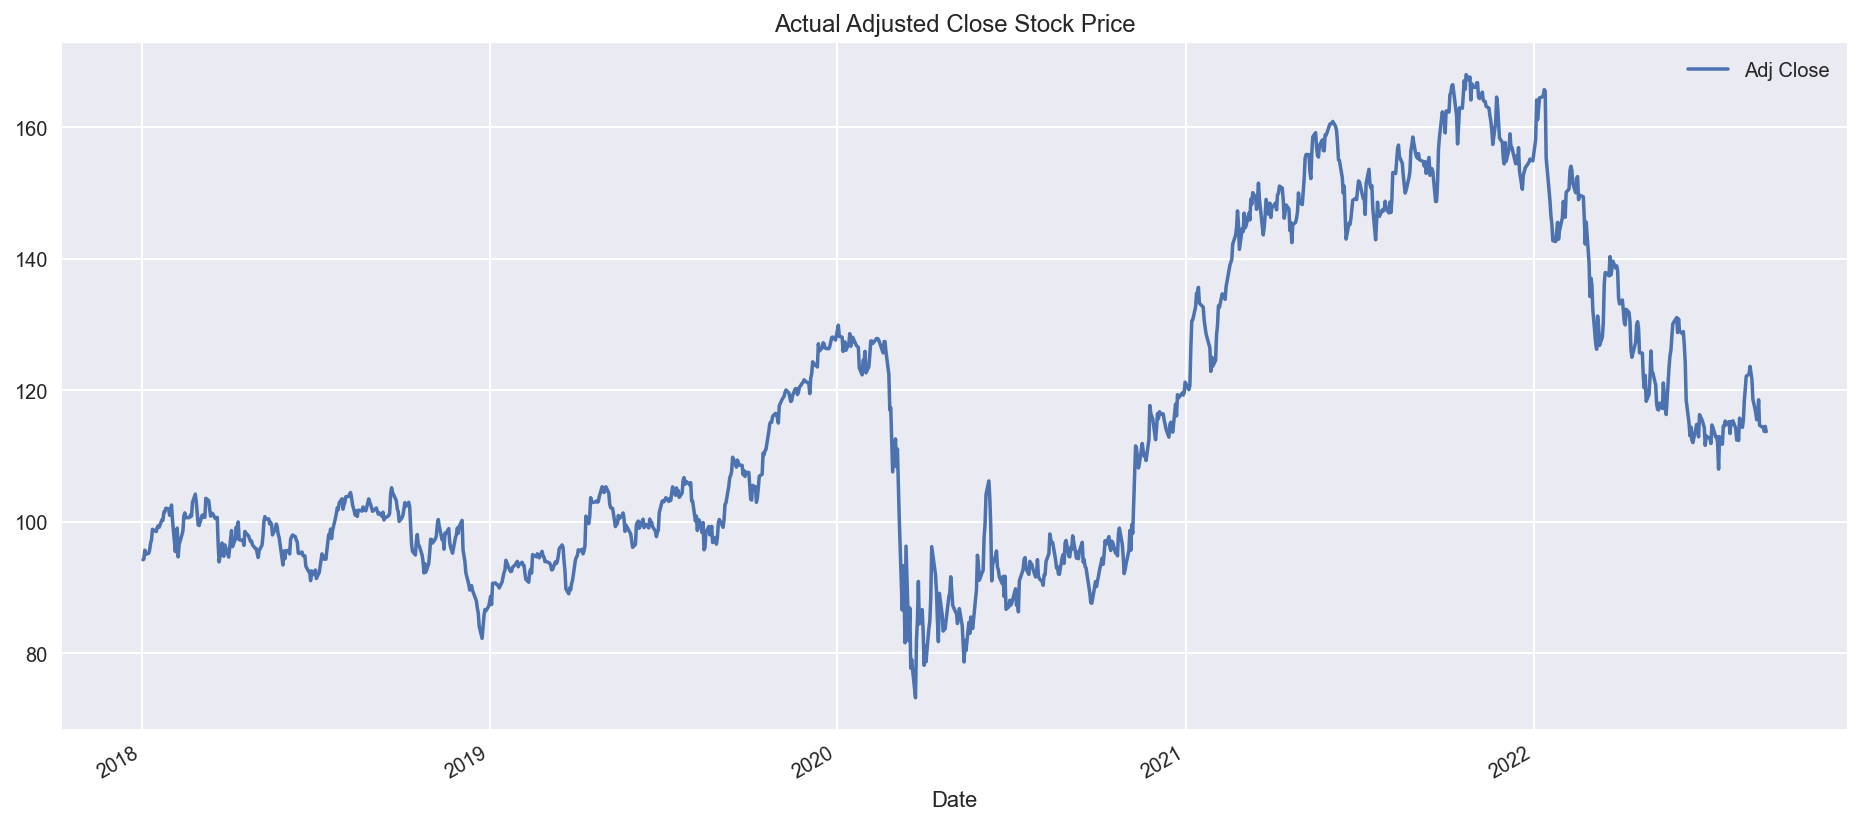

In [55]:
adj_close_price_jpm.plot(title='Actual Adjusted Close Stock Price', figsize=(16, 7));

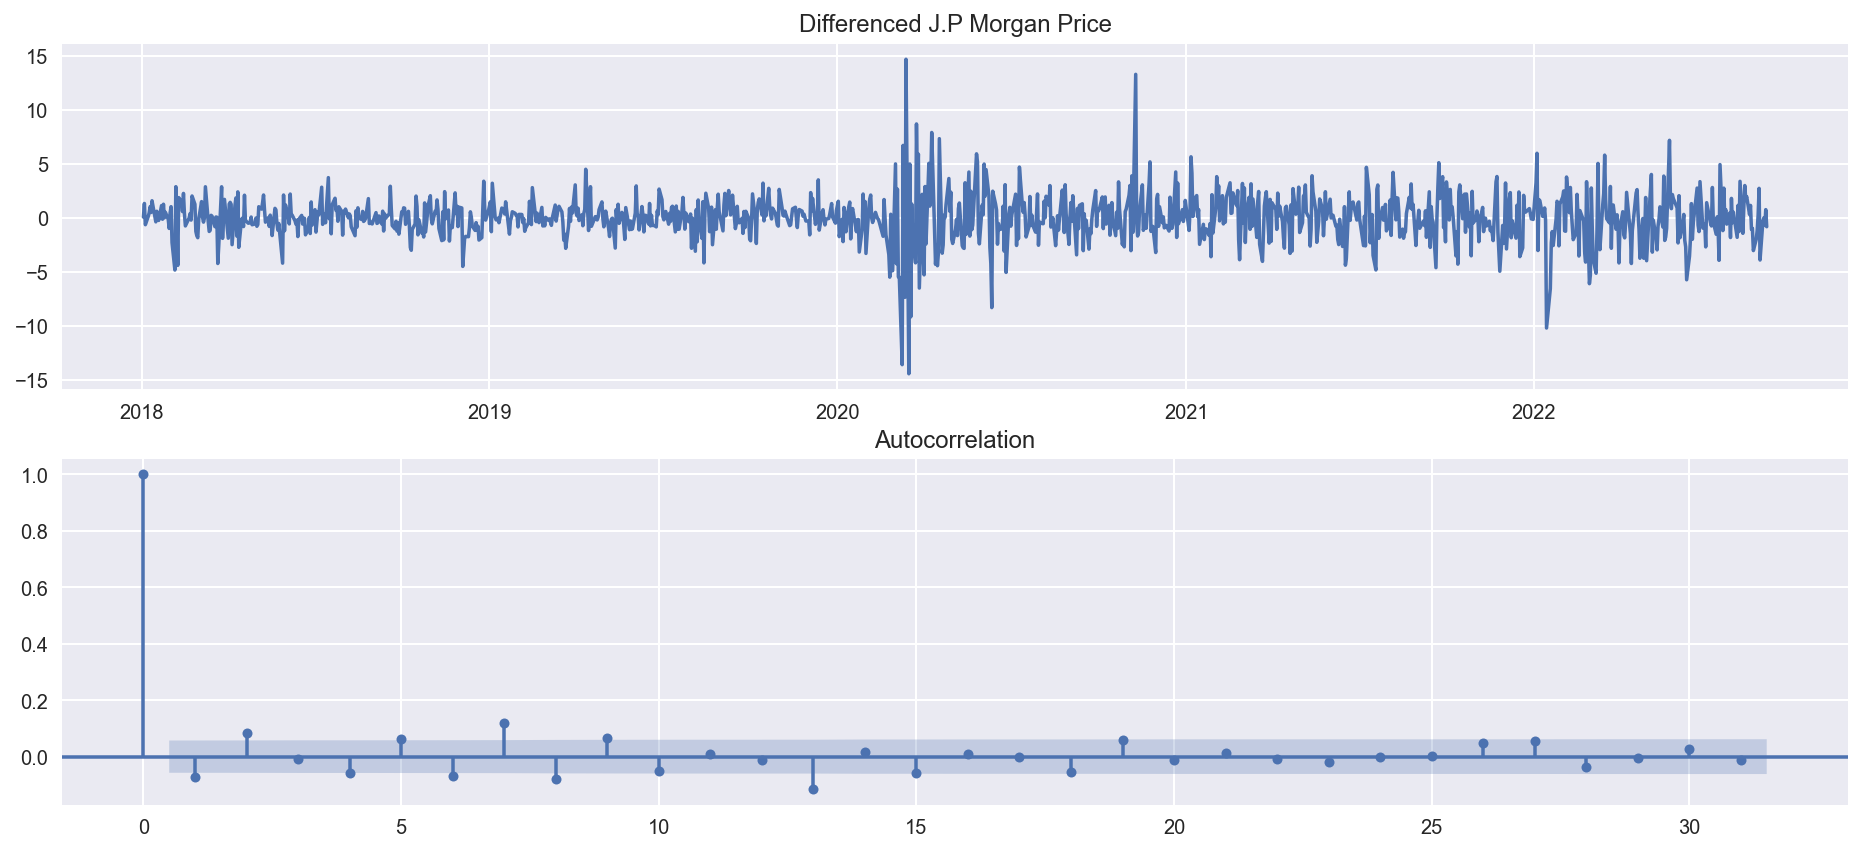

In [56]:
diff_data = adj_close_price_jpm.diff(1).dropna()
fig, ax = plt.subplots(2, 1, figsize=(16, 7))
ax[0].plot(diff_data)
ax[0].set_title('Differenced J.P Morgan Price')
plot_acf(diff_data, ax=ax[1]);

In [57]:
ADF_test(diff_data)

ADF Statistic:-10.485120334337257
P-value: 1.1858665004277939e-18
Critical Values:
1%:-3.4359852468525345
5%:-2.864028366455392
10%:-2.568094862687227
We accept the Alternate Hypotesis. Data are Stationary!


In [58]:
# Splitting data into train (95%) and test (5%)
split = int(len(diff_data.values) * 0.95)
diff_train_data = diff_data[:split]
diff_test_data = diff_data[split:]

In [59]:
short_moving_average = diff_train_data.rolling(window=7).mean()
long_moving_average = diff_train_data.rolling (window=19).mean()

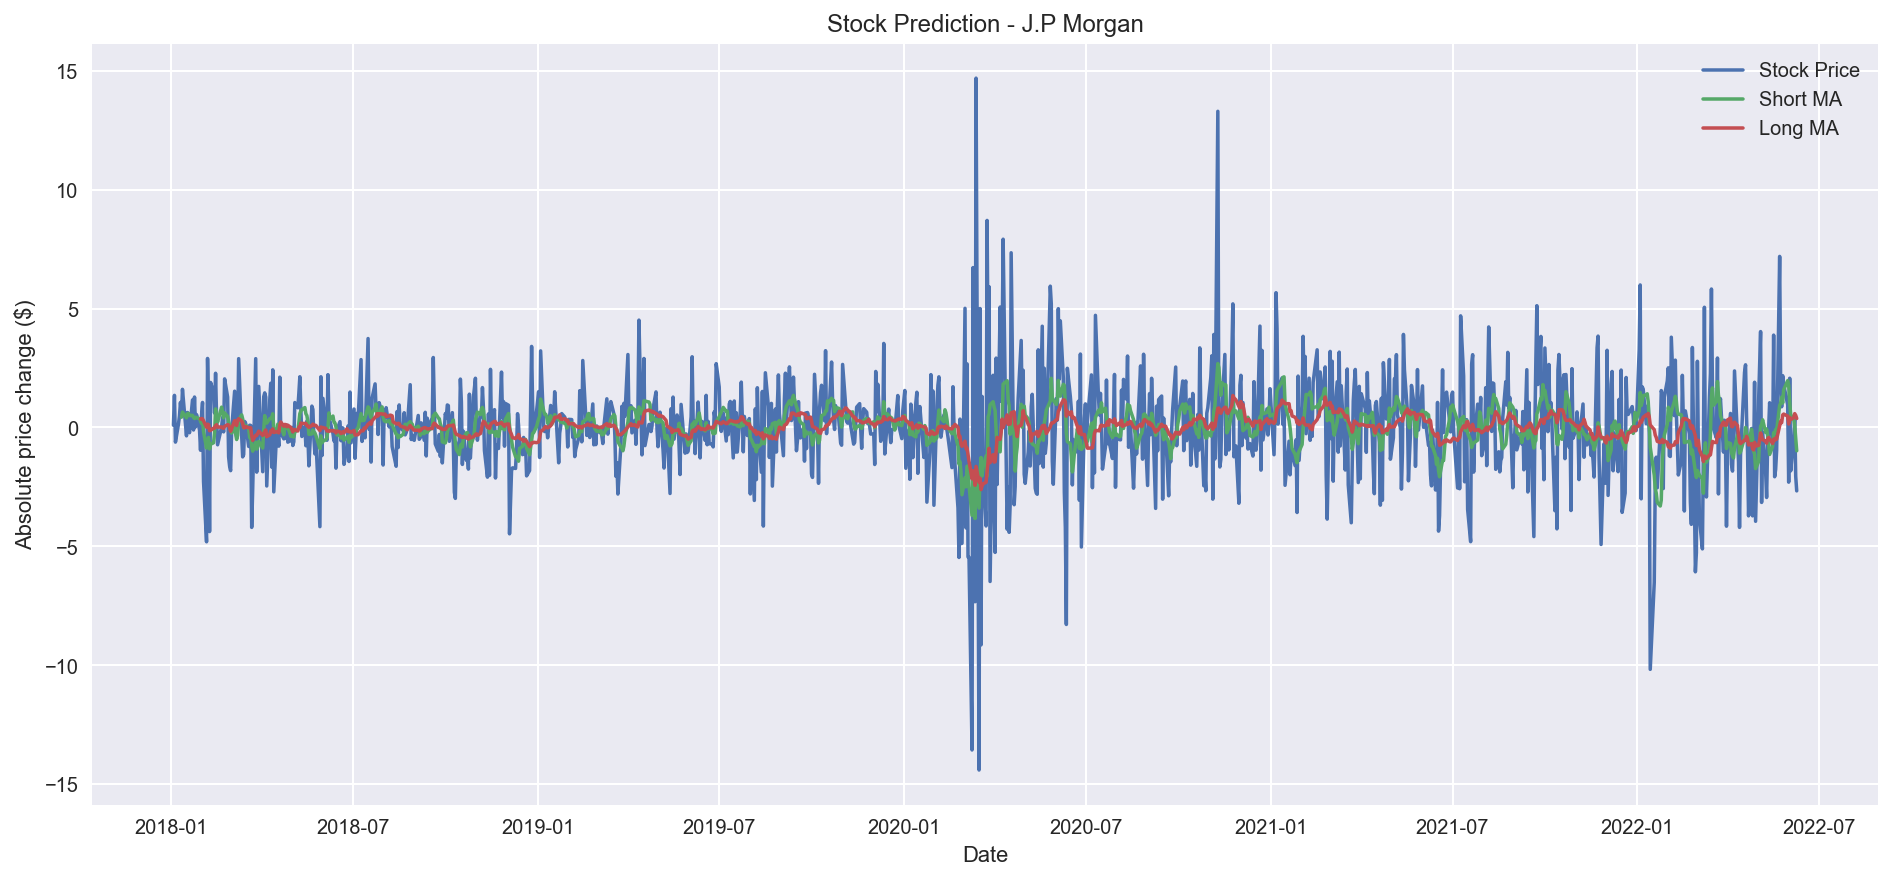

In [60]:
fig, ax = plt.subplots(1, 1, figsize=(16, 7))
ax.plot(diff_train_data.index, diff_train_data.values, label='Stock Price')
ax.plot(short_moving_average.index, short_moving_average, label='Short MA')
ax.plot(long_moving_average.index, long_moving_average, label='Long MA')
ax.set_title('Stock Prediction - J.P Morgan')
ax.set_xlabel('Date')
ax.set_ylabel('Absolute price change ($)')
ax.legend(loc='best')
plt.show()

Short-term MA tends to be more responsive to daily changes in J.P Morgan's stock price compared to the long-term MA, this is because I am taking into account just seven lags, and this means that just seven previous errors are accounted for to predict the actual data point.

[GO TO TOP](#go-to-top)

<a id='autoregressive-model'></a>

### Autoregressive Model

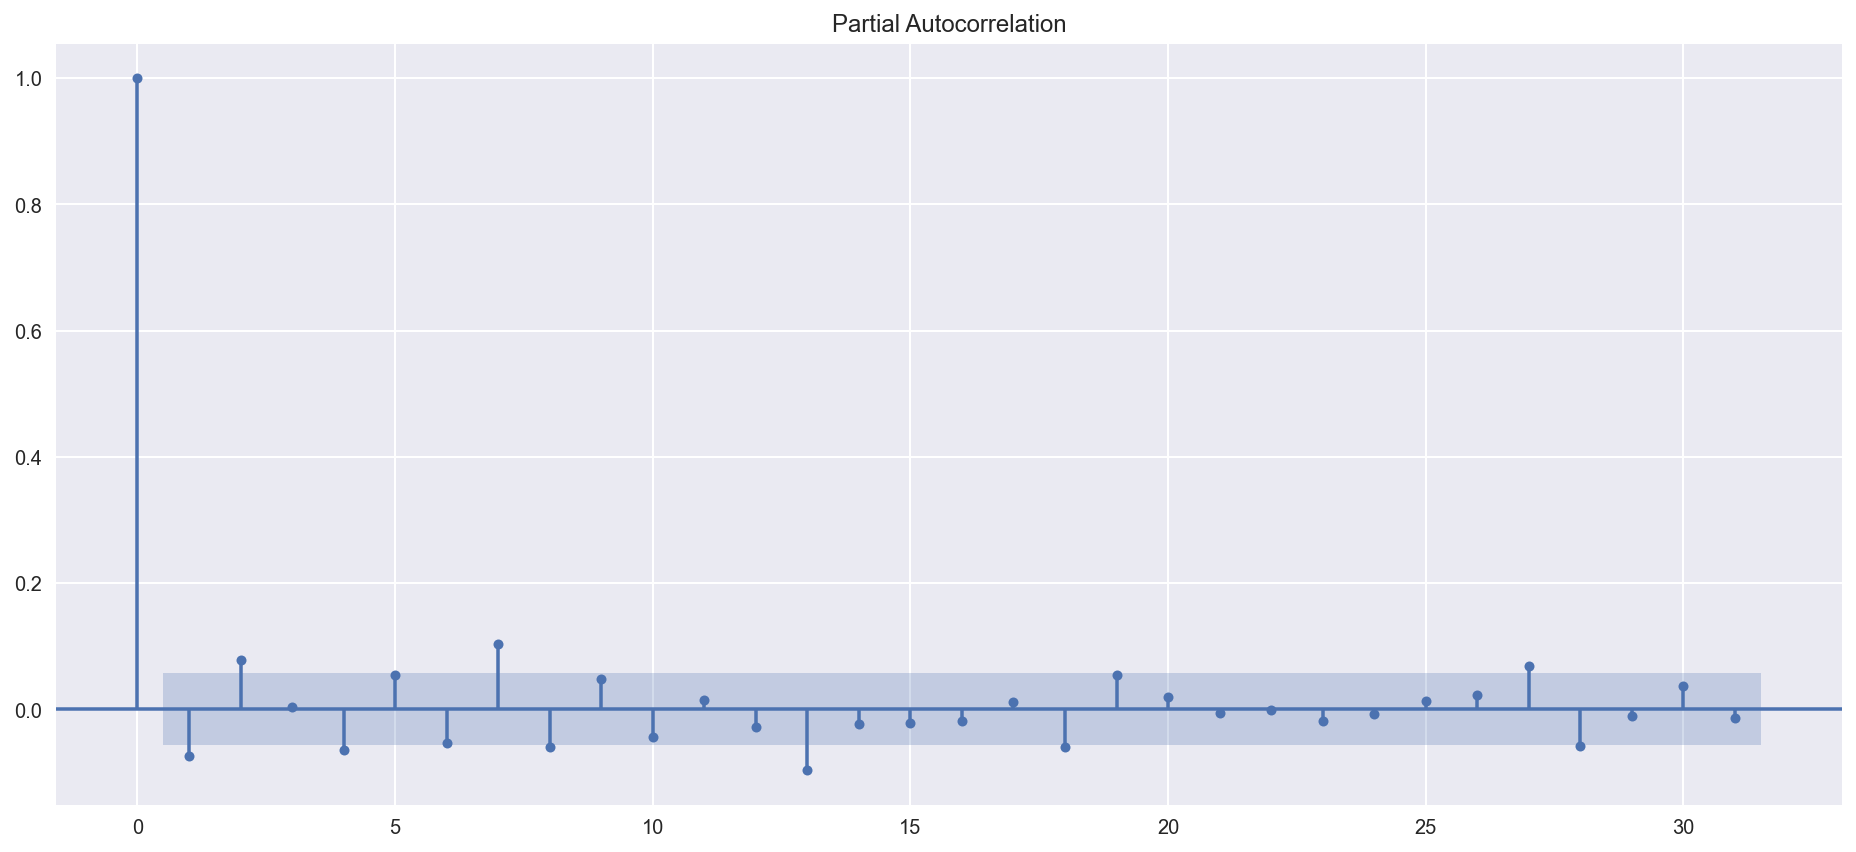

In [61]:
fig, ax = plt.subplots(1, 1, figsize=(16, 7))
plot_pacf(diff_data, ax=ax);

In [62]:
ar_jpm = AutoReg(diff_train_data.values, lags=27)
ar_fitted_jpm = ar_jpm.fit()  # Fitting stock data with AR model
# Predicting the stock prices
ar_predictions_jpm = ar_fitted_jpm.predict(
    start=len(diff_train_data), 
    end=len(diff_train_data) + len(diff_test_data) - 1,
    dynamic=False) 

In [63]:
ar_predictions_jpm = pd.DataFrame(ar_predictions_jpm)  # Turning the array into a dataframe 
ar_predictions_jpm.set_index(diff_test_data.index, inplace = True)

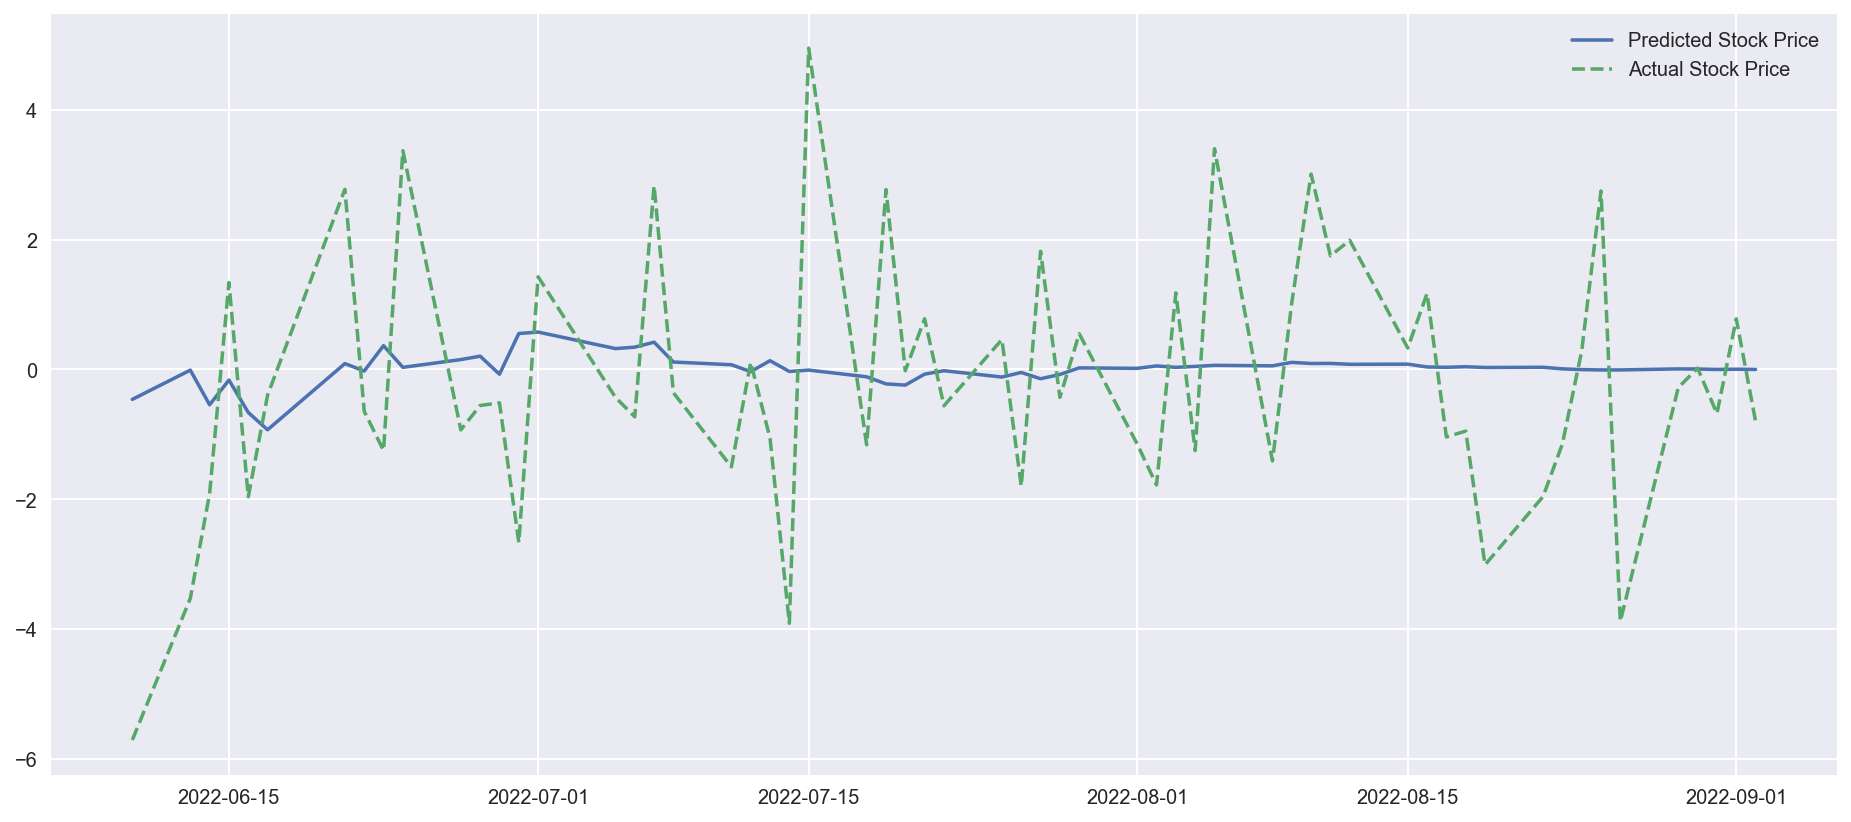

In [64]:
fig, ax = plt.subplots(1, 1, figsize=(16, 7))
ax.plot(ar_predictions_jpm, label='Predicted Stock Price')
ax.plot(diff_test_data, label='Actual Stock Price', ls='--')
plt.legend()
plt.show()

In [65]:
autoregressive_rmse = np.sqrt(mean_squared_error(diff_test_data, ar_predictions_jpm))
autoregressive_rmse

1.9734097720059567

We can observe that the predicmean_squared_error based on the AR model doesn't have a good performance, and I conclude that the MA model outperforms the AR model in capturing the stock price.

[GO TO TOP](#go-to-top)

<a id='auto-arima'></a>

### Autoregressive Integrated Moving Average (ARIMA)


ARIMA has three parameters:
* p - AR order
* d - level of differencing
* q - MA order

In [66]:
split = int(len(adj_close_price_jpm) * 0.90)
train_data = adj_close_price_jpm.iloc[:split]
test_data = adj_close_price_jpm.iloc[split:]

In [67]:
# Find the optimal number of differencing
number_of_diff = ndiffs(train_data, test = 'adf')
print(f'Number of differencing: {number_of_diff}')

Number of differencing: 1


To find the optimum number of lags to use in the ARIMA model, we need to choose an order that minimizes the AIC value.
I will use auto ARIMA to achieve this.

In [68]:
# Start_p -> the order of the auto-regressive (“AR”) model
# Start_q-> the starting value of q, the order of the moving-average (“MA”) model.
# m -> the number of periods in each season
model = auto_arima(
    train_data, start_p=1,
    start_q=1, max_p=3, 
    max_q=3, m=12,
    start_P=0, seasonal=True,
    d=1, D=1,
    trace=True, error_action='ignore',
    test='adf', information_criterion='aic',
    suppress_warnings=True
)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=inf, Time=1.92 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=5269.547, Time=0.05 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=4987.136, Time=0.27 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=1.96 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=5269.593, Time=0.10 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=4859.748, Time=0.69 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=5.34 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=2.08 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=4862.133, Time=0.45 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=4853.024, Time=0.93 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=4982.325, Time=0.37 sec
 ARIMA(2,1,0)(2,1,1)[12]             : AIC=inf, Time=8.91 sec
 ARIMA(2,1,0)(1,1,1)[12]             : AIC=inf, Time=4.38 sec
 ARIMA(3,1,0)(2,1,0)[12]             : AIC=4852.642, Time=1.27 sec
 ARIMA(3,1,0)(1,1,0)[12]             : AIC=4983.1

In [69]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                 1059
Model:             SARIMAX(3, 1, 2)x(2, 1, [], 12)   Log Likelihood               -2416.955
Date:                             Mon, 05 Sep 2022   AIC                           4849.910
Time:                                     08:43:05   BIC                           4889.532
Sample:                                          0   HQIC                          4864.937
                                            - 1059                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3519      0.086      4.093      0.000       0.183       0.520
ar.L2         -0.6958      0.078     -8.940      0.000      -0.848      -0.543
ar.L3         -0.1067      0.023     -4.546      0.000      -0.153      -0.061
ma.L1         -0.4131      0.084     -4.899      0.000      -0.578      -0.248
ma.L2          0.8023      0.072     11.189      0.000       0.662       0.943
ar.S.L12      -0.6709      0.022    -30.869      0.000      -0.713      -0.628
ar.S.L24      -0.3551      0.021    -16.779      0.000      -0.397      -0.314
sigma2         5.9128      0.162     36.579      0.000       5.596       6.230
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):               663.00
Prob(Q):                              0.92   Prob(JB):                         0.00
Heteroskedasticity (H):               3.12   Skew:                             0.01
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.90
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

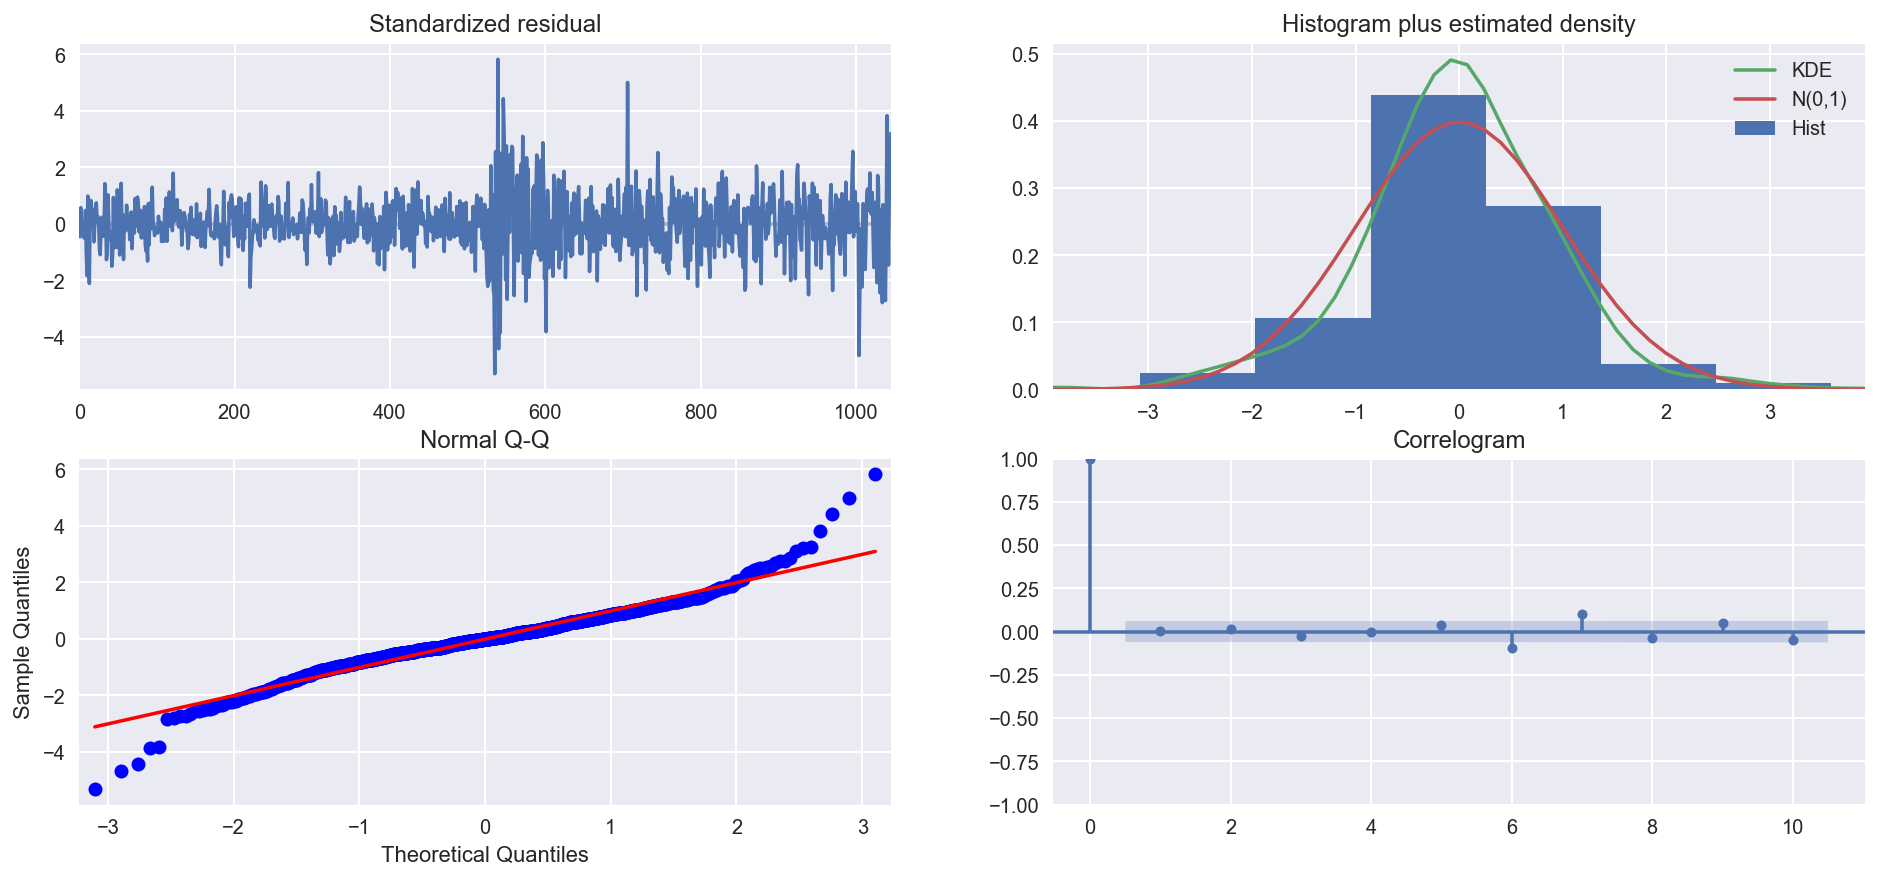

In [70]:
# Residuals to check their normality 
output = model.plot_diagnostics(figsize=(16, 7))

Notice how the normal Q-Q plot and the histogram show that our residuals follow a normal distribution. The correlogram also shows that the residuals are uncorrelated !

In [71]:
auto_arima_fitted = model.fit(train_data)

In [72]:
auto_arima_prediction_jpm = auto_arima_fitted.predict(len(test_data))

In [73]:
auto_arima_prediction_jpm = pd.DataFrame(
    auto_arima_prediction_jpm, 
    index=test_data.index)

In [74]:
auto_arima_rmse = sqrt(mean_squared_error(test_data, auto_arima_prediction_jpm))
print('RMSE: ', auto_arima_rmse)

RMSE:  11.07955158462678


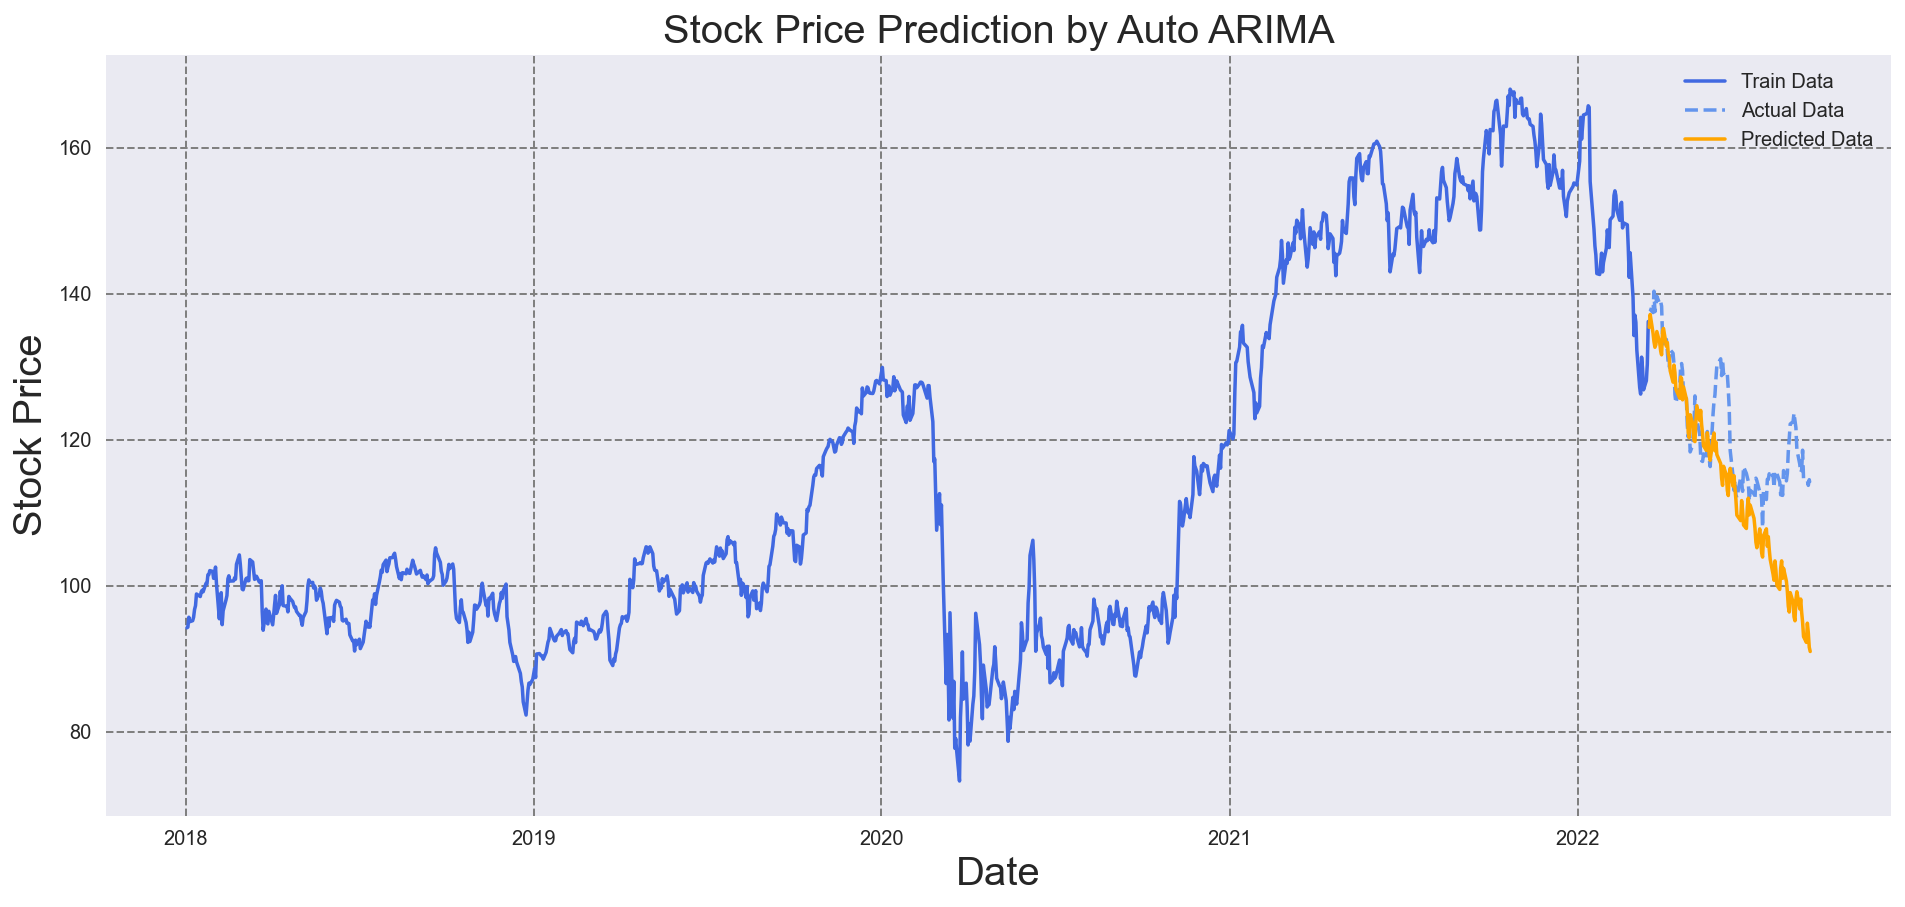

In [75]:
plt.figure(figsize=(16, 7))
plt.plot(train_data, c='royalblue')
plt.plot(test_data, c='cornflowerblue', ls='--')
plt.plot(auto_arima_prediction_jpm, c='orange')
plt.xlabel('Date', size=20)
plt.ylabel('Stock Price', size=20)
plt.title('Stock Price Prediction by Auto ARIMA', size=20)
plt.legend(['Train Data', 'Actual Data', 'Predicted Data'])
plt.grid(linestyle='--', c='grey')

[GO TO TOP](#go-to-top)

<a id='forecasting-auto-arima'></a>

### 21 days Forecasting

In [76]:
future_dates = [adj_close_price_jpm.index[-1] + DateOffset(days = x) for x in range(0, 21)]
forecasting_data = pd.DataFrame(index = future_dates)
forecasting_data.shape

(21, 0)

In [77]:
model = auto_arima(
    adj_close_price_jpm, start_p=1,
    start_q=1, max_p=3, 
    max_q=3, m=12,
    start_P=0, seasonal=True,
    d=1, D=1,
    trace=True, error_action='ignore',
    test='adf', information_criterion='aic',
    suppress_warnings=True)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=inf, Time=2.92 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=5905.848, Time=0.06 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=5566.025, Time=0.31 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=1.61 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=5907.359, Time=0.14 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=5419.308, Time=0.85 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=9.12 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=2.98 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=5420.545, Time=0.52 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=5413.596, Time=0.95 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=5561.836, Time=0.42 sec
 ARIMA(2,1,0)(2,1,1)[12]             : AIC=inf, Time=8.95 sec
 ARIMA(2,1,0)(1,1,1)[12]             : AIC=inf, Time=3.79 sec
 ARIMA(3,1,0)(2,1,0)[12]             : AIC=5413.632, Time=1.14 sec
 ARIMA(2,1,1)(2,1,0)[12]             : AIC=5414.9

In [78]:
fitted_model = model.fit(adj_close_price_jpm)
predictions = fitted_model.predict(forecasting_data.shape[0])
forecasting_data['Predictions'] = predictions

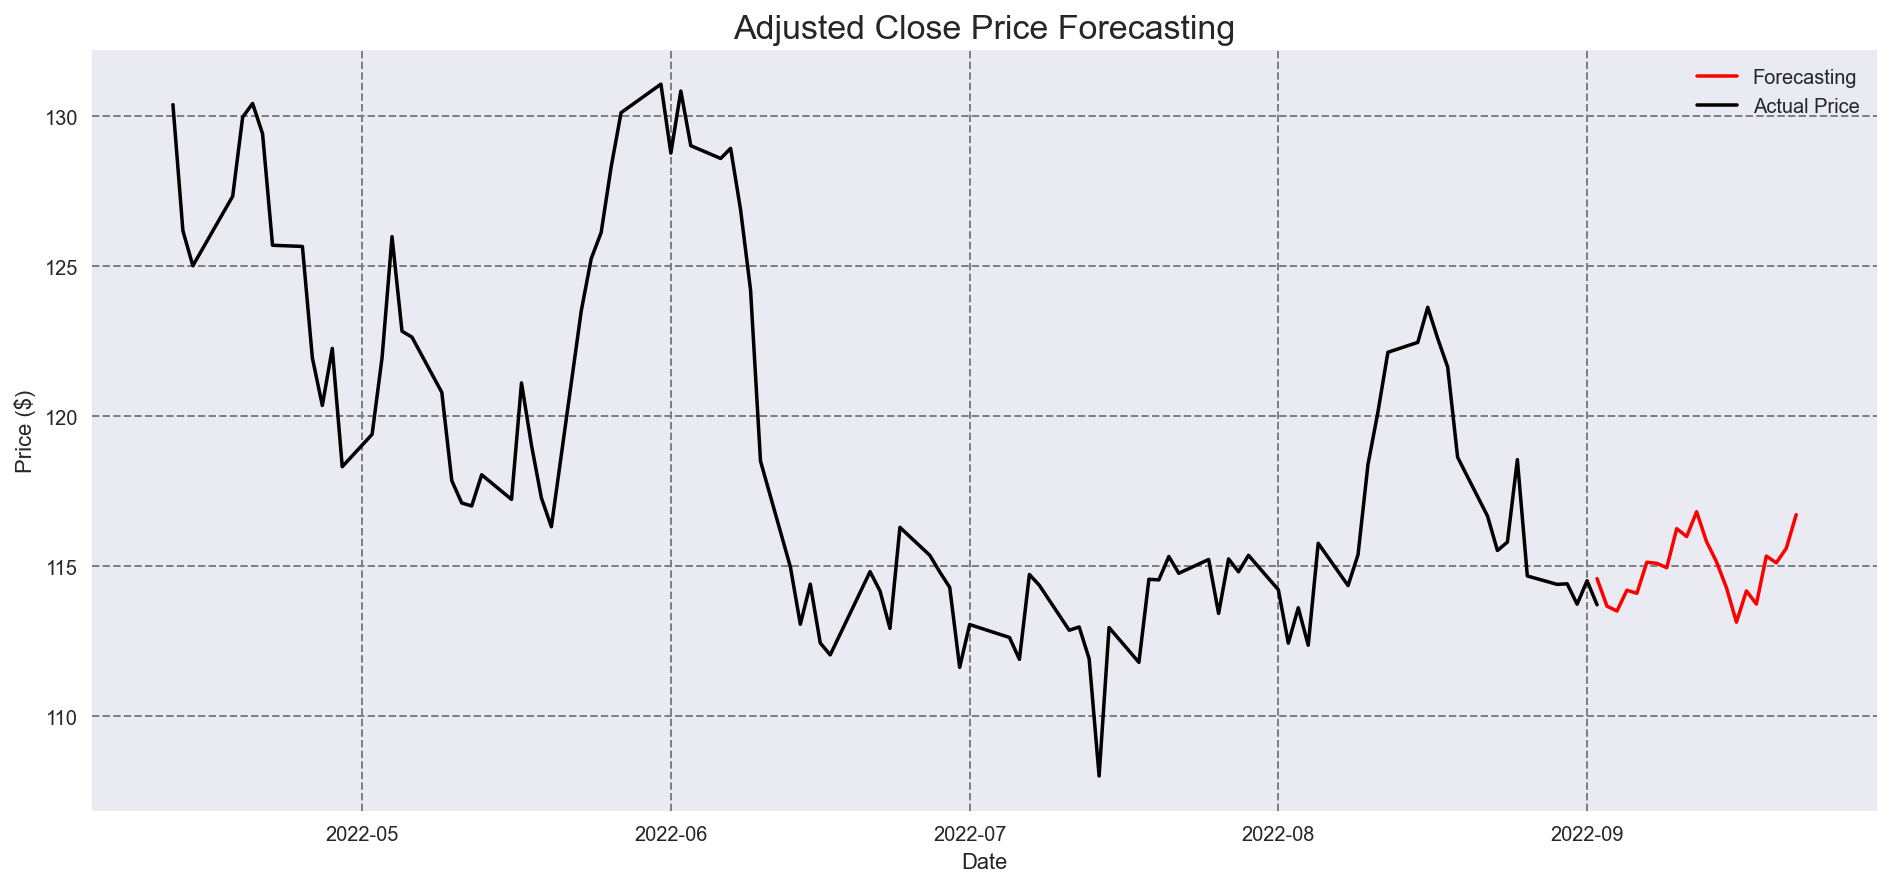

In [79]:
plt.figure(figsize=(16, 7))
plt.plot(forecasting_data, label='Forecasting', c='r')
plt.plot(adj_close_price_jpm.iloc[-100:], label='Actual Price', c='k')
plt.title('Adjusted Close Price Forecasting', fontdict={'fontsize': 17})
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.grid(linestyle='--', c='grey')
plt.legend();

[GO TO TOP](#go-to-top)

In [80]:
adj_close_price_jpm

Adj Close
Date                  
2018-01-02   94.219803
2018-01-03   94.315842
2018-01-04   95.666962
2018-01-05   95.052803
2018-01-08   95.193199
...                ...
2022-08-29  114.389999
2022-08-30  114.410004
2022-08-31  113.730003
2022-09-01  114.510002
2022-09-02  113.709999

[1177 rows x 1 columns]

In [81]:
train_data
test_data
stepwise_model=auto_arima(
    train_data, start_p=1, start_q=1,
    max_p=7, max_q=7, start_P=1, 
    start_Q=1, max_P=7, max_Q=7, D=1,
    test='adf', seasonal=True)

In [82]:
stepwise_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1059
Model:               SARIMAX(2, 1, 0)   Log Likelihood               -2300.581
Date:                Mon, 05 Sep 2022   AIC                           4607.162
Time:                        08:45:20   BIC                           4622.054
Sample:                             0   HQIC                          4612.806
                               - 1059                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0799      0.015     -5.315      0.000      -0.109      -0.050
ar.L2          0.0766      0.018      4.229      0.000       0.041       0.112
sigma2         4.5311      0.096     47.126      0.000       4.343       4.720
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              2222.08
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               3.28   Skew:                            -0.12
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.10
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

# Volatility modelling

### ARCH model

In [83]:
idx = pd.IndexSlice
jpm_data = stock_data.loc[:, idx[:, 'JPM']].droplevel(1, axis='columns')['Adj Close'].copy().to_frame()
jpm_data.head()

Adj Close
Date                 
2018-01-02  94.219803
2018-01-03  94.315842
2018-01-04  95.666962
2018-01-05  95.052803
2018-01-08  95.193199

In [84]:
jpm_data['Returns'] = jpm_data.pct_change() * 100
jpm_data['Realized_vol'] = jpm_data['Returns'].rolling(5).std()

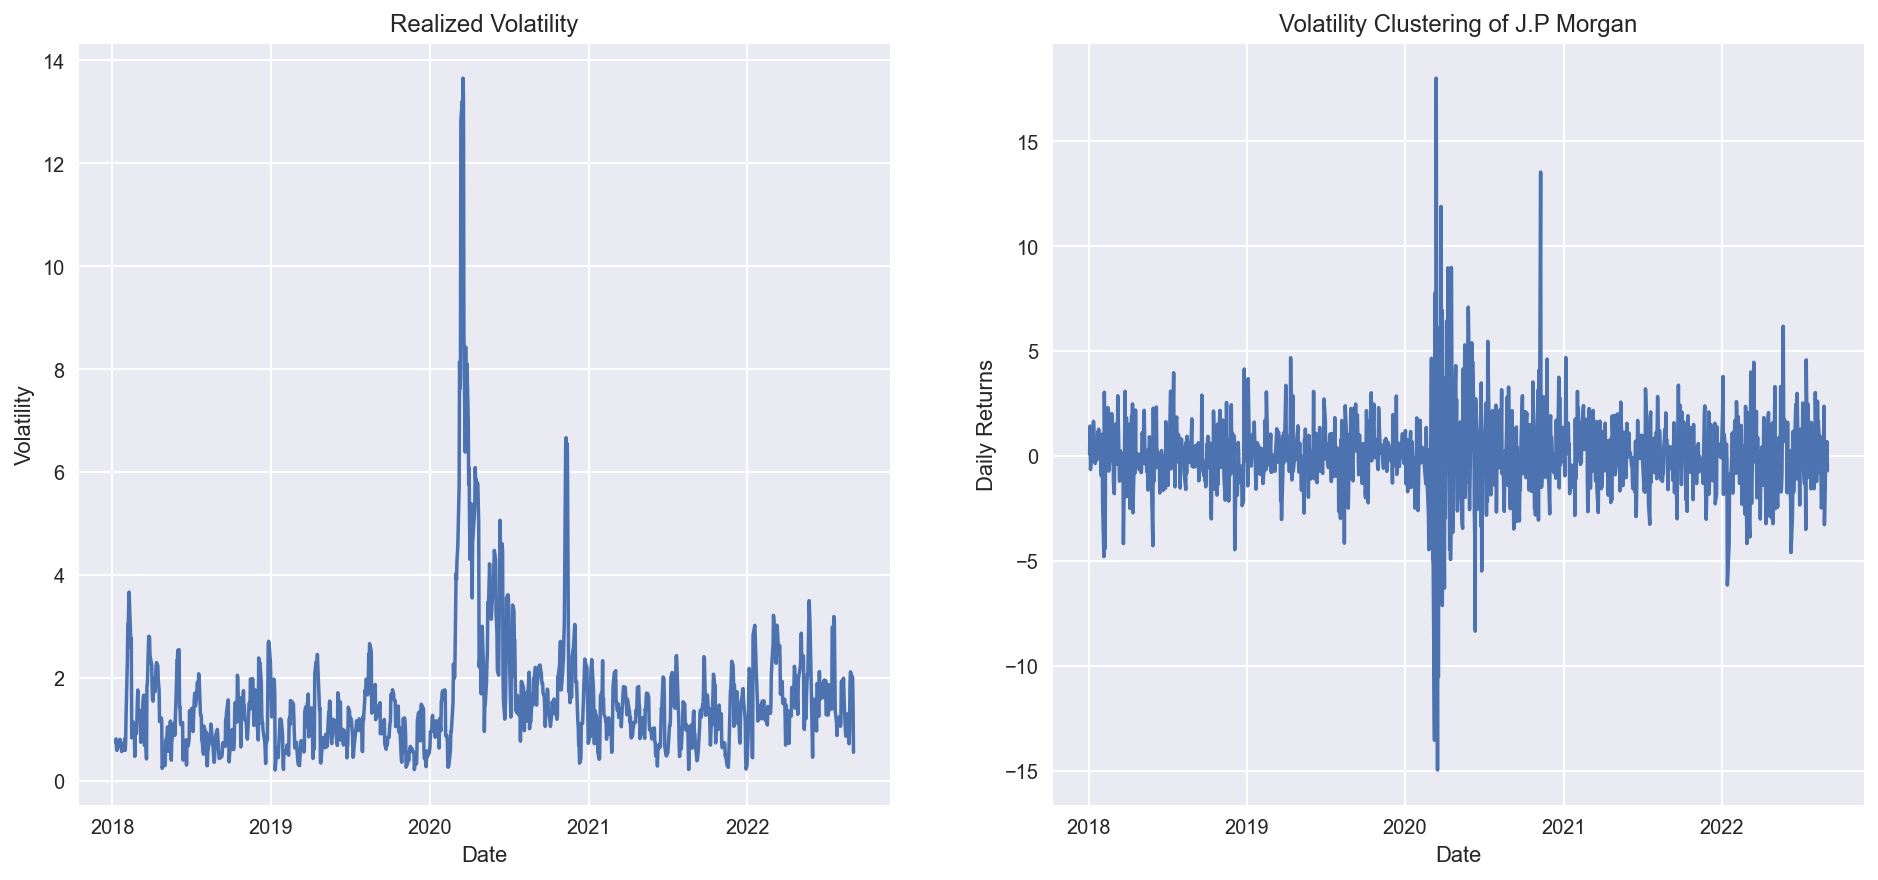

In [85]:
fig, ax = plt.subplots(1, 2, figsize=(16, 7))

ax[0].plot(jpm_data['Realized_vol'])
ax[0].set_title('Realized Volatility')
ax[0].set_ylabel('Volatility')
ax[0].set_xlabel('Date')

ax[1].plot(jpm_data['Returns'])
ax[1].set_title('Volatility Clustering of J.P Morgan')
ax[1].set_ylabel('Daily Returns')
ax[1].set_xlabel('Date')

plt.show()

<AxesSubplot:xlabel='Returns', ylabel='Density'>

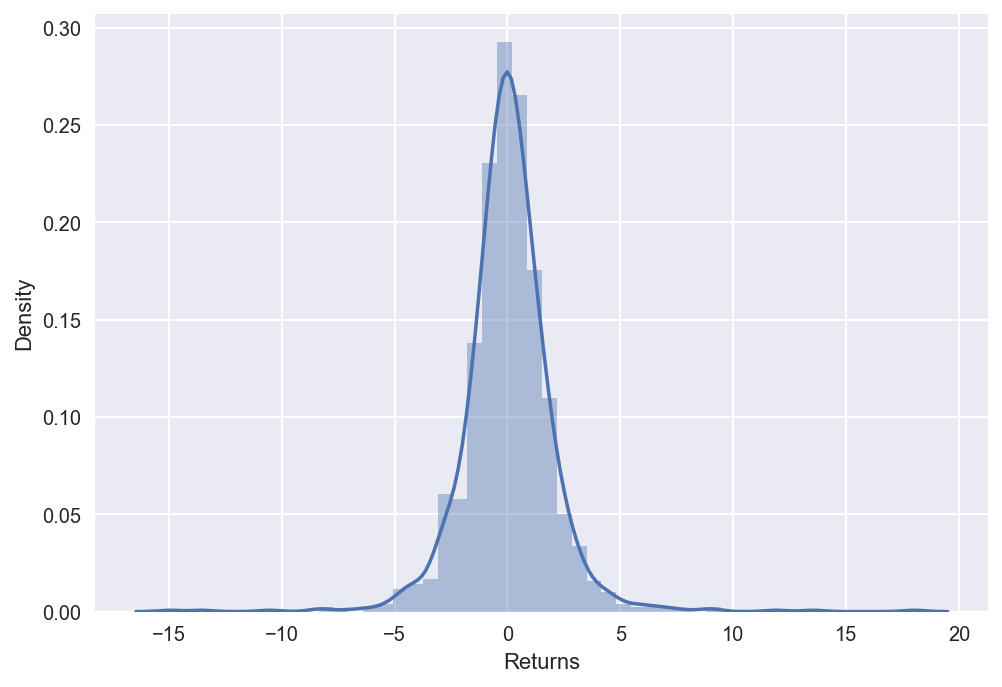

In [86]:
sns.distplot(jpm_data['Returns'])

In [87]:
n = 60
split_date = jpm_data.iloc[-n :].index
split_date

DatetimeIndex(['2022-06-09', '2022-06-10', '2022-06-13', '2022-06-14',
               '2022-06-15', '2022-06-16', '2022-06-17', '2022-06-21',
               '2022-06-22', '2022-06-23', '2022-06-24', '2022-06-27',
               '2022-06-28', '2022-06-29', '2022-06-30', '2022-07-01',
               '2022-07-05', '2022-07-06', '2022-07-07', '2022-07-08',
               '2022-07-11', '2022-07-12', '2022-07-13', '2022-07-14',
               '2022-07-15', '2022-07-18', '2022-07-19', '2022-07-20',
               '2022-07-21', '2022-07-22', '2022-07-25', '2022-07-26',
               '2022-07-27', '2022-07-28', '2022-07-29', '2022-08-01',
               '2022-08-02', '2022-08-03', '2022-08-04', '2022-08-05',
               '2022-08-08', '2022-08-09', '2022-08-10', '2022-08-11',
               '2022-08-12', '2022-08-15', '2022-08-16', '2022-08-17',
               '2022-08-18', '2022-08-19', '2022-08-22', '2022-08-23',
               '2022-08-24', '2022-08-25', '2022-08-26', '2022-08-29',
      

In [88]:
arch = arch_model(jpm_data['Returns'].dropna(), mean='zero', vol='arch', p=1, dist='normal').fit(disp='off')
arch.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                        Zero Mean - ARCH Model Results                        
==============================================================================
Dep. Variable:                Returns   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.001
Vol Model:                       ARCH   Log-Likelihood:               -2305.11
Distribution:                  Normal   AIC:                           4614.21
Method:            Maximum Likelihood   BIC:                           4624.35
                                        No. Observations:                 1176
Date:                Mon, Sep 05 2022   Df Residuals:                     1176
Time:                        08:45:21   Df Model:                            0
                            Volatility Model                            
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
omega          1.8925      0.174     10.880  1.429e-27 [  1.552,  2.233]
alpha[1]       0.5318  9.154e-02      5.810  6.256e-09 [  0.352,  0.711]
========================================================================

Covariance estimator: robust
"""

In [89]:
forecast = arch.forecast(start=split_date[0])
arch_forecast = forecast

In [90]:
rmse_arch = np.sqrt(mean_squared_error(jpm_data['Realized_vol'].iloc[-n:] / 100, np.sqrt(arch_forecast.variance.iloc[-len(split_date):] / 100)))
print(f'The RMSE value of ARCH models is: {round(rmse_arch, 4)}')

The RMSE value of ARCH models is: 0.1713


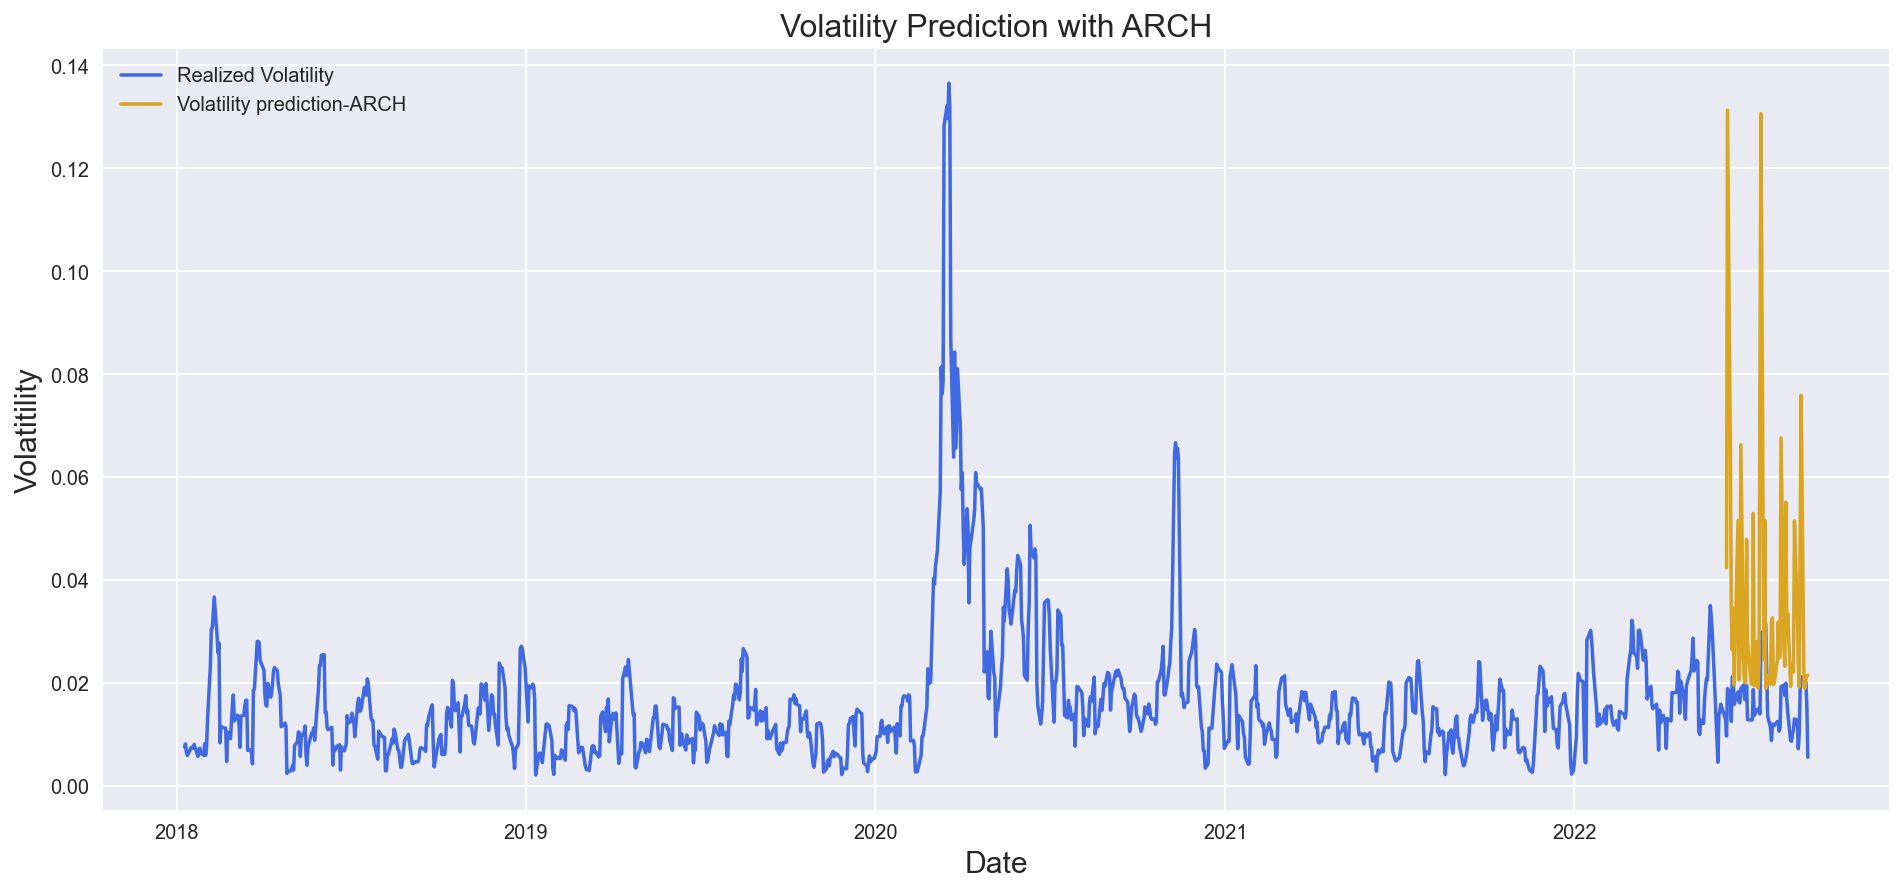

In [91]:
plt.figure(figsize=(16, 7))
plt.plot(jpm_data['Realized_vol']/ 100, label='Realized Volatility', c='royalblue') 
plt.plot(arch_forecast.variance.iloc[-len(split_date) :] / 100, label='Volatility prediction-ARCH', c='goldenrod')
plt.title('Volatility Prediction with ARCH', fontsize=16)
plt.xlabel('Date', fontsize=15)
plt.ylabel('Volatitility', fontsize=15)
plt.legend()

[GO TO TOP](#go-to-top)

### GARCH model

In [92]:
bic_garch = []
for p in range(1, 5):
    for q in range(1, 5):
        garch = arch_model(jpm_data['Returns'].dropna(), vol='garch', mean='constant', dist='normal', p=p, q=q).fit(disp='off')
        bic_garch.append(garch.bic)
        if garch.bic <= np.min(bic_garch):
            best_param = p, q
garch = arch_model(jpm_data['Returns'].dropna(), vol='garch', mean='constant', dist='normal', p=best_param[0], q=best_param[1]).fit(disp='off')
garch.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                Returns   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -2237.24
Distribution:                  Normal   AIC:                           4482.48
Method:            Maximum Likelihood   BIC:                           4502.75
                                        No. Observations:                 1176
Date:                Mon, Sep 05 2022   Df Residuals:                     1175
Time:                        08:45:22   Df Model:                            1
                                 Mean Model                                
===========================================================================
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
mu             0.0761  4.217e-02      1.804  7.131e-02 [-6.598e-03,  0.159]
                             Volatility Model                             
==========================================================================
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
omega          0.1639  6.079e-02      2.697  7.006e-03 [4.478e-02,  0.283]
alpha[1]       0.1463  4.141e-02      3.532  4.127e-04 [6.509e-02,  0.227]
beta[1]        0.8047  4.899e-02     16.425  1.257e-60   [  0.709,  0.901]
==========================================================================

Covariance estimator: robust
"""

In [93]:
forecast = arch.forecast(start=split_date[0])
garch_forecast = forecast

In [94]:
rmse_garch = np.sqrt(mean_squared_error(jpm_data['Realized_vol'].iloc[-n:] / 100, np.sqrt(garch_forecast.variance.iloc[-len(split_date):] / 100)))

In [95]:
print(f'The RMSE value of GARCH model is: {round(rmse_garch, 4)}')

The RMSE value of GARCH model is: 0.1713


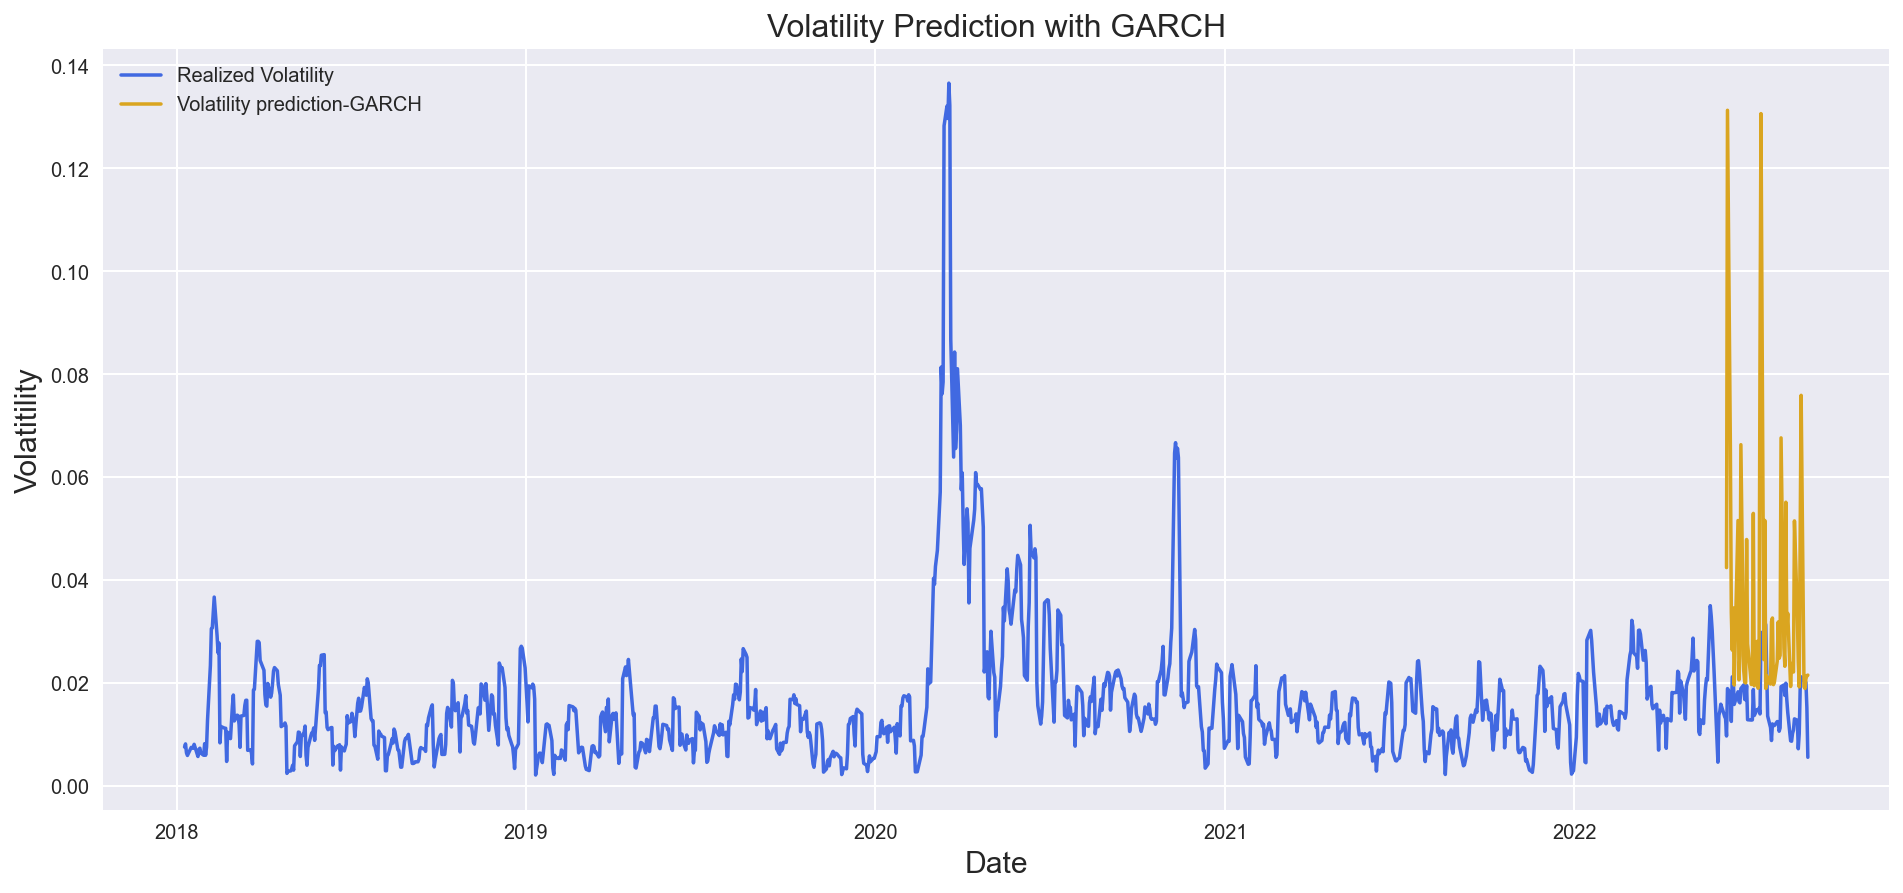

In [96]:
plt.figure(figsize=(16, 7))
plt.plot(jpm_data['Realized_vol']/ 100, label='Realized Volatility', c='royalblue')
plt.plot(garch_forecast.variance.iloc[-len(split_date):] / 100, label='Volatility prediction-GARCH', c='goldenrod')
plt.title('Volatility Prediction with GARCH', fontsize=16)
plt.xlabel('Date', fontsize=15)
plt.ylabel('Volatitility', fontsize=15)
plt.legend()
plt.show()

[GO TO TOP](#go-to-top)

### EGARCH model

In [97]:
bic_egarch = []
for b in range(1, 5):
    for q in range(1, 5):
        egarch = arch_model(jpm_data['Returns'].dropna(), vol='egarch', mean='constant', p=p, q=q).fit(disp='off')
        bic_egarch.append(egarch.bic)
        if egarch.bic < np.min(bic_egarch):
            best_param = p, q

In [98]:
egarch = arch_model(jpm_data['Returns'].dropna(), vol='egarch', mean='constant', p=best_param[0], q=best_param[1]).fit(disp='off')

In [99]:
egarch.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - EGARCH Model Results                     
==============================================================================
Dep. Variable:                Returns   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                     EGARCH   Log-Likelihood:               -2239.28
Distribution:                  Normal   AIC:                           4486.56
Method:            Maximum Likelihood   BIC:                           4506.84
                                        No. Observations:                 1176
Date:                Mon, Sep 05 2022   Df Residuals:                     1175
Time:                        08:45:24   Df Model:                            1
                                 Mean Model                                
===========================================================================
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
mu             0.0612  4.383e-02      1.395      0.163 [-2.475e-02,  0.147]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega          0.0593  1.854e-02      3.197  1.390e-03 [2.293e-02,9.560e-02]
alpha[1]       0.2739  5.425e-02      5.049  4.439e-07     [  0.168,  0.380]
beta[1]        0.9523  1.485e-02     64.136      0.000     [  0.923,  0.981]
============================================================================

Covariance estimator: robust
"""

In [100]:
forecast = egarch.forecast(start=split_date[0])
egarch_forecast = forecast

In [101]:
rmse_egarch = np.sqrt(mean_squared_error(jpm_data['Realized_vol'].iloc[-n:] / 100, egarch_forecast.variance.iloc[-len(split_date):] / 100))
print(f'The RMSE value of EGARCH models is: {round(rmse_egarch, 4)}')

The RMSE value of EGARCH models is: 0.0197


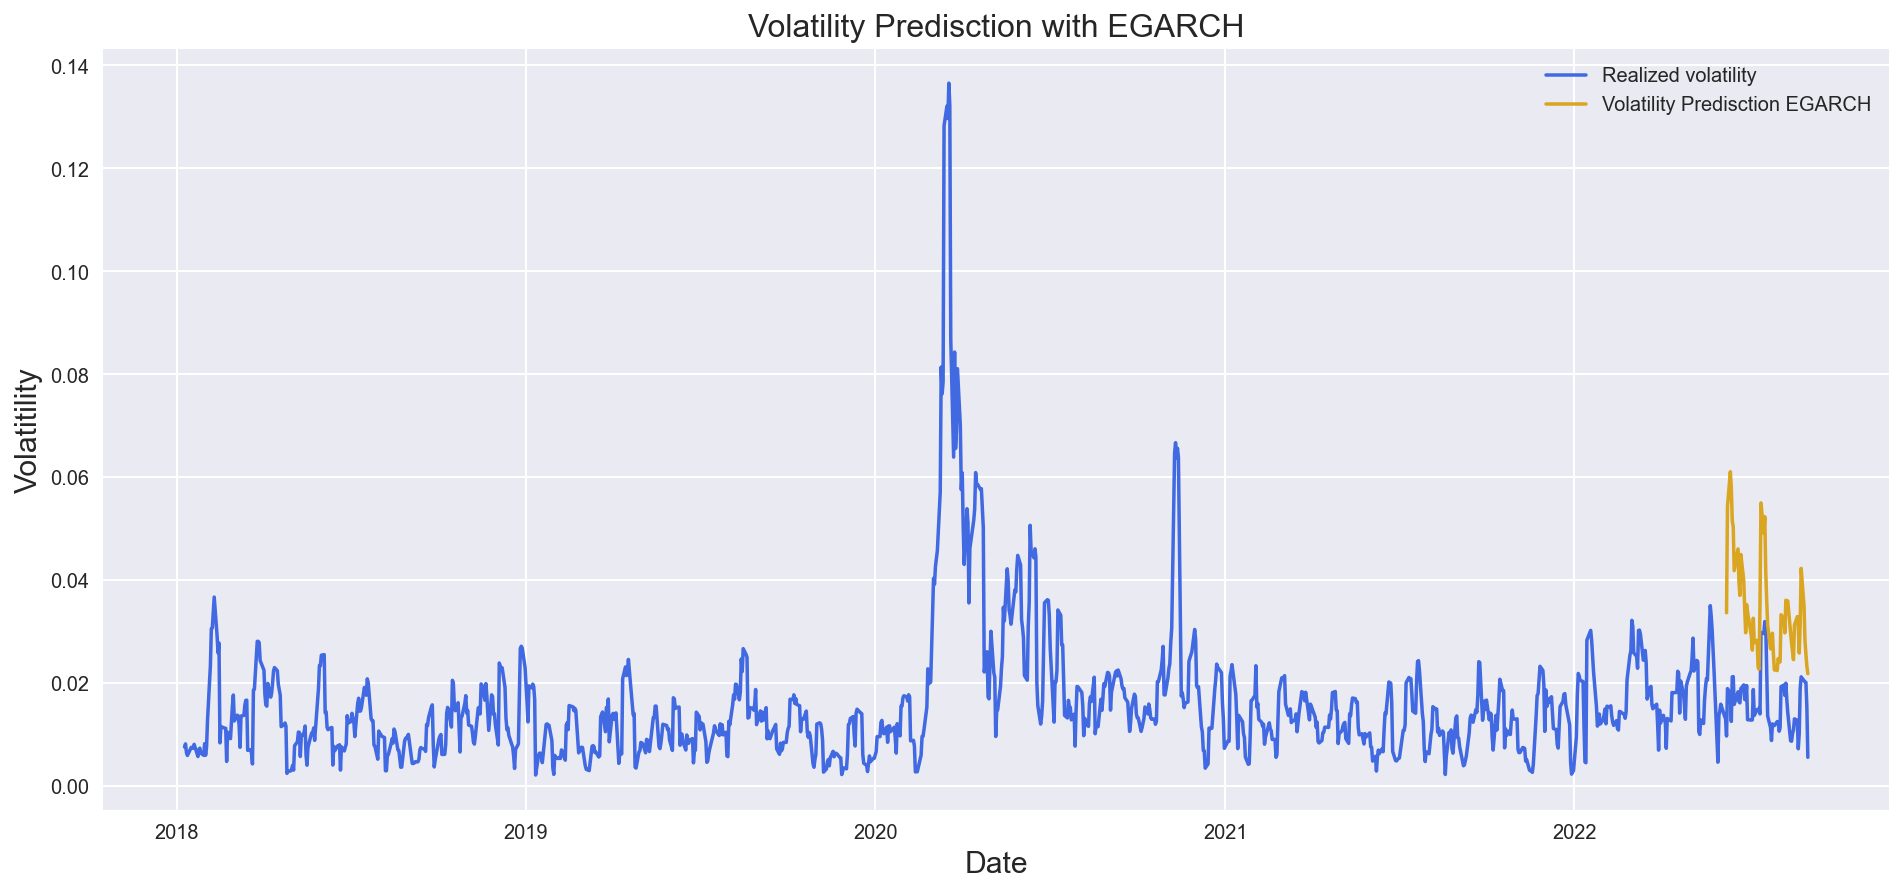

In [102]:
plt.figure(figsize=(16, 7))
plt.plot(jpm_data['Realized_vol'] / 100, label='Realized volatility', c='royalblue')
plt.plot(egarch_forecast.variance.iloc[-len(split_date):] / 100, label='Volatility Predisction EGARCH', c='goldenrod')
plt.title('Volatility Predisction with EGARCH', fontsize=16)
plt.xlabel('Date', fontsize=15)
plt.ylabel('Volatitility', fontsize=15)
plt.legend()

[GO TO TOP](#go-to-top)

<a id='lstm'></a>

## Long Short Term Memory (LSTM)

LSTMs are widely used for sequence prediction problems and have proven to be extremely effective. The reason they work so well is because LSTM is able to store past information that is important, and forget the information that is not. LSTM has three gates:

* The input gate: The input gate adds information to the cell state
* The forget gate: It removes the information that is no longer required by the model
* The output gate: Output Gate at LSTM selects the information to be shown as output

In [103]:
#importing required libraries
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM

In [104]:
#take data
dataset = jpm_stock_data['Adj Close'].copy().to_frame()
#create train and test data
train_data  = jpm_stock_data['Adj Close'].iloc[:int(jpm_stock_data['Adj Close'].shape[0] * 0.90)].dropna().to_frame()
test_data  = jpm_stock_data['Adj Close'].iloc[int(jpm_stock_data['Adj Close'].shape[0] * 0.90):].dropna().to_frame()

In [105]:
scaler = MinMaxScaler(feature_range = (0, 1))
scaled_data = scaler.fit_transform(dataset)

In [106]:
x_train, y_train = [], []
for i in range(60, len(train_data)):
    x_train.append(scaled_data[i - 60:i, 0])
    y_train.append(scaled_data[i, 0])
    
x_train, y_train = np.array(x_train), np.array(y_train)

In [107]:
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [108]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(units = 50, return_sequences = True, input_shape = (x_train.shape[1], 1)))
model.add(LSTM(units=50))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(x_train, y_train, epochs=1, batch_size=1, verbose=2)

2022-09-05 08:45:31.898730: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


999/999 - 24s - loss: 0.0044 - 24s/epoch - 24ms/step


In [109]:
#predicting values, using past 60 from the train data
inputs = dataset[len(dataset) - len(test_data) - 60:].values
inputs = inputs.reshape(-1,1)
inputs  = scaler.transform(inputs)

x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))

In [110]:
X_test = []
for i in range(60,inputs.shape[0]):
    X_test.append(inputs[i-60:i,0])
X_test = np.array(X_test)

X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
closing_price = model.predict(X_test)
closing_price = scaler.inverse_transform(closing_price)

In [111]:
lstm_rmse = np.sqrt(np.mean(np.power((test_data-closing_price),2)))
lstm_rmse[0]

3.7562459673300146

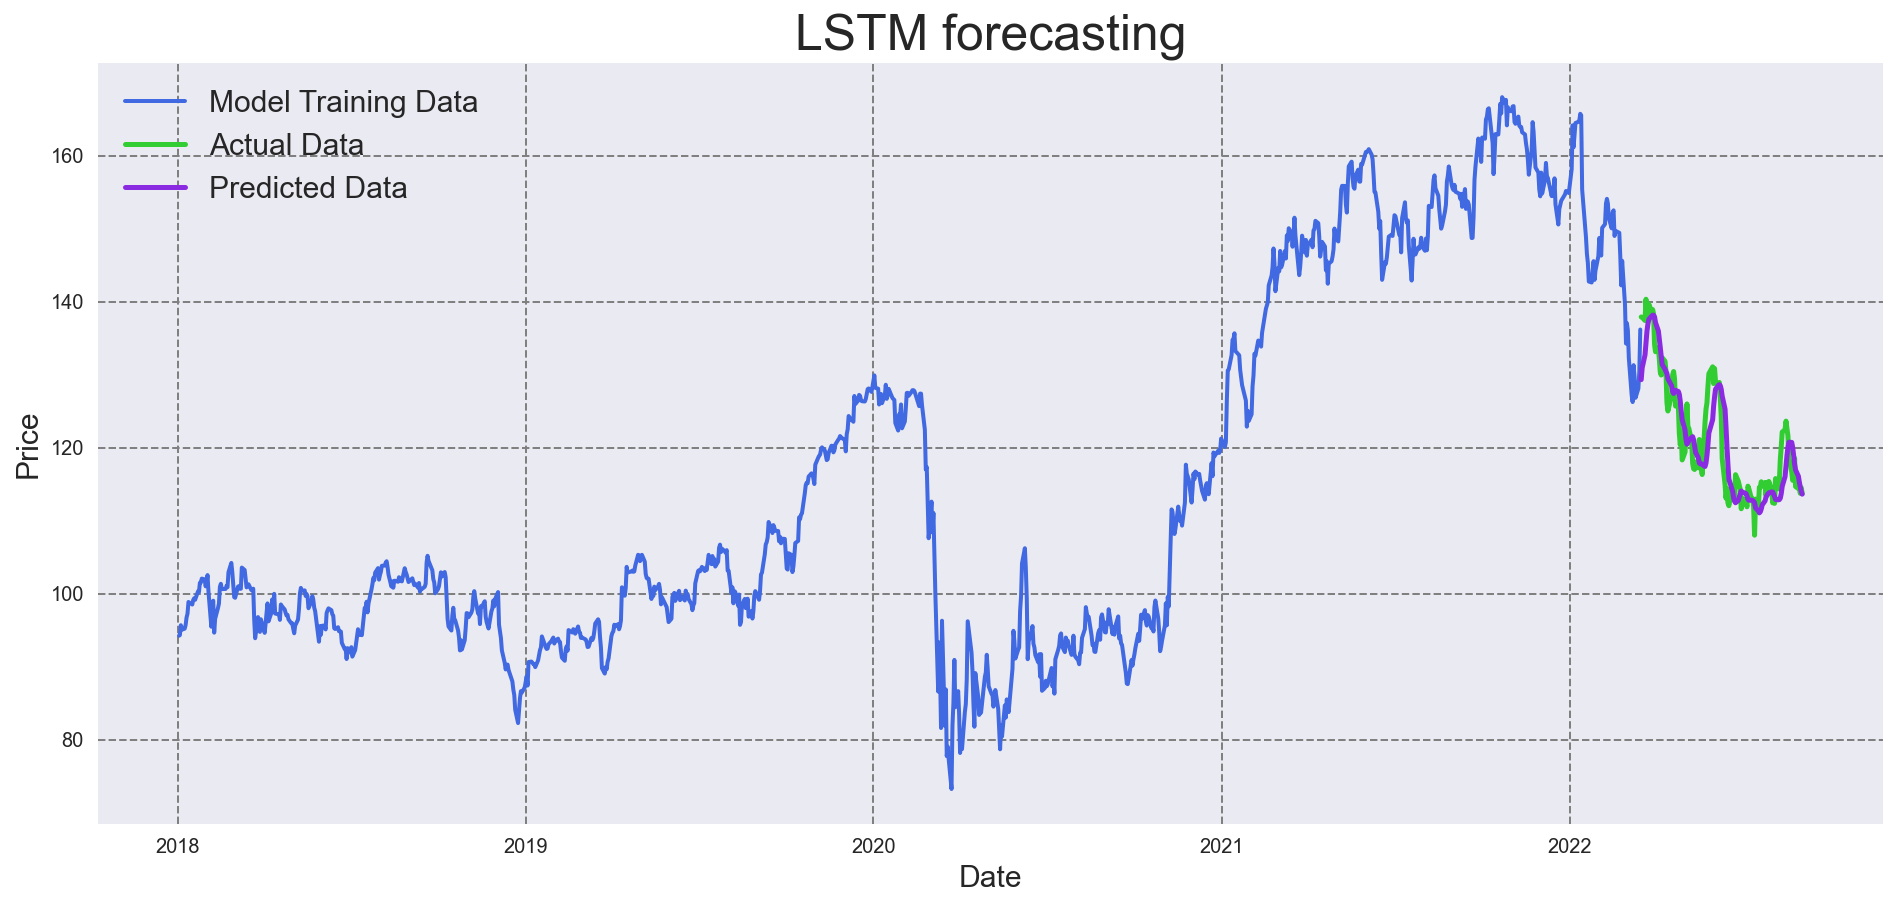

In [112]:
#plotting
test_data['Predictions'] = closing_price

plt.figure(figsize=(16, 7))
plt.plot(train_data, lw=2.0, label='Model Training Data', c='royalblue')
plt.plot(test_data['Adj Close'], lw=2.5, label='Actual Data', c='limegreen')
plt.plot(test_data['Predictions'],lw=2.5, label='Predicted Data', c='blueviolet')
plt.title('LSTM forecasting', fontdict={'fontsize': 25})
plt.xlabel('Date', fontsize=15)
plt.ylabel('Price', fontsize=15)
plt.grid(linestyle='--', c='grey')
plt.legend(loc='upper left', fontsize=15)
plt.show()

[GO TO TOP](#go-to-top)

<a id='results'></a>

## Results

In [113]:
metrics = [
    rmse_simple_smoothing_alpa_0_2, 
    rmse_smpl_smth_alpha_0_99,
    rmse_holt_linear_smoothing,
    rmse_holt_damped_smoothing,
    rmse_triple_exp_smoothing,
    rmse_tripl_exp_smoothing_damped,
    lstm_rmse[0],
    auto_arima_rmse,
    rmse_arch,
    rmse_garch,
    rmse_egarch,
]
index = pd.MultiIndex.from_tuples([
    ('Exponencial smoothing', 'Simple a = 0.2'),
    ('Exponencial smoothing', 'Simple a = 0.99'),
    ('Exponencial smoothing', 'Double Linear'),
    ('Exponencial smoothing', 'Double Damped'),
    ('Exponencial smoothing', 'Triple'), 
    ('Exponencial smoothing', 'Triple Dumped'), 
    ('LSTM', 'LSTM'), 
    ('ARIMA','Auto ARIMA'),
    ('ARCH', 'p=1'), 
    ('GARCH', 'p=1, q=1'),
    ('EGARCH', 'p=1, q=1, o=1'),
])
results = pd.DataFrame(metrics, columns=['RMSE'], index=index)
results

RMSE
Exponencial smoothing Simple a = 0.2   23.809426
                      Simple a = 0.99  10.399615
                      Double Linear    11.376958
                      Double Damped    12.480925
                      Triple           12.214772
                      Triple Dumped    14.691864
LSTM                  LSTM              3.756246
ARIMA                 Auto ARIMA       11.079552
ARCH                  p=1               0.171299
GARCH                 p=1, q=1          0.171299
EGARCH                p=1, q=1, o=1     0.019703

[GO TO TOP](#go-to-top)